In [1]:
import pandas as pd
import json
import os
import datetime
import sys
import seaborn
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates  
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

In [2]:
from sklearn.svm import SVR

In [3]:
from hyperopt import space_eval

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [5]:
from sklearn.linear_model import BayesianRidge

In [6]:
from sklearn.inspection import permutation_importance

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [9]:
eggs_fulldata = [name for name in os.listdir('./dengue_eggs_2018_2024') if name.endswith('.csv')]
eggs_fulldata

['108.csv', '109.csv', '110.csv', '111.csv', '112.csv', '113.csv']

In [10]:
column_names = ["縣市別代碼", "行政區域代碼", "監測週期", "陽性率", "總卵粒數"]

df = {}

for file in eggs_fulldata:
    file_path = './dengue_eggs_2018_2024/' + file
    temp_df = pd.read_csv(file_path, names=column_names)
    temp_df = temp_df.iloc[1:]
    df[file[:-4]] = temp_df

In [11]:
df

{'108':      縣市別代碼    行政區域代碼      監測週期     陽性率   總卵粒數
 1    67000  67000320  108年第23週  53.89%  11243
 2    67000  67000330  108年第23週  50.23%   9318
 3    67000  67000340  108年第23週  54.80%   9535
 4    67000  67000370  108年第23週  55.83%   4497
 5    67000  67000360  108年第23週  51.28%   2776
 ..     ...       ...       ...     ...    ...
 236  67000  67000370  108年第52週   7.08%    531
 237  67000  67000360  108年第52週  11.54%    455
 238  67000  67000350  108年第52週  12.91%   2497
 239  67000  67000310  108年第52週   8.91%   1588
 240  67000  67000270  108年第52週   7.81%    377
 
 [240 rows x 5 columns],
 '109':      縣市別代碼    行政區域代碼      監測週期     陽性率  總卵粒數
 1    67000  67000370   109年第1週   5.83%   369
 2    67000  67000270   109年第1週  11.46%   527
 3    67000  67000340   109年第1週   5.05%   774
 4    67000  67000310   109年第1週  11.82%  2060
 5    67000  67000360   109年第1週   9.62%   452
 ..     ...       ...       ...     ...   ...
 526  67000  67000350  109年第53週  19.93%  3796
 527  67000  67000320  109年

In [12]:
dfs = []

for file in eggs_fulldata:
    file_path = './dengue_eggs_2018_2024/' + file
    temp_df = pd.read_csv(file_path, names=column_names)
    temp_df = temp_df.iloc[1:]
    dfs.append(temp_df)

merged_df = pd.concat(dfs, axis=0, ignore_index=True)

In [13]:
merged_df

縣市別代碼    行政區域代碼      監測週期     陽性率   總卵粒數
0     67000  67000320  108年第23週  53.89%  11243
1     67000  67000330  108年第23週  50.23%   9318
2     67000  67000340  108年第23週  54.80%   9535
3     67000  67000370  108年第23週  55.83%   4497
4     67000  67000360  108年第23週  51.28%   2776
...     ...       ...       ...     ...    ...
2395  67000  67000350   113年第9週  10.13%   1629
2396  67000  67000320   113年第9週   6.48%    805
2397  67000  67000330   113年第9週   9.91%   1329
2398  67000  67000010   113年第9週  11.11%    441
2399  67000  67000280   113年第9週  10.71%    359

[2400 rows x 5 columns]

In [14]:
#把週期轉乘datetime

def convert_week_string_to_datetime(week_string):
    parts = week_string.split('年第')
    year = int(parts[0]) + 1911
    week_number = int(parts[1].rstrip('週'))
    start_of_year = datetime.datetime(year, 1, 1)
    date = start_of_year + datetime.timedelta(weeks=week_number - 1)
    return date

def convert_week_column_to_datetime(df, column_name):
    df[column_name] = df[column_name].apply(convert_week_string_to_datetime)

convert_week_column_to_datetime(merged_df, '監測週期')

In [15]:
merged_df

縣市別代碼    行政區域代碼       監測週期     陽性率   總卵粒數
0     67000  67000320 2019-06-04  53.89%  11243
1     67000  67000330 2019-06-04  50.23%   9318
2     67000  67000340 2019-06-04  54.80%   9535
3     67000  67000370 2019-06-04  55.83%   4497
4     67000  67000360 2019-06-04  51.28%   2776
...     ...       ...        ...     ...    ...
2395  67000  67000350 2024-02-26  10.13%   1629
2396  67000  67000320 2024-02-26   6.48%    805
2397  67000  67000330 2024-02-26   9.91%   1329
2398  67000  67000010 2024-02-26  11.11%    441
2399  67000  67000280 2024-02-26  10.71%    359

[2400 rows x 5 columns]

In [16]:
sorted_df = merged_df.sort_values(by='監測週期')
sorted_df = sorted_df.drop_duplicates()

In [17]:
sorted_df = sorted_df.iloc[1:,:]
sorted_df

縣市別代碼    行政區域代碼       監測週期     陽性率   總卵粒數
1     67000  67000330 2019-06-04  50.23%   9318
2     67000  67000340 2019-06-04  54.80%   9535
3     67000  67000370 2019-06-04  55.83%   4497
4     67000  67000360 2019-06-04  51.28%   2776
5     67000  67000350 2019-06-04  68.14%  25018
...     ...       ...        ...     ...    ...
2305  67000  67000350 2024-03-04  10.13%   1705
2306  67000  67000320 2024-03-04   3.15%    303
2307  67000  67000330 2024-03-04   6.98%    679
2309  67000  67000280 2024-03-04   7.14%    231
2308  67000  67000010 2024-03-04   5.56%     78

[2399 rows x 5 columns]

In [18]:
#sorted_df = sorted_df.sort_index()
#sorted_df

In [19]:
# 刪除索引編號從 0 到 240 的資料
sorted_df = sorted_df.drop(sorted_df.index[:240])
sorted_df

縣市別代碼    行政區域代碼       監測週期     陽性率  總卵粒數
248   67000  67000010 2020-01-01   8.33%   163
247   67000  67000330 2020-01-01   7.21%  1027
246   67000  67000320 2020-01-01   6.48%  1200
245   67000  67000350 2020-01-01  11.60%  2605
244   67000  67000360 2020-01-01   9.62%   452
...     ...       ...        ...     ...   ...
2305  67000  67000350 2024-03-04  10.13%  1705
2306  67000  67000320 2024-03-04   3.15%   303
2307  67000  67000330 2024-03-04   6.98%   679
2309  67000  67000280 2024-03-04   7.14%   231
2308  67000  67000010 2024-03-04   5.56%    78

[2159 rows x 5 columns]

In [20]:
#用陽性率轉成陽性數
#positive_num = sorted_df['陽性率'].copy()
#positive_num = positive_num.str.replace('%', '').astype(float) / 100
#positive_num = positive_num*12.0
#positive_num.name = '陽性數'
#sorted_df.insert(3, '陽性數', positive_num)
#sorted_df

In [21]:
positive_rate = sorted_df['陽性率'].copy()
positive_rate = positive_rate.str.replace('%', '').astype(float)/100
sorted_df.insert(3, '陽性率%', positive_rate)

In [22]:
sorted_df = sorted_df.drop(columns=['陽性率'])
sorted_df

縣市別代碼    行政區域代碼       監測週期    陽性率%  總卵粒數
248   67000  67000010 2020-01-01  0.0833   163
247   67000  67000330 2020-01-01  0.0721  1027
246   67000  67000320 2020-01-01  0.0648  1200
245   67000  67000350 2020-01-01  0.1160  2605
244   67000  67000360 2020-01-01  0.0962   452
...     ...       ...        ...     ...   ...
2305  67000  67000350 2024-03-04  0.1013  1705
2306  67000  67000320 2024-03-04  0.0315   303
2307  67000  67000330 2024-03-04  0.0698   679
2309  67000  67000280 2024-03-04  0.0714   231
2308  67000  67000010 2024-03-04  0.0556    78

[2159 rows x 5 columns]

In [23]:
sorted_df = sorted_df.reset_index(drop=True)
sorted_df

縣市別代碼    行政區域代碼       監測週期    陽性率%  總卵粒數
0     67000  67000010 2020-01-01  0.0833   163
1     67000  67000330 2020-01-01  0.0721  1027
2     67000  67000320 2020-01-01  0.0648  1200
3     67000  67000350 2020-01-01  0.1160  2605
4     67000  67000360 2020-01-01  0.0962   452
...     ...       ...        ...     ...   ...
2154  67000  67000350 2024-03-04  0.1013  1705
2155  67000  67000320 2024-03-04  0.0315   303
2156  67000  67000330 2024-03-04  0.0698   679
2157  67000  67000280 2024-03-04  0.0714   231
2158  67000  67000010 2024-03-04  0.0556    78

[2159 rows x 5 columns]

In [24]:
sorted_df.head(10)

縣市別代碼    行政區域代碼       監測週期    陽性率%  總卵粒數
0  67000  67000010 2020-01-01  0.0833   163
1  67000  67000330 2020-01-01  0.0721  1027
2  67000  67000320 2020-01-01  0.0648  1200
3  67000  67000350 2020-01-01  0.1160  2605
4  67000  67000360 2020-01-01  0.0962   452
5  67000  67000340 2020-01-01  0.0505   774
6  67000  67000270 2020-01-01  0.1146   527
7  67000  67000370 2020-01-01  0.0583   369
8  67000  67000310 2020-01-01  0.1182  2060
9  67000  67000330 2020-01-08  0.1014  1260

In [25]:
sorted_df.tail(10)

縣市別代碼    行政區域代碼       監測週期    陽性率%  總卵粒數
2149  67000  67000370 2024-03-04  0.0458   229
2150  67000  67000270 2024-03-04  0.0885   278
2151  67000  67000340 2024-03-04  0.0783  1058
2152  67000  67000310 2024-03-04  0.0891  1149
2153  67000  67000360 2024-03-04  0.0321   200
2154  67000  67000350 2024-03-04  0.1013  1705
2155  67000  67000320 2024-03-04  0.0315   303
2156  67000  67000330 2024-03-04  0.0698   679
2157  67000  67000280 2024-03-04  0.0714   231
2158  67000  67000010 2024-03-04  0.0556    78

In [26]:
print(sorted_df.dtypes)

縣市別代碼             object
行政區域代碼            object
監測週期      datetime64[ns]
陽性率%             float64
總卵粒數              object
dtype: object


In [27]:
sorted_df['總卵粒數'] =sorted_df['總卵粒數'].astype(float)
print(sorted_df.dtypes)

縣市別代碼             object
行政區域代碼            object
監測週期      datetime64[ns]
陽性率%             float64
總卵粒數             float64
dtype: object


In [28]:
sorted_df['行政區域代碼'].unique()

array(['67000010', '67000330', '67000320', '67000350', '67000360',
       '67000340', '67000270', '67000370', '67000310', '67000280', '新營區',
       '南區', '東區', '安南區', '安平區', '永康區', '北區', '仁德區', '中西區', '歸仁區'],
      dtype=object)

In [29]:
sorted_df['行政區域代碼'] = sorted_df['行政區域代碼'].replace({'新營區':'67000010', '南區':'67000330', '東區':'67000320', '安南區':'67000350','安平區': '67000360','永康區': '67000310', '北區': '67000340','仁德區': '67000270','中西區': '67000370','歸仁區': '67000280'})
sorted_df['行政區域代碼'].unique()

array(['67000010', '67000330', '67000320', '67000350', '67000360',
       '67000340', '67000270', '67000370', '67000310', '67000280'],
      dtype=object)

In [30]:
sorted_df['行政區域代碼'] =sorted_df['行政區域代碼'].astype(float)
print(sorted_df.dtypes)

縣市別代碼             object
行政區域代碼           float64
監測週期      datetime64[ns]
陽性率%             float64
總卵粒數             float64
dtype: object


In [31]:
sorted_df = sorted_df.drop(columns=['縣市別代碼'])
sorted_df

行政區域代碼       監測週期    陽性率%    總卵粒數
0     67000010.0 2020-01-01  0.0833   163.0
1     67000330.0 2020-01-01  0.0721  1027.0
2     67000320.0 2020-01-01  0.0648  1200.0
3     67000350.0 2020-01-01  0.1160  2605.0
4     67000360.0 2020-01-01  0.0962   452.0
...          ...        ...     ...     ...
2154  67000350.0 2024-03-04  0.1013  1705.0
2155  67000320.0 2024-03-04  0.0315   303.0
2156  67000330.0 2024-03-04  0.0698   679.0
2157  67000280.0 2024-03-04  0.0714   231.0
2158  67000010.0 2024-03-04  0.0556    78.0

[2159 rows x 4 columns]

In [32]:
num_rows_sorted_df = sorted_df.shape[0]
num_rows_sorted_df

2159

# 查看目標區資料

In [33]:
#永康區
selected_data = sorted_df[sorted_df['行政區域代碼'] == 67000310].copy()
selected_data

行政區域代碼       監測週期    陽性率%    總卵粒數
8     67000310.0 2020-01-01  0.1182  2060.0
14    67000310.0 2020-01-08  0.1570  2543.0
25    67000310.0 2020-01-15  0.1628  2775.0
35    67000310.0 2020-01-22  0.1105  1910.0
44    67000310.0 2020-01-29  0.1550  3513.0
...          ...        ...     ...     ...
2115  67000310.0 2024-02-05  0.0969  1217.0
2126  67000310.0 2024-02-12  0.0426   522.0
2132  67000310.0 2024-02-19  0.0446   539.0
2143  67000310.0 2024-02-26  0.0620   885.0
2152  67000310.0 2024-03-04  0.0891  1149.0

[216 rows x 4 columns]

In [34]:
young_df = selected_data.copy()

In [35]:
young_df['總卵粒數1'] = young_df['總卵粒數'].shift(periods=1,fill_value=0)
young_df

行政區域代碼       監測週期    陽性率%    總卵粒數   總卵粒數1
8     67000310.0 2020-01-01  0.1182  2060.0     0.0
14    67000310.0 2020-01-08  0.1570  2543.0  2060.0
25    67000310.0 2020-01-15  0.1628  2775.0  2543.0
35    67000310.0 2020-01-22  0.1105  1910.0  2775.0
44    67000310.0 2020-01-29  0.1550  3513.0  1910.0
...          ...        ...     ...     ...     ...
2115  67000310.0 2024-02-05  0.0969  1217.0   693.0
2126  67000310.0 2024-02-12  0.0426   522.0  1217.0
2132  67000310.0 2024-02-19  0.0446   539.0   522.0
2143  67000310.0 2024-02-26  0.0620   885.0   539.0
2152  67000310.0 2024-03-04  0.0891  1149.0   885.0

[216 rows x 5 columns]

In [36]:
young_df['總卵粒數2'] = young_df['總卵粒數'].shift(periods=2,fill_value=0)
young_df['總卵粒數3'] = young_df['總卵粒數'].shift(periods=3,fill_value=0)

In [37]:
young_df

行政區域代碼       監測週期    陽性率%    總卵粒數   總卵粒數1   總卵粒數2   總卵粒數3
8     67000310.0 2020-01-01  0.1182  2060.0     0.0     0.0     0.0
14    67000310.0 2020-01-08  0.1570  2543.0  2060.0     0.0     0.0
25    67000310.0 2020-01-15  0.1628  2775.0  2543.0  2060.0     0.0
35    67000310.0 2020-01-22  0.1105  1910.0  2775.0  2543.0  2060.0
44    67000310.0 2020-01-29  0.1550  3513.0  1910.0  2775.0  2543.0
...          ...        ...     ...     ...     ...     ...     ...
2115  67000310.0 2024-02-05  0.0969  1217.0   693.0  1339.0   677.0
2126  67000310.0 2024-02-12  0.0426   522.0  1217.0   693.0  1339.0
2132  67000310.0 2024-02-19  0.0446   539.0   522.0  1217.0   693.0
2143  67000310.0 2024-02-26  0.0620   885.0   539.0   522.0  1217.0
2152  67000310.0 2024-03-04  0.0891  1149.0   885.0   539.0   522.0

[216 rows x 7 columns]

In [38]:
num_rows_selected_data = selected_data.shape[0]
num_rows_selected_data

216

C:\Users\lilj\AppData\Local\Temp\ipykernel_10200\634149008.py:13: UserWarning: Glyph 27704 (\N{CJK UNIFIED IDEOGRAPH-6C38}) missing from current font.
  plt.tight_layout()
C:\Users\lilj\AppData\Local\Temp\ipykernel_10200\634149008.py:13: UserWarning: Glyph 24247 (\N{CJK UNIFIED IDEOGRAPH-5EB7}) missing from current font.
  plt.tight_layout()
C:\Users\lilj\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27704 (\N{CJK UNIFIED IDEOGRAPH-6C38}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\lilj\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24247 (\N{CJK UNIFIED IDEOGRAPH-5EB7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


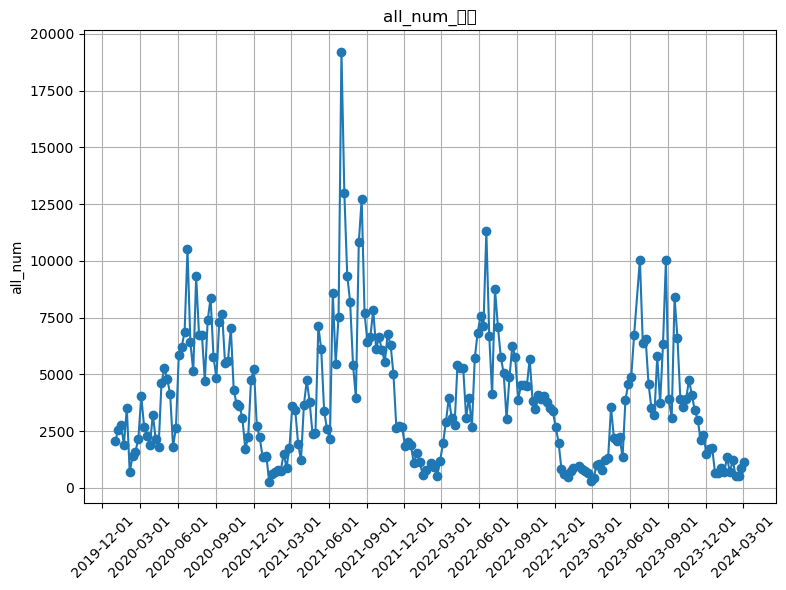

In [39]:
plt.figure(figsize=(8, 6))

plt.plot(selected_data['監測週期'], selected_data['總卵粒數'], marker='o', linestyle='-')

plt.ylabel('all_num')
plt.title('all_num_永康')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\lilj\AppData\Local\Temp\ipykernel_10200\1860517544.py:13: UserWarning: Glyph 38525 (\N{CJK UNIFIED IDEOGRAPH-967D}) missing from current font.
  plt.tight_layout()
C:\Users\lilj\AppData\Local\Temp\ipykernel_10200\1860517544.py:13: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from current font.
  plt.tight_layout()
C:\Users\lilj\AppData\Local\Temp\ipykernel_10200\1860517544.py:13: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.tight_layout()
C:\Users\lilj\AppData\Local\Temp\ipykernel_10200\1860517544.py:13: UserWarning: Glyph 27704 (\N{CJK UNIFIED IDEOGRAPH-6C38}) missing from current font.
  plt.tight_layout()
C:\Users\lilj\AppData\Local\Temp\ipykernel_10200\1860517544.py:13: UserWarning: Glyph 24247 (\N{CJK UNIFIED IDEOGRAPH-5EB7}) missing from current font.
  plt.tight_layout()
C:\Users\lilj\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38525 (\N{CJK UNIFIED IDEOGRAPH-967D}) mis

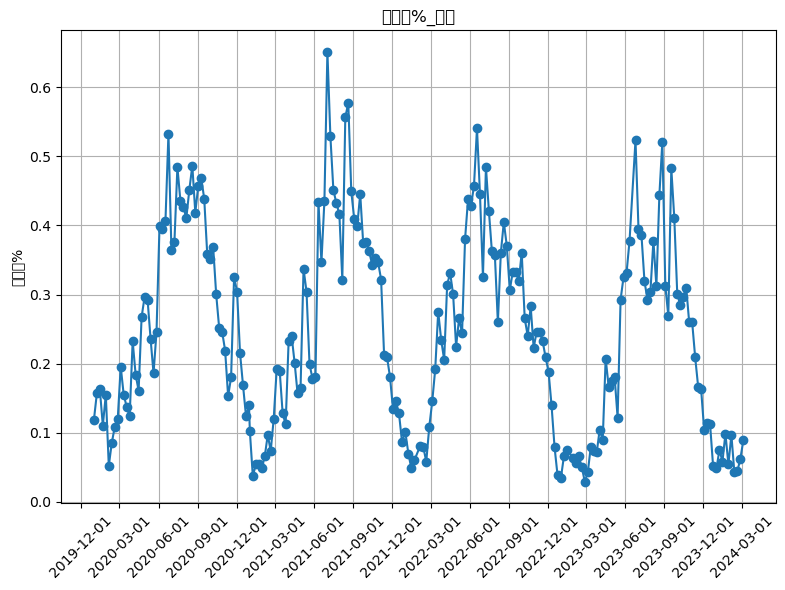

In [40]:
plt.figure(figsize=(8, 6))

plt.plot(selected_data['監測週期'], selected_data['陽性率%'], marker='o', linestyle='-')

plt.ylabel('陽性率%')
plt.title('陽性率%_永康')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 讀取天氣資料

In [41]:
weather = pd.read_csv('young_kang_2018-2024_weather_.csv')
weather

觀測時間(day)  測站氣壓(hPa)  氣溫(℃)  最高氣溫(℃)  最低氣溫(℃)  相對溼度(%)  風速(m/s)  \
0     2019-01-01     1021.5   18.7     23.8     16.0     75.0      3.4   
1     2019-01-02     1021.3   19.1     22.9     16.8     77.0      3.0   
2     2019-01-03     1021.3   20.3     25.6     17.7     79.0      3.5   
3     2019-01-04     1020.7   20.7     26.3     17.6     81.0      1.7   
4     2019-01-05     1018.3   22.6     29.2     18.6     77.0      2.2   
...          ...        ...    ...      ...      ...      ...      ...   
1908  2024-03-25     1013.5   27.4     31.6     24.7     73.0      3.3   
1909  2024-03-26     1015.6   26.4     31.1     22.8     73.0      2.7   
1910  2024-03-27     1016.8   24.6     30.8     20.6     67.0      2.7   
1911  2024-03-28     1012.2   26.2     31.0     22.8     72.0      2.2   
1912  2024-03-29     1012.5   26.4     30.7     23.9     73.0      2.1   

      風向(360degree)  最大瞬間風(m/s)  最大瞬間風風向(360degree)  降水量(mm)  降水時數(hour)  \
0               360         8.8               350.0      0.0         0.0   
1               360         7.9                30.0      0.0         0.1   
2               360         9.6               350.0      0.0         0.0   
3               320         6.8               310.0      0.0         0.0   
4               360         5.7               310.0      0.0         0.3   
...             ...         ...                 ...      ...         ...   
1908            160        12.3               220.0      0.0         0.0   
1909            310         8.6               330.0      0.0         0.0   
1910            340         8.1               340.0      0.0         0.0   
1911            300         8.1               330.0      0.0         0.0   
1912            340         7.3               290.0      0.0         0.0   

      最大十分鐘降水量(mm)  最大六十分鐘降水量(mm)  日照時數(hour)  日照率(%)  
0              0.0            0.0         0.3     2.8  
1              0.0            0.0         0.0     0.0  
2              0.0            0.0         4.7    43.9  
3              0.0            0.0         4.0    37.3  
4              0.0            0.0         8.2    76.4  
...            ...            ...         ...     ...  
1908           0.0            0.0        10.1    82.8  
1909           0.0            0.0         7.4    60.6  
1910           0.0            0.0         7.1    58.0  
1911           0.0            0.0         5.3    43.2  
1912           0.0            0.0         4.3    35.0  

[1913 rows x 16 columns]

In [42]:
#天氣資料延滯一天
weather_delay1 = weather.copy()
weather_delay1.iloc[:, 1:] = weather_delay1.iloc[:, 1:].shift(1)
#weather_delay1.fillna(0, inplace=True)
weather_delay1

觀測時間(day)  測站氣壓(hPa)  氣溫(℃)  最高氣溫(℃)  最低氣溫(℃)  相對溼度(%)  風速(m/s)  \
0     2019-01-01        NaN    NaN      NaN      NaN      NaN      NaN   
1     2019-01-02     1021.5   18.7     23.8     16.0     75.0      3.4   
2     2019-01-03     1021.3   19.1     22.9     16.8     77.0      3.0   
3     2019-01-04     1021.3   20.3     25.6     17.7     79.0      3.5   
4     2019-01-05     1020.7   20.7     26.3     17.6     81.0      1.7   
...          ...        ...    ...      ...      ...      ...      ...   
1908  2024-03-25     1014.7   27.3     32.6     23.9     73.0      2.8   
1909  2024-03-26     1013.5   27.4     31.6     24.7     73.0      3.3   
1910  2024-03-27     1015.6   26.4     31.1     22.8     73.0      2.7   
1911  2024-03-28     1016.8   24.6     30.8     20.6     67.0      2.7   
1912  2024-03-29     1012.2   26.2     31.0     22.8     72.0      2.2   

      風向(360degree)  最大瞬間風(m/s)  最大瞬間風風向(360degree)  降水量(mm)  降水時數(hour)  \
0               NaN         NaN                 NaN      NaN         NaN   
1             360.0         8.8               350.0      0.0         0.0   
2             360.0         7.9                30.0      0.0         0.1   
3             360.0         9.6               350.0      0.0         0.0   
4             320.0         6.8               310.0      0.0         0.0   
...             ...         ...                 ...      ...         ...   
1908          230.0         8.0               240.0      0.0         0.0   
1909          160.0        12.3               220.0      0.0         0.0   
1910          310.0         8.6               330.0      0.0         0.0   
1911          340.0         8.1               340.0      0.0         0.0   
1912          300.0         8.1               330.0      0.0         0.0   

      最大十分鐘降水量(mm)  最大六十分鐘降水量(mm)  日照時數(hour)  日照率(%)  
0              NaN            NaN         NaN     NaN  
1              0.0            0.0         0.3     2.8  
2              0.0            0.0         0.0     0.0  
3              0.0            0.0         4.7    43.9  
4              0.0            0.0         4.0    37.3  
...            ...            ...         ...     ...  
1908           0.0            0.0         8.9    73.1  
1909           0.0            0.0        10.1    82.8  
1910           0.0            0.0         7.4    60.6  
1911           0.0            0.0         7.1    58.0  
1912           0.0            0.0         5.3    43.2  

[1913 rows x 16 columns]

In [43]:
#天氣資料延滯2天
weather_delay2 = weather.copy()
weather_delay2.iloc[:, 1:] = weather_delay2.iloc[:, 1:].shift(2)
#weather_delay2

In [44]:
#天氣資料延滯3天
weather_delay3 = weather.copy()
weather_delay3.iloc[:, 1:] = weather_delay3.iloc[:, 1:].shift(3)

In [45]:
#天氣資料延滯4天
weather_delay4 = weather.copy()
weather_delay4.iloc[:, 1:] = weather_delay4.iloc[:, 1:].shift(4)

In [46]:
#天氣資料延滯5天
weather_delay5 = weather.copy()
weather_delay5.iloc[:, 1:] = weather_delay5.iloc[:, 1:].shift(5)

# 合併資料

In [47]:
weather['觀測時間(day)'] = pd.to_datetime(weather['觀測時間(day)'])
selected_data['監測週期'] = pd.to_datetime(selected_data['監測週期'])

In [48]:
weather_delay1['觀測時間(day)'] = pd.to_datetime(weather_delay1['觀測時間(day)'])
weather_delay2['觀測時間(day)'] = pd.to_datetime(weather_delay2['觀測時間(day)'])
weather_delay3['觀測時間(day)'] = pd.to_datetime(weather_delay3['觀測時間(day)'])
weather_delay4['觀測時間(day)'] = pd.to_datetime(weather_delay4['觀測時間(day)'])
weather_delay5['觀測時間(day)'] = pd.to_datetime(weather_delay5['觀測時間(day)'])

#合併全部台南資料

In [49]:
sorted_df['監測週期'] = pd.to_datetime(sorted_df['監測週期'])

In [50]:
merged_df_3_tainan = pd.merge(weather_delay3 , sorted_df , left_on='觀測時間(day)', right_on='監測週期', how='inner')

merged_df_3_tainan

觀測時間(day)  測站氣壓(hPa)  氣溫(℃)  最高氣溫(℃)  最低氣溫(℃)  相對溼度(%)  風速(m/s)  \
0    2020-01-01     1016.4   18.7     19.8     17.8     88.0      3.0   
1    2020-01-01     1016.4   18.7     19.8     17.8     88.0      3.0   
2    2020-01-01     1016.4   18.7     19.8     17.8     88.0      3.0   
3    2020-01-01     1016.4   18.7     19.8     17.8     88.0      3.0   
4    2020-01-01     1016.4   18.7     19.8     17.8     88.0      3.0   
...         ...        ...    ...      ...      ...      ...      ...   
2154 2024-03-04     1017.2   16.7     19.6     14.0     71.0      5.4   
2155 2024-03-04     1017.2   16.7     19.6     14.0     71.0      5.4   
2156 2024-03-04     1017.2   16.7     19.6     14.0     71.0      5.4   
2157 2024-03-04     1017.2   16.7     19.6     14.0     71.0      5.4   
2158 2024-03-04     1017.2   16.7     19.6     14.0     71.0      5.4   

      風向(360degree)  最大瞬間風(m/s)  最大瞬間風風向(360degree)  降水量(mm)  降水時數(hour)  \
0              10.0        10.3               360.0     46.0         7.6   
1              10.0        10.3               360.0     46.0         7.6   
2              10.0        10.3               360.0     46.0         7.6   
3              10.0        10.3               360.0     46.0         7.6   
4              10.0        10.3               360.0     46.0         7.6   
...             ...         ...                 ...      ...         ...   
2154          360.0        13.2                10.0      0.0         0.0   
2155          360.0        13.2                10.0      0.0         0.0   
2156          360.0        13.2                10.0      0.0         0.0   
2157          360.0        13.2                10.0      0.0         0.0   
2158          360.0        13.2                10.0      0.0         0.0   

      最大十分鐘降水量(mm)  最大六十分鐘降水量(mm)  日照時數(hour)  日照率(%)      行政區域代碼       監測週期  \
0              3.5            9.5         0.0     0.0  67000010.0 2020-01-01   
1              3.5            9.5         0.0     0.0  67000330.0 2020-01-01   
2              3.5            9.5         0.0     0.0  67000320.0 2020-01-01   
3              3.5            9.5         0.0     0.0  67000350.0 2020-01-01   
4              3.5            9.5         0.0     0.0  67000360.0 2020-01-01   
...            ...            ...         ...     ...         ...        ...   
2154           0.0            0.0         0.0     0.0  67000350.0 2024-03-04   
2155           0.0            0.0         0.0     0.0  67000320.0 2024-03-04   
2156           0.0            0.0         0.0     0.0  67000330.0 2024-03-04   
2157           0.0            0.0         0.0     0.0  67000280.0 2024-03-04   
2158           0.0            0.0         0.0     0.0  67000010.0 2024-03-04   

        陽性率%    總卵粒數  
0     0.0833   163.0  
1     0.0721  1027.0  
2     0.0648  1200.0  
3     0.1160  2605.0  
4     0.0962   452.0  
...      ...     ...  
2154  0.1013  1705.0  
2155  0.0315   303.0  
2156  0.0698   679.0  
2157  0.0714   231.0  
2158  0.0556    78.0  

[2159 rows x 20 columns]

In [51]:
merged_df_3_tainan = merged_df_3_tainan.drop(columns=['行政區域代碼','監測週期'])

In [52]:
#merged_df_3_tainan = merged_df_3_tainan.iloc[:, new_column_order]
merged_df_3_tainan

觀測時間(day)  測站氣壓(hPa)  氣溫(℃)  最高氣溫(℃)  最低氣溫(℃)  相對溼度(%)  風速(m/s)  \
0    2020-01-01     1016.4   18.7     19.8     17.8     88.0      3.0   
1    2020-01-01     1016.4   18.7     19.8     17.8     88.0      3.0   
2    2020-01-01     1016.4   18.7     19.8     17.8     88.0      3.0   
3    2020-01-01     1016.4   18.7     19.8     17.8     88.0      3.0   
4    2020-01-01     1016.4   18.7     19.8     17.8     88.0      3.0   
...         ...        ...    ...      ...      ...      ...      ...   
2154 2024-03-04     1017.2   16.7     19.6     14.0     71.0      5.4   
2155 2024-03-04     1017.2   16.7     19.6     14.0     71.0      5.4   
2156 2024-03-04     1017.2   16.7     19.6     14.0     71.0      5.4   
2157 2024-03-04     1017.2   16.7     19.6     14.0     71.0      5.4   
2158 2024-03-04     1017.2   16.7     19.6     14.0     71.0      5.4   

      風向(360degree)  最大瞬間風(m/s)  最大瞬間風風向(360degree)  降水量(mm)  降水時數(hour)  \
0              10.0        10.3               360.0     46.0         7.6   
1              10.0        10.3               360.0     46.0         7.6   
2              10.0        10.3               360.0     46.0         7.6   
3              10.0        10.3               360.0     46.0         7.6   
4              10.0        10.3               360.0     46.0         7.6   
...             ...         ...                 ...      ...         ...   
2154          360.0        13.2                10.0      0.0         0.0   
2155          360.0        13.2                10.0      0.0         0.0   
2156          360.0        13.2                10.0      0.0         0.0   
2157          360.0        13.2                10.0      0.0         0.0   
2158          360.0        13.2                10.0      0.0         0.0   

      最大十分鐘降水量(mm)  最大六十分鐘降水量(mm)  日照時數(hour)  日照率(%)    陽性率%    總卵粒數  
0              3.5            9.5         0.0     0.0  0.0833   163.0  
1              3.5            9.5         0.0     0.0  0.0721  1027.0  
2              3.5            9.5         0.0     0.0  0.0648  1200.0  
3              3.5            9.5         0.0     0.0  0.1160  2605.0  
4              3.5            9.5         0.0     0.0  0.0962   452.0  
...            ...            ...         ...     ...     ...     ...  
2154           0.0            0.0         0.0     0.0  0.1013  1705.0  
2155           0.0            0.0         0.0     0.0  0.0315   303.0  
2156           0.0            0.0         0.0     0.0  0.0698   679.0  
2157           0.0            0.0         0.0     0.0  0.0714   231.0  
2158           0.0            0.0         0.0     0.0  0.0556    78.0  

[2159 rows x 18 columns]

#合併永康區資料

In [53]:
merged_df_1 = pd.merge(weather, selected_data, left_on='觀測時間(day)', right_on='監測週期', how='inner')

merged_df_1

觀測時間(day)  測站氣壓(hPa)  氣溫(℃)  最高氣溫(℃)  最低氣溫(℃)  相對溼度(%)  風速(m/s)  \
0   2020-01-01     1023.3   17.8     22.8     14.9     76.0      2.6   
1   2020-01-08     1016.6   20.0     25.8     16.4     74.0      2.9   
2   2020-01-15     1017.1   18.2     25.8     14.0     76.0      2.9   
3   2020-01-22     1017.8   21.7     28.2     16.8     70.0      1.9   
4   2020-01-29     1016.5   14.3     18.8     11.9     67.0      5.4   
..         ...        ...    ...      ...      ...      ...      ...   
211 2024-02-05     1017.1   20.8     27.2     17.5     82.0      3.8   
212 2024-02-12     1024.8   17.3     23.9     12.8     67.0      2.2   
213 2024-02-19     1015.2   25.5     31.3     21.0     72.0      2.7   
214 2024-02-26     1019.5   17.6     23.8     14.4     69.0      3.7   
215 2024-03-04     1013.1   22.5     27.9     16.3     70.0      2.8   

     風向(360degree)  最大瞬間風(m/s)  最大瞬間風風向(360degree)  降水量(mm)  降水時數(hour)  \
0              360         7.7               330.0      0.0         0.0   
1              350         8.3                10.0      0.0         0.0   
2              350         8.9               340.0      0.0         0.0   
3              360         9.6               350.0      0.0         0.0   
4              360        11.6               360.0      0.0         0.0   
..             ...         ...                 ...      ...         ...   
211            360        12.1               360.0      0.0         0.0   
212            360         8.4               320.0      0.0         0.0   
213            250         8.1               280.0      0.0         0.0   
214            360        11.3               350.0      0.0         0.0   
215             10         8.6               150.0      0.0         0.0   

     最大十分鐘降水量(mm)  最大六十分鐘降水量(mm)  日照時數(hour)  日照率(%)      行政區域代碼       監測週期  \
0             0.0            0.0         5.1    47.6  67000310.0 2020-01-01   
1             0.0            0.0         9.6    89.3  67000310.0 2020-01-08   
2             0.0            0.0         8.7    80.4  67000310.0 2020-01-15   
3             0.0            0.0         6.8    62.4  67000310.0 2020-01-22   
4             0.0            0.0         3.6    32.7  67000310.0 2020-01-29   
..            ...            ...         ...     ...         ...        ...   
211           0.0            0.0         2.3    20.6  67000310.0 2024-02-05   
212           0.0            0.0        10.5    93.1  67000310.0 2024-02-12   
213           0.0            0.0         8.9    77.9  67000310.0 2024-02-19   
214           0.0            0.0         3.0    25.9  67000310.0 2024-02-26   
215           0.0            0.0         7.4    63.1  67000310.0 2024-03-04   

       陽性率%    總卵粒數  
0    0.1182  2060.0  
1    0.1570  2543.0  
2    0.1628  2775.0  
3    0.1105  1910.0  
4    0.1550  3513.0  
..      ...     ...  
211  0.0969  1217.0  
212  0.0426   522.0  
213  0.0446   539.0  
214  0.0620   885.0  
215  0.0891  1149.0  

[216 rows x 20 columns]

In [54]:
merged_df_2 = pd.merge(weather_delay1, selected_data, left_on='觀測時間(day)', right_on='監測週期', how='inner')
merged_df_3 = pd.merge(weather_delay2, selected_data, left_on='觀測時間(day)', right_on='監測週期', how='inner')
merged_df_4 = pd.merge(weather_delay3, selected_data, left_on='觀測時間(day)', right_on='監測週期', how='inner')
merged_df_5 = pd.merge(weather_delay4, selected_data, left_on='觀測時間(day)', right_on='監測週期', how='inner')
merged_df_6 = pd.merge(weather_delay5, selected_data, left_on='觀測時間(day)', right_on='監測週期', how='inner')

In [55]:
number = merged_df_1.shape[0]
number

216

In [56]:
#merged_df_1 = merged_df_1.drop(columns=['行政區域代碼','監測週期'])
merged_df_2 = merged_df_2.drop(columns=['行政區域代碼','監測週期'])
merged_df_3 = merged_df_3.drop(columns=['行政區域代碼','監測週期'])
merged_df_4 = merged_df_4.drop(columns=['行政區域代碼','監測週期'])
merged_df_5 = merged_df_5.drop(columns=['行政區域代碼','監測週期'])
merged_df_6 = merged_df_6.drop(columns=['行政區域代碼','監測週期'])

merged_df_6

觀測時間(day)  測站氣壓(hPa)  氣溫(℃)  最高氣溫(℃)  最低氣溫(℃)  相對溼度(%)  風速(m/s)  \
0   2020-01-01     1016.6   18.0     21.0     16.1     67.0      4.5   
1   2020-01-08     1020.7   19.3     24.3     16.4     79.0      1.3   
2   2020-01-15     1014.6   19.9     26.3     16.8     78.0      2.3   
3   2020-01-22     1016.6   17.8     24.7     13.4     76.0      4.7   
4   2020-01-29     1017.1   22.4     28.2     19.5     77.0      3.1   
..         ...        ...    ...      ...      ...      ...      ...   
211 2024-02-05     1018.6   22.1     28.5     17.9     81.0      1.5   
212 2024-02-12     1015.5   19.0     24.0     15.3     83.0      4.4   
213 2024-02-19     1019.1   21.3     28.9     14.8     53.0      1.8   
214 2024-02-26     1014.4   26.2     33.0     21.4     61.0      2.9   
215 2024-03-04     1017.3   20.4     27.8     15.6     72.0      2.6   

     風向(360degree)  最大瞬間風(m/s)  最大瞬間風風向(360degree)  降水量(mm)  降水時數(hour)  \
0            360.0        12.7               360.0      0.0         0.0   
1             50.0         6.1                20.0      0.0         0.0   
2             10.0         8.6               320.0      0.0         0.0   
3            350.0        12.3               360.0      0.0         0.0   
4            360.0         9.6               360.0      0.0         0.0   
..             ...         ...                 ...      ...         ...   
211          340.0         6.5                10.0      0.0         0.0   
212          360.0        12.5               360.0      0.0         0.1   
213           50.0         7.5               300.0      0.0         0.0   
214          150.0        12.1               210.0      0.0         0.0   
215          360.0         8.2               350.0      0.0         0.0   

     最大十分鐘降水量(mm)  最大六十分鐘降水量(mm)  日照時數(hour)  日照率(%)    陽性率%    總卵粒數  
0             0.0            0.0         0.2     1.9  0.1182  2060.0  
1             0.0            0.0         8.8    82.1  0.1570  2543.0  
2             0.0            0.0         7.3    67.8  0.1628  2775.0  
3             0.0            0.0         9.1    83.9  0.1105  1910.0  
4             0.0            0.0         9.2    84.1  0.1550  3513.0  
..            ...            ...         ...     ...     ...     ...  
211           0.0            0.0         9.4    85.0  0.0969  1217.0  
212           0.0            0.0         6.0    53.7  0.0426   522.0  
213           0.0            0.0        10.8    95.4  0.0446   539.0  
214           0.0            0.0        11.1    96.9  0.0620   885.0  
215           0.0            0.0         9.7    83.6  0.0891  1149.0  

[216 rows x 18 columns]

In [57]:
#NO USE
#weather_delay = weather.copy()
#weather_delay = weather_delay.iloc[:,1:]
#weather_delay

In [58]:
new_column_order = [0,17,16,2,1,3,4,5,6,7,8,9,10,11,12,13,14,15]
#merged_df_1 = merged_df_1.iloc[:, new_column_order]
merged_df_2 = merged_df_2.iloc[:, new_column_order]
merged_df_3 = merged_df_3.iloc[:, new_column_order]
merged_df_4 = merged_df_4.iloc[:, new_column_order]
merged_df_5 = merged_df_5.iloc[:, new_column_order]
merged_df_6 = merged_df_6.iloc[:, new_column_order]

merged_df_2

觀測時間(day)    總卵粒數    陽性率%  氣溫(℃)  測站氣壓(hPa)  最高氣溫(℃)  最低氣溫(℃)  相對溼度(%)  \
0   2020-01-01  2060.0  0.1182   18.7     1021.6     22.1     16.1     80.0   
1   2020-01-08  2543.0  0.1570   21.3     1015.5     26.5     17.8     75.0   
2   2020-01-15  2775.0  0.1628   18.9     1017.0     27.0     15.0     72.0   
3   2020-01-22  1910.0  0.1105   18.4     1020.6     25.8     12.6     71.0   
4   2020-01-29  3513.0  0.1550   14.9     1014.7     17.1     13.4     77.0   
..         ...     ...     ...    ...        ...      ...      ...      ...   
211 2024-02-05  1217.0  0.0969   21.5     1016.3     25.7     19.0     89.0   
212 2024-02-12   522.0  0.0426   17.3     1024.5     24.7     12.1     56.0   
213 2024-02-19   539.0  0.0446   23.4     1015.2     29.5     17.4     69.0   
214 2024-02-26   885.0  0.0620   19.5     1018.7     24.4     16.2     73.0   
215 2024-03-04  1149.0  0.0891   18.1     1016.7     25.3     13.4     73.0   

     風速(m/s)  風向(360degree)  最大瞬間風(m/s)  最大瞬間風風向(360degree)  降水量(mm)  \
0        3.7          360.0         9.5                20.0      1.0   
1        2.1          360.0         9.4                10.0      0.0   
2        3.4           10.0        10.4               350.0      0.0   
3        2.4          360.0         6.3               360.0      0.0   
4        3.2           10.0        12.8               360.0      1.0   
..       ...            ...         ...                 ...      ...   
211      2.6          360.0         8.6                30.0      0.0   
212      3.4          360.0         9.3               360.0      0.0   
213      2.5           50.0        11.2               200.0      0.0   
214      4.6          350.0        11.2               330.0      0.0   
215      2.8          350.0         7.3               360.0      0.0   

     降水時數(hour)  最大十分鐘降水量(mm)  最大六十分鐘降水量(mm)  日照時數(hour)  日照率(%)  
0           0.3           0.5            0.5         0.7     6.5  
1           0.0           0.0            0.0         7.0    65.2  
2           0.0           0.0            0.0         9.2    85.1  
3           0.0           0.0            0.0         6.5    59.7  
4           0.9           0.5            0.5         0.1     0.9  
..          ...           ...            ...         ...     ...  
211         2.2           0.0            0.0         0.6     5.4  
212         0.0           0.0            0.0        10.1    89.7  
213         0.0           0.0            0.0        10.7    93.9  
214         0.0           0.0            0.0         9.6    83.2  
215         0.0           0.0            0.0        10.1    86.3  

[216 rows x 18 columns]

#重新合併永康區天氣資料

In [59]:
young_df_weather =  pd.merge(weather, young_df, left_on='觀測時間(day)', right_on='監測週期', how='inner')

In [60]:
young_df_weather

觀測時間(day)  測站氣壓(hPa)  氣溫(℃)  最高氣溫(℃)  最低氣溫(℃)  相對溼度(%)  風速(m/s)  \
0   2020-01-01     1023.3   17.8     22.8     14.9     76.0      2.6   
1   2020-01-08     1016.6   20.0     25.8     16.4     74.0      2.9   
2   2020-01-15     1017.1   18.2     25.8     14.0     76.0      2.9   
3   2020-01-22     1017.8   21.7     28.2     16.8     70.0      1.9   
4   2020-01-29     1016.5   14.3     18.8     11.9     67.0      5.4   
..         ...        ...    ...      ...      ...      ...      ...   
211 2024-02-05     1017.1   20.8     27.2     17.5     82.0      3.8   
212 2024-02-12     1024.8   17.3     23.9     12.8     67.0      2.2   
213 2024-02-19     1015.2   25.5     31.3     21.0     72.0      2.7   
214 2024-02-26     1019.5   17.6     23.8     14.4     69.0      3.7   
215 2024-03-04     1013.1   22.5     27.9     16.3     70.0      2.8   

     風向(360degree)  最大瞬間風(m/s)  最大瞬間風風向(360degree)  ...  最大六十分鐘降水量(mm)  \
0              360         7.7               330.0  ...            0.0   
1              350         8.3                10.0  ...            0.0   
2              350         8.9               340.0  ...            0.0   
3              360         9.6               350.0  ...            0.0   
4              360        11.6               360.0  ...            0.0   
..             ...         ...                 ...  ...            ...   
211            360        12.1               360.0  ...            0.0   
212            360         8.4               320.0  ...            0.0   
213            250         8.1               280.0  ...            0.0   
214            360        11.3               350.0  ...            0.0   
215             10         8.6               150.0  ...            0.0   

     日照時數(hour)  日照率(%)      行政區域代碼       監測週期    陽性率%    總卵粒數   總卵粒數1  \
0           5.1    47.6  67000310.0 2020-01-01  0.1182  2060.0     0.0   
1           9.6    89.3  67000310.0 2020-01-08  0.1570  2543.0  2060.0   
2           8.7    80.4  67000310.0 2020-01-15  0.1628  2775.0  2543.0   
3           6.8    62.4  67000310.0 2020-01-22  0.1105  1910.0  2775.0   
4           3.6    32.7  67000310.0 2020-01-29  0.1550  3513.0  1910.0   
..          ...     ...         ...        ...     ...     ...     ...   
211         2.3    20.6  67000310.0 2024-02-05  0.0969  1217.0   693.0   
212        10.5    93.1  67000310.0 2024-02-12  0.0426   522.0  1217.0   
213         8.9    77.9  67000310.0 2024-02-19  0.0446   539.0   522.0   
214         3.0    25.9  67000310.0 2024-02-26  0.0620   885.0   539.0   
215         7.4    63.1  67000310.0 2024-03-04  0.0891  1149.0   885.0   

      總卵粒數2   總卵粒數3  
0       0.0     0.0  
1       0.0     0.0  
2    2060.0     0.0  
3    2543.0  2060.0  
4    2775.0  2543.0  
..      ...     ...  
211  1339.0   677.0  
212   693.0  1339.0  
213  1217.0   693.0  
214   522.0  1217.0  
215   539.0   522.0  

[216 rows x 23 columns]

In [61]:
young_df_weather = young_df_weather.drop(columns=['行政區域代碼','監測週期'])

In [62]:
column_orders = [0,17,18,19,20,16,2,1,3,4,5,6,7,8,9,10,11,12,13,14,15]
young_df_weather = young_df_weather.iloc[:, column_orders]

In [63]:
young_df_weather = young_df_weather.iloc[3:,:]
young_df_weather

觀測時間(day)    總卵粒數   總卵粒數1   總卵粒數2   總卵粒數3    陽性率%  氣溫(℃)  測站氣壓(hPa)  \
3   2020-01-22  1910.0  2775.0  2543.0  2060.0  0.1105   21.7     1017.8   
4   2020-01-29  3513.0  1910.0  2775.0  2543.0  0.1550   14.3     1016.5   
5   2020-02-05   701.0  3513.0  1910.0  2775.0  0.0523   18.3     1018.0   
6   2020-02-12  1398.0   701.0  3513.0  1910.0  0.0853    0.0     1016.5   
7   2020-02-19  1598.0  1398.0   701.0  3513.0  0.1085    0.0     1022.6   
..         ...     ...     ...     ...     ...     ...    ...        ...   
211 2024-02-05  1217.0   693.0  1339.0   677.0  0.0969   20.8     1017.1   
212 2024-02-12   522.0  1217.0   693.0  1339.0  0.0426   17.3     1024.8   
213 2024-02-19   539.0   522.0  1217.0   693.0  0.0446   25.5     1015.2   
214 2024-02-26   885.0   539.0   522.0  1217.0  0.0620   17.6     1019.5   
215 2024-03-04  1149.0   885.0   539.0   522.0  0.0891   22.5     1013.1   

     最高氣溫(℃)  最低氣溫(℃)  ...  風速(m/s)  風向(360degree)  最大瞬間風(m/s)  \
3       28.2     16.8  ...      1.9            360         9.6   
4       18.8     11.9  ...      5.4            360        11.6   
5       25.1     14.4  ...      4.0            360         9.0   
6        0.0      0.0  ...      2.2            200        12.4   
7        0.0      0.0  ...      2.6            350         8.1   
..       ...      ...  ...      ...            ...         ...   
211     27.2     17.5  ...      3.8            360        12.1   
212     23.9     12.8  ...      2.2            360         8.4   
213     31.3     21.0  ...      2.7            250         8.1   
214     23.8     14.4  ...      3.7            360        11.3   
215     27.9     16.3  ...      2.8             10         8.6   

     最大瞬間風風向(360degree)  降水量(mm)  降水時數(hour)  最大十分鐘降水量(mm)  最大六十分鐘降水量(mm)  \
3                 350.0      0.0         0.0           0.0            0.0   
4                 360.0      0.0         0.0           0.0            0.0   
5                 360.0      0.0         0.0           0.0            0.0   
6                 210.0      0.0         0.0           0.0            0.0   
7                 350.0      0.0         0.0           0.0            0.0   
..                  ...      ...         ...           ...            ...   
211               360.0      0.0         0.0           0.0            0.0   
212               320.0      0.0         0.0           0.0            0.0   
213               280.0      0.0         0.0           0.0            0.0   
214               350.0      0.0         0.0           0.0            0.0   
215               150.0      0.0         0.0           0.0            0.0   

     日照時數(hour)  日照率(%)  
3           6.8    62.4  
4           3.6    32.7  
5           9.2    82.7  
6           9.3    82.6  
7          10.0    87.7  
..          ...     ...  
211         2.3    20.6  
212        10.5    93.1  
213         8.9    77.9  
214         3.0    25.9  
215         7.4    63.1  

[213 rows x 21 columns]

# CORRELATION

In [527]:
correlation_matrix1 = merged_df_1.corr()
correlation_matrix2 = merged_df_2.corr()
correlation_matrix3 = merged_df_3.corr()
correlation_matrix4 = merged_df_4.corr()
correlation_matrix5 = merged_df_5.corr()
correlation_matrix6 = merged_df_6.corr()

correlation_matrix1

C:\Users\lilj\AppData\Local\Temp\ipykernel_14520\149832120.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix1 = merged_df_1.corr()
C:\Users\lilj\AppData\Local\Temp\ipykernel_14520\149832120.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix2 = merged_df_2.corr()
C:\Users\lilj\AppData\Local\Temp\ipykernel_14520\149832120.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix3 = merged_df_3.corr()
C:\Users\lilj\AppData\Loc

總卵粒數      陽性率%     氣溫(℃)  測站氣壓(hPa)   最高氣溫(℃)  \
總卵粒數                1.000000  0.945786  0.671486  -0.566357  0.549927   
陽性率%                0.945786  1.000000  0.768536  -0.684785  0.624314   
氣溫(℃)               0.671486  0.768536  1.000000  -0.756997  0.896257   
測站氣壓(hPa)          -0.566357 -0.684785 -0.756997   1.000000 -0.609099   
最高氣溫(℃)             0.549927  0.624314  0.896257  -0.609099  1.000000   
最低氣溫(℃)             0.669024  0.768190  0.946881  -0.767599  0.921340   
相對溼度(%)             0.070830  0.147352  0.414522  -0.366980  0.376928   
風速(m/s)            -0.251606 -0.277789 -0.369314   0.118362 -0.342297   
風向(360degree)      -0.252641 -0.330731 -0.358037   0.387626 -0.293428   
最大瞬間風(m/s)         -0.119208 -0.107140 -0.198815  -0.103140 -0.133564   
最大瞬間風風向(360degree) -0.060724 -0.077416  0.020887   0.045021  0.141512   
降水量(mm)             0.072156  0.162971  0.085497  -0.288928  0.017513   
降水時數(hour)         -0.032381  0.055328  0.005825  -0.288956 -0.082882   
最大十分鐘降水量(mm)        0.126560  0.236730  0.169912  -0.409526  0.083268   
最大六十分鐘降水量(mm)       0.105636  0.213526  0.144311  -0.357945  0.073513   
日照時數(hour)          0.025166 -0.045757  0.034410   0.213831  0.146351   
日照率(%)             -0.063739 -0.137685 -0.062621   0.301757  0.062969   

                     最低氣溫(℃)   相對溼度(%)   風速(m/s)  風向(360degree)  最大瞬間風(m/s)  \
總卵粒數                0.669024  0.070830 -0.251606      -0.252641   -0.119208   
陽性率%                0.768190  0.147352 -0.277789      -0.330731   -0.107140   
氣溫(℃)               0.946881  0.414522 -0.369314      -0.358037   -0.198815   
測站氣壓(hPa)          -0.767599 -0.366980  0.118362       0.387626   -0.103140   
最高氣溫(℃)             0.921340  0.376928 -0.342297      -0.293428   -0.133564   
最低氣溫(℃)             1.000000  0.396955 -0.306451      -0.380278   -0.093973   
相對溼度(%)             0.396955  1.000000  0.108993      -0.131583    0.118923   
風速(m/s)            -0.306451  0.108993  1.000000       0.229512    0.762543   
風向(360degree)      -0.380278 -0.131583  0.229512       1.000000   -0.012941   
最大瞬間風(m/s)         -0.093973  0.118923  0.762543      -0.012941    1.000000   
最大瞬間風風向(360degree)  0.035708 -0.147520 -0.061577       0.168337   -0.082783   
降水量(mm)             0.129253  0.271820  0.099495      -0.221964    0.210665   
降水時數(hour)          0.071952  0.407507  0.246399      -0.225527    0.353763   
最大十分鐘降水量(mm)        0.214299  0.342130  0.082637      -0.319292    0.262925   
最大六十分鐘降水量(mm)       0.184986  0.311588  0.052208      -0.275684    0.235191   
日照時數(hour)         -0.032359 -0.424025 -0.270208       0.170268   -0.279404   
日照率(%)             -0.130807 -0.434638 -0.247451       0.210111   -0.272985   

                    最大瞬間風風向(360degree)   降水量(mm)  降水時數(hour)  最大十分鐘降水量(mm)  \
總卵粒數                         -0.060724  0.072156   -0.032381      0.126560   
陽性率%                         -0.077416  0.162971    0.055328      0.236730   
氣溫(℃)                         0.020887  0.085497    0.005825      0.169912   
測站氣壓(hPa)                     0.045021 -0.288928   -0.288956     -0.409526   
最高氣溫(℃)                       0.141512  0.017513   -0.082882      0.083268   
最低氣溫(℃)                       0.035708  0.129253    0.071952      0.214299   
相對溼度(%)                      -0.147520  0.271820    0.407507      0.342130   
風速(m/s)                      -0.061577  0.099495    0.246399      0.082637   
風向(360degree)                 0.168337 -0.221964   -0.225527     -0.319292   
最大瞬間風(m/s)                   -0.082783  0.210665    0.353763      0.262925   
最大瞬間風風向(360degree)            1.000000 -0.181518   -0.286310     -0.189836   
降水量(mm)                      -0.181518  1.000000    0.711431      0.849791   
降水時數(hour)                   -0.286310  0.711431    1.000000      0.630538   
最大十分鐘降水量(mm)                 -0.189836  0.849791    0.630538      1.000000   
最大六十分鐘降水量(mm)                -0.180607  0.883091    0.642635      0.964858   
日照時數(hour)                    0.257527

C:\Users\lilj\AppData\Local\Temp\ipykernel_14520\654675319.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_df_1.corr(),vmin=-1, vmax=1, annot=True)
C:\Users\lilj\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


<Axes: >

C:\Users\lilj\anaconda3\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
C:\Users\lilj\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


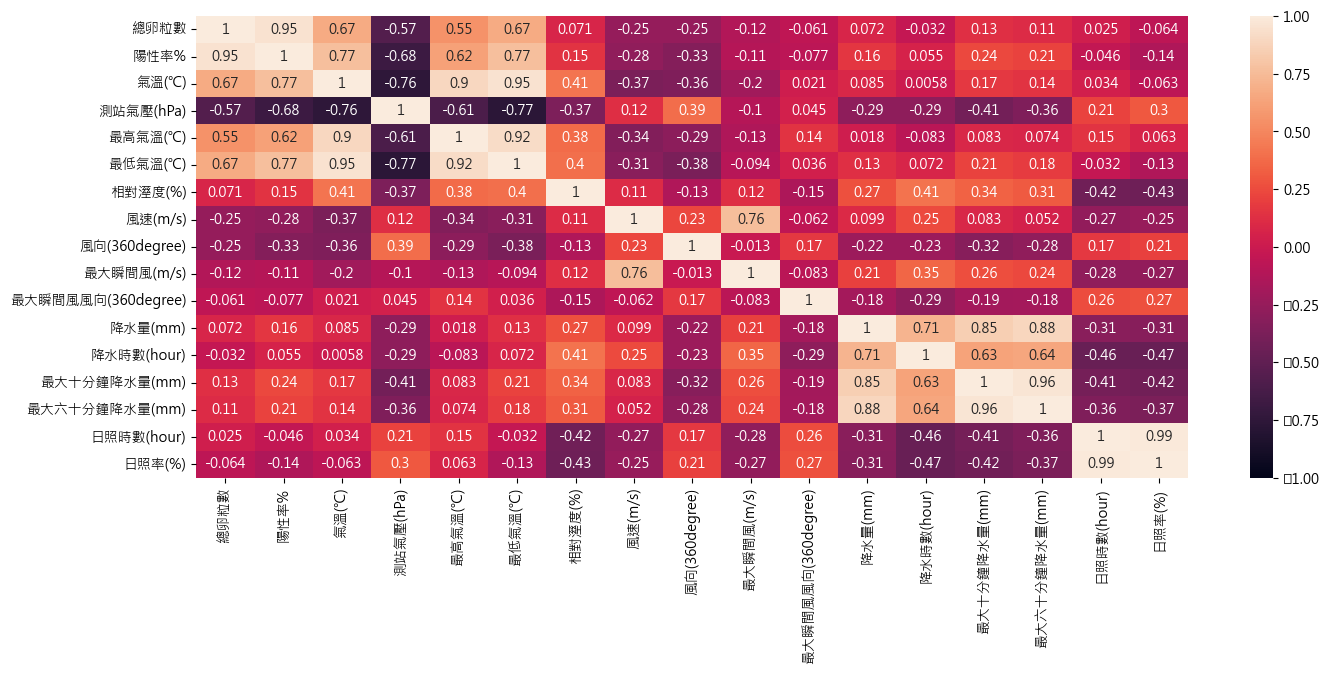

In [498]:
plt.figure(figsize=(16, 6))
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
sns.heatmap(merged_df_1.corr(),vmin=-1, vmax=1, annot=True)

In [528]:
correlation_matrix2

總卵粒數      陽性率%     氣溫(℃)  測站氣壓(hPa)   最高氣溫(℃)  \
總卵粒數                1.000000  0.945786  0.689369  -0.580675  0.605070   
陽性率%                0.945786  1.000000  0.789769  -0.705095  0.690935   
氣溫(℃)               0.689369  0.789769  1.000000  -0.809706  0.958955   
測站氣壓(hPa)          -0.580675 -0.705095 -0.809706   1.000000 -0.716103   
最高氣溫(℃)             0.605070  0.690935  0.958955  -0.716103  1.000000   
最低氣溫(℃)             0.698625  0.807105  0.981727  -0.842723  0.902718   
相對溼度(%)             0.090616  0.154875  0.336077  -0.365963  0.321043   
風速(m/s)            -0.235653 -0.250488 -0.334233   0.084491 -0.359205   
風向(360degree)      -0.337205 -0.385868 -0.359604   0.361435 -0.343819   
最大瞬間風(m/s)          0.014047  0.030867 -0.047592  -0.180173 -0.097924   
最大瞬間風風向(360degree) -0.080666 -0.126741 -0.138287   0.154978 -0.082498   
降水量(mm)             0.067870  0.156972  0.115049  -0.300257  0.040667   
降水時數(hour)          0.004472  0.085325  0.033491  -0.229002 -0.049843   
最大十分鐘降水量(mm)        0.148266  0.225768  0.162734  -0.310273  0.095007   
最大六十分鐘降水量(mm)       0.101124  0.171393  0.130457  -0.260018  0.070914   
日照時數(hour)         -0.035236 -0.108092  0.025466   0.176378  0.175645   
日照率(%)             -0.119053 -0.194279 -0.071139   0.265085  0.092197   

                     最低氣溫(℃)   相對溼度(%)   風速(m/s)  風向(360degree)  最大瞬間風(m/s)  \
總卵粒數                0.698625  0.090616 -0.235653      -0.337205    0.014047   
陽性率%                0.807105  0.154875 -0.250488      -0.385868    0.030867   
氣溫(℃)               0.981727  0.336077 -0.334233      -0.359604   -0.047592   
測站氣壓(hPa)          -0.842723 -0.365963  0.084491       0.361435   -0.180173   
最高氣溫(℃)             0.902718  0.321043 -0.359205      -0.343819   -0.097924   
最低氣溫(℃)             1.000000  0.371891 -0.295507      -0.348268   -0.020497   
相對溼度(%)             0.371891  1.000000  0.043831      -0.093456    0.138851   
風速(m/s)            -0.295507  0.043831  1.000000       0.187217    0.753604   
風向(360degree)      -0.348268 -0.093456  0.187217       1.000000   -0.004482   
最大瞬間風(m/s)         -0.020497  0.138851  0.753604      -0.004482    1.000000   
最大瞬間風風向(360degree) -0.161729 -0.235942  0.049042       0.208369   -0.005684   
降水量(mm)             0.163936  0.337622  0.081792      -0.235312    0.207876   
降水時數(hour)          0.097169  0.361853  0.129236      -0.159915    0.206442   
最大十分鐘降水量(mm)        0.202910  0.315790  0.016797      -0.280065    0.236418   
最大六十分鐘降水量(mm)       0.160864  0.279098  0.027386      -0.243171    0.209926   
日照時數(hour)         -0.080015 -0.383262 -0.172884       0.129438   -0.206001   
日照率(%)             -0.177379 -0.387258 -0.144712       0.167129   -0.210373   

                    最大瞬間風風向(360degree)   降水量(mm)  降水時數(hour)  最大十分鐘降水量(mm)  \
總卵粒數                         -0.080666  0.067870    0.004472      0.148266   
陽性率%                         -0.126741  0.156972    0.085325      0.225768   
氣溫(℃)                        -0.138287  0.115049    0.033491      0.162734   
測站氣壓(hPa)                     0.154978 -0.300257   -0.229002     -0.310273   
最高氣溫(℃)                      -0.082498  0.040667   -0.049843      0.095007   
最低氣溫(℃)                      -0.161729  0.163936    0.097169      0.202910   
相對溼度(%)                      -0.235942  0.337622    0.361853      0.315790   
風速(m/s)                       0.049042  0.081792    0.129236      0.016797   
風向(360degree)                 0.208369 -0.235312   -0.159915     -0.280065   
最大瞬間風(m/s)                   -0.005684  0.207876    0.206442      0.236418   
最大瞬間風風向(360degree)            1.000000 -0.198361   -0.231334     -0.211117   
降水量(mm)                      -0.198361  1.000000    0.820616      0.842486   
降水時數(hour)                   -0.231334  0.820616    1.000000      0.612347   
最大十分鐘降水量(mm)                 -0.211117  0.842486    0.612347      1.000000   
最大六十分鐘降水量(mm)                -0.220279  0.894475    0.659663      0.915936   
日照時數(hour)                    0.274943

In [529]:
#表現最好
correlation_matrix3

總卵粒數      陽性率%     氣溫(℃)  測站氣壓(hPa)   最高氣溫(℃)  \
總卵粒數                1.000000  0.945786  0.694729  -0.592093  0.616780   
陽性率%                0.945786  1.000000  0.788657  -0.722170  0.698907   
氣溫(℃)               0.694729  0.788657  1.000000  -0.802780  0.964504   
測站氣壓(hPa)          -0.592093 -0.722170 -0.802780   1.000000 -0.723976   
最高氣溫(℃)             0.616780  0.698907  0.964504  -0.723976  1.000000   
最低氣溫(℃)             0.698937  0.803959  0.982678  -0.822854  0.911338   
相對溼度(%)             0.041606  0.095019  0.226158  -0.257646  0.205826   
風速(m/s)            -0.294569 -0.330269 -0.442652   0.228511 -0.487462   
風向(360degree)      -0.353517 -0.423546 -0.322138   0.390429 -0.275317   
最大瞬間風(m/s)         -0.033260 -0.009769 -0.103841  -0.135781 -0.153562   
最大瞬間風風向(360degree) -0.016679 -0.037818  0.026686   0.092623  0.052730   
降水量(mm)             0.077577  0.188436  0.094738  -0.327693  0.025793   
降水時數(hour)          0.019397  0.126484  0.019222  -0.265884 -0.083545   
最大十分鐘降水量(mm)        0.127238  0.251822  0.157729  -0.383575  0.100218   
最大六十分鐘降水量(mm)       0.124268  0.244949  0.143724  -0.368096  0.080274   
日照時數(hour)          0.051046 -0.022345  0.168613   0.070759  0.304999   
日照率(%)             -0.035527 -0.112056  0.067256   0.166173  0.218466   

                     最低氣溫(℃)   相對溼度(%)   風速(m/s)  風向(360degree)  最大瞬間風(m/s)  \
總卵粒數                0.698937  0.041606 -0.294569      -0.353517   -0.033260   
陽性率%                0.803959  0.095019 -0.330269      -0.423546   -0.009769   
氣溫(℃)               0.982678  0.226158 -0.442652      -0.322138   -0.103841   
測站氣壓(hPa)          -0.822854 -0.257646  0.228511       0.390429   -0.135781   
最高氣溫(℃)             0.911338  0.205826 -0.487462      -0.275317   -0.153562   
最低氣溫(℃)             1.000000  0.272571 -0.413536      -0.330140   -0.086726   
相對溼度(%)             0.272571  1.000000 -0.207218      -0.037999   -0.174439   
風速(m/s)            -0.413536 -0.207218  1.000000       0.161213    0.778417   
風向(360degree)      -0.330140 -0.037999  0.161213       1.000000   -0.091334   
最大瞬間風(m/s)         -0.086726 -0.174439  0.778417      -0.091334    1.000000   
最大瞬間風風向(360degree) -0.005360 -0.097528 -0.166254       0.153772   -0.177926   
降水量(mm)             0.145296  0.331096  0.135289      -0.251490    0.283012   
降水時數(hour)          0.094075  0.411679  0.060267      -0.272086    0.166642   
最大十分鐘降水量(mm)        0.198582  0.304927 -0.013462      -0.286744    0.185798   
最大六十分鐘降水量(mm)       0.188927  0.333066  0.013648      -0.296268    0.207029   
日照時數(hour)          0.047263 -0.378573 -0.144720       0.135043   -0.123147   
日照率(%)             -0.055778 -0.377739 -0.119702       0.177260   -0.132676   

                    最大瞬間風風向(360degree)   降水量(mm)  降水時數(hour)  最大十分鐘降水量(mm)  \
總卵粒數                         -0.016679  0.077577    0.019397      0.127238   
陽性率%                         -0.037818  0.188436    0.126484      0.251822   
氣溫(℃)                         0.026686  0.094738    0.019222      0.157729   
測站氣壓(hPa)                     0.092623 -0.327693   -0.265884     -0.383575   
最高氣溫(℃)                       0.052730  0.025793   -0.083545      0.100218   
最低氣溫(℃)                      -0.005360  0.145296    0.094075      0.198582   
相對溼度(%)                      -0.097528  0.331096    0.411679      0.304927   
風速(m/s)                      -0.166254  0.135289    0.060267     -0.013462   
風向(360degree)                 0.153772 -0.251490   -0.272086     -0.286744   
最大瞬間風(m/s)                   -0.177926  0.283012    0.166642      0.185798   
最大瞬間風風向(360degree)            1.000000 -0.145145   -0.229256     -0.117045   
降水量(mm)                      -0.145145  1.000000    0.799706      0.786314   
降水時數(hour)                   -0.229256  0.799706    1.000000      0.578827   
最大十分鐘降水量(mm)                 -0.117045  0.786314    0.578827      1.000000   
最大六十分鐘降水量(mm)                -0.130684  0.876741    0.676520      0.951170   
日照時數(hour)                    0.162583

C:\Users\lilj\AppData\Local\Temp\ipykernel_14520\141293640.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_df_3.corr(),vmin=-1, vmax=1, annot=True)


<Axes: >

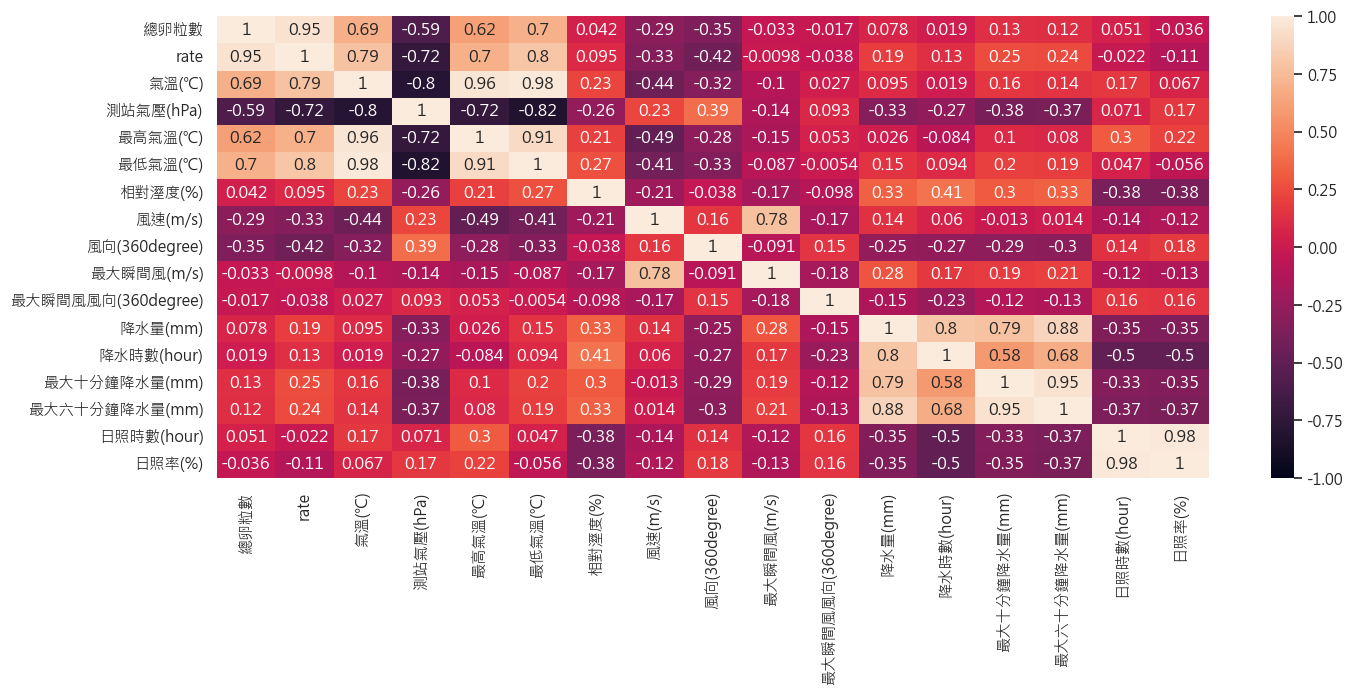

In [635]:
plt.figure(figsize=(16, 6))
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
sns.heatmap(merged_df_3.corr(),vmin=-1, vmax=1, annot=True)

In [531]:
correlation_matrix4

總卵粒數      陽性率%     氣溫(℃)  測站氣壓(hPa)   最高氣溫(℃)  \
總卵粒數                1.000000  0.945786  0.679576  -0.579979  0.613729   
陽性率%                0.945786  1.000000  0.785122  -0.707377  0.710116   
氣溫(℃)               0.679576  0.785122  1.000000  -0.755897  0.960480   
測站氣壓(hPa)          -0.579979 -0.707377 -0.755897   1.000000 -0.661643   
最高氣溫(℃)             0.613729  0.710116  0.960480  -0.661643  1.000000   
最低氣溫(℃)             0.684237  0.793943  0.984852  -0.790830  0.912764   
相對溼度(%)             0.076464  0.100160  0.204700  -0.208473  0.176833   
風速(m/s)            -0.287190 -0.338314 -0.437678   0.246364 -0.471399   
風向(360degree)      -0.325195 -0.349466 -0.354349   0.430027 -0.300248   
最大瞬間風(m/s)         -0.004312 -0.006642 -0.104068  -0.114575 -0.140854   
最大瞬間風風向(360degree)  0.008853 -0.008292  0.056287   0.053424  0.103884   
降水量(mm)             0.129073  0.154309  0.092157  -0.226997  0.053294   
降水時數(hour)          0.011136  0.059322 -0.029364  -0.236539 -0.129760   
最大十分鐘降水量(mm)        0.249669  0.259463  0.154970  -0.309465  0.123720   
最大六十分鐘降水量(mm)       0.168903  0.189848  0.125423  -0.237868  0.104220   
日照時數(hour)         -0.022191 -0.045964  0.103943   0.133518  0.243912   
日照率(%)             -0.109032 -0.143166 -0.003526   0.233632  0.149690   

                     最低氣溫(℃)   相對溼度(%)   風速(m/s)  風向(360degree)  最大瞬間風(m/s)  \
總卵粒數                0.684237  0.076464 -0.287190      -0.325195   -0.004312   
陽性率%                0.793943  0.100160 -0.338314      -0.349466   -0.006642   
氣溫(℃)               0.984852  0.204700 -0.437678      -0.354349   -0.104068   
測站氣壓(hPa)          -0.790830 -0.208473  0.246364       0.430027   -0.114575   
最高氣溫(℃)             0.912764  0.176833 -0.471399      -0.300248   -0.140854   
最低氣溫(℃)             1.000000  0.243728 -0.412309      -0.388373   -0.080707   
相對溼度(%)             0.243728  1.000000 -0.102172      -0.149368   -0.089682   
風速(m/s)            -0.412309 -0.102172  1.000000       0.163615    0.724773   
風向(360degree)      -0.388373 -0.149368  0.163615       1.000000   -0.079229   
最大瞬間風(m/s)         -0.080707 -0.089682  0.724773      -0.079229    1.000000   
最大瞬間風風向(360degree)  0.026281  0.068424 -0.107769       0.172070   -0.147424   
降水量(mm)             0.115121  0.313857 -0.095004      -0.231258    0.103350   
降水時數(hour)          0.036599  0.428327  0.064221      -0.233500    0.234182   
最大十分鐘降水量(mm)        0.172863  0.316178 -0.136502      -0.251521    0.153270   
最大六十分鐘降水量(mm)       0.135064  0.276164 -0.119953      -0.215991    0.134629   
日照時數(hour)          0.000841 -0.409243 -0.118018       0.198513   -0.108700   
日照率(%)             -0.107842 -0.401058 -0.104384       0.256484   -0.133143   

                    最大瞬間風風向(360degree)   降水量(mm)  降水時數(hour)  最大十分鐘降水量(mm)  \
總卵粒數                          0.008853  0.129073    0.011136      0.249669   
陽性率%                         -0.008292  0.154309    0.059322      0.259463   
氣溫(℃)                         0.056287  0.092157   -0.029364      0.154970   
測站氣壓(hPa)                     0.053424 -0.226997   -0.236539     -0.309465   
最高氣溫(℃)                       0.103884  0.053294   -0.129760      0.123720   
最低氣溫(℃)                       0.026281  0.115121    0.036599      0.172863   
相對溼度(%)                       0.068424  0.313857    0.428327      0.316178   
風速(m/s)                      -0.107769 -0.095004    0.064221     -0.136502   
風向(360degree)                 0.172070 -0.231258   -0.233500     -0.251521   
最大瞬間風(m/s)                   -0.147424  0.103350    0.234182      0.153270   
最大瞬間風風向(360degree)            1.000000 -0.151649   -0.194194     -0.183968   
降水量(mm)                      -0.151649  1.000000    0.634664      0.835651   
降水時數(hour)                   -0.194194  0.634664    1.000000      0.555768   
最大十分鐘降水量(mm)                 -0.183968  0.835651    0.555768      1.000000   
最大六十分鐘降水量(mm)                -0.179319  0.926211    0.554814      0.920674   
日照時數(hour)                    0.204909

In [532]:
correlation_matrix5

總卵粒數      陽性率%     氣溫(℃)  測站氣壓(hPa)   最高氣溫(℃)  \
總卵粒數                1.000000  0.945786  0.686692  -0.588957  0.615710   
陽性率%                0.945786  1.000000  0.800971  -0.721823  0.717797   
氣溫(℃)               0.686692  0.800971  1.000000  -0.810862  0.952528   
測站氣壓(hPa)          -0.588957 -0.721823 -0.810862   1.000000 -0.720144   
最高氣溫(℃)             0.615710  0.717797  0.952528  -0.720144  1.000000   
最低氣溫(℃)             0.698679  0.810220  0.977476  -0.825799  0.884646   
相對溼度(%)             0.160933  0.199391  0.092297  -0.259208 -0.042136   
風速(m/s)            -0.234069 -0.267465 -0.347047   0.159436 -0.400076   
風向(360degree)      -0.326173 -0.353506 -0.341712   0.339192 -0.335725   
最大瞬間風(m/s)          0.003342  0.015974 -0.042944  -0.139321 -0.083345   
最大瞬間風風向(360degree) -0.004985 -0.021798 -0.050800   0.131676 -0.006555   
降水量(mm)             0.252889  0.258474  0.164703  -0.300695  0.102127   
降水時數(hour)          0.175921  0.160246  0.021283  -0.212070 -0.107019   
最大十分鐘降水量(mm)        0.193540  0.270232  0.220155  -0.347831  0.173366   
最大六十分鐘降水量(mm)       0.150180  0.213468  0.183396  -0.308384  0.125441   
日照時數(hour)         -0.112974 -0.137736  0.055475   0.159250  0.237813   
日照率(%)             -0.186686 -0.221001 -0.046801   0.245927  0.144492   

                     最低氣溫(℃)   相對溼度(%)   風速(m/s)  風向(360degree)  最大瞬間風(m/s)  \
總卵粒數                0.698679  0.160933 -0.234069      -0.326173    0.003342   
陽性率%                0.810220  0.199391 -0.267465      -0.353506    0.015974   
氣溫(℃)               0.977476  0.092297 -0.347047      -0.341712   -0.042944   
測站氣壓(hPa)          -0.825799 -0.259208  0.159436       0.339192   -0.139321   
最高氣溫(℃)             0.884646 -0.042136 -0.400076      -0.335725   -0.083345   
最低氣溫(℃)             1.000000  0.203698 -0.288806      -0.333738   -0.026809   
相對溼度(%)             0.203698  1.000000  0.012550      -0.037344    0.028673   
風速(m/s)            -0.288806  0.012550  1.000000       0.241352    0.711833   
風向(360degree)      -0.333738 -0.037344  0.241352       1.000000    0.047767   
最大瞬間風(m/s)         -0.026809  0.028673  0.711833       0.047767    1.000000   
最大瞬間風風向(360degree) -0.075853 -0.196164 -0.033713       0.208325   -0.077878   
降水量(mm)             0.199093  0.410112 -0.106896      -0.163292    0.066304   
降水時數(hour)          0.103518  0.531250  0.062040      -0.061869    0.155465   
最大十分鐘降水量(mm)        0.243690  0.373982 -0.141000      -0.152895    0.112679   
最大六十分鐘降水量(mm)       0.209995  0.363636 -0.135417      -0.165918    0.065125   
日照時數(hour)         -0.078706 -0.552756 -0.097064       0.086281   -0.062088   
日照率(%)             -0.179556 -0.547704 -0.080866       0.118991   -0.079688   

                    最大瞬間風風向(360degree)   降水量(mm)  降水時數(hour)  最大十分鐘降水量(mm)  \
總卵粒數                         -0.004985  0.252889    0.175921      0.193540   
陽性率%                         -0.021798  0.258474    0.160246      0.270232   
氣溫(℃)                        -0.050800  0.164703    0.021283      0.220155   
測站氣壓(hPa)                     0.131676 -0.300695   -0.212070     -0.347831   
最高氣溫(℃)                      -0.006555  0.102127   -0.107019      0.173366   
最低氣溫(℃)                      -0.075853  0.199093    0.103518      0.243690   
相對溼度(%)                      -0.196164  0.410112    0.531250      0.373982   
風速(m/s)                      -0.033713 -0.106896    0.062040     -0.141000   
風向(360degree)                 0.208325 -0.163292   -0.061869     -0.152895   
最大瞬間風(m/s)                   -0.077878  0.066304    0.155465      0.112679   
最大瞬間風風向(360degree)            1.000000 -0.135587   -0.158222     -0.094896   
降水量(mm)                      -0.135587  1.000000    0.624689      0.860003   
降水時數(hour)                   -0.158222  0.624689    1.000000      0.468239   
最大十分鐘降水量(mm)                 -0.094896  0.860003    0.468239      1.000000   
最大六十分鐘降水量(mm)                -0.107979  0.924101    0.493473      0.937955   
日照時數(hour)                    0.185916

In [533]:
correlation_matrix6

總卵粒數      陽性率%     氣溫(℃)  測站氣壓(hPa)   最高氣溫(℃)  \
總卵粒數                1.000000  0.945786  0.655496  -0.606338  0.564827   
陽性率%                0.945786  1.000000  0.764419  -0.738040  0.655595   
氣溫(℃)               0.655496  0.764419  1.000000  -0.762682  0.961055   
測站氣壓(hPa)          -0.606338 -0.738040 -0.762682   1.000000 -0.645625   
最高氣溫(℃)             0.564827  0.655595  0.961055  -0.645625  1.000000   
最低氣溫(℃)             0.668810  0.780690  0.980973  -0.799550  0.902013   
相對溼度(%)             0.128899  0.161286  0.163697  -0.196534  0.090226   
風速(m/s)            -0.272428 -0.313959 -0.392607   0.184723 -0.421125   
風向(360degree)      -0.266460 -0.300951 -0.286945   0.278702 -0.297418   
最大瞬間風(m/s)         -0.061632 -0.076459 -0.157803  -0.071140 -0.174106   
最大瞬間風風向(360degree) -0.037815 -0.057958 -0.037123   0.091578 -0.002058   
降水量(mm)             0.104399  0.151150  0.069967  -0.309391 -0.021756   
降水時數(hour)          0.028409  0.073332 -0.090630  -0.185783 -0.221552   
最大十分鐘降水量(mm)        0.197650  0.273886  0.194569  -0.397581  0.118492   
最大六十分鐘降水量(mm)       0.173153  0.233012  0.148741  -0.358445  0.063182   
日照時數(hour)         -0.020506 -0.067512  0.105152   0.167941  0.260327   
日照率(%)             -0.105297 -0.160411  0.008173   0.257268  0.176670   

                     最低氣溫(℃)   相對溼度(%)   風速(m/s)  風向(360degree)  最大瞬間風(m/s)  \
總卵粒數                0.668810  0.128899 -0.272428      -0.266460   -0.061632   
陽性率%                0.780690  0.161286 -0.313959      -0.300951   -0.076459   
氣溫(℃)               0.980973  0.163697 -0.392607      -0.286945   -0.157803   
測站氣壓(hPa)          -0.799550 -0.196534  0.184723       0.278702   -0.071140   
最高氣溫(℃)             0.902013  0.090226 -0.421125      -0.297418   -0.174106   
最低氣溫(℃)             1.000000  0.222865 -0.355026      -0.258073   -0.154457   
相對溼度(%)             0.222865  1.000000  0.078260       0.105147    0.019640   
風速(m/s)            -0.355026  0.078260  1.000000       0.280928    0.689325   
風向(360degree)      -0.258073  0.105147  0.280928       1.000000    0.041966   
最大瞬間風(m/s)         -0.154457  0.019640  0.689325       0.041966    1.000000   
最大瞬間風風向(360degree) -0.046619 -0.089820  0.027409       0.266724   -0.091588   
降水量(mm)             0.120640  0.331270  0.002997      -0.164400    0.097529   
降水時數(hour)         -0.010827  0.445479  0.085683      -0.018436    0.124430   
最大十分鐘降水量(mm)        0.222002  0.328984 -0.085645      -0.190618    0.212473   
最大六十分鐘降水量(mm)       0.187375  0.345659 -0.068029      -0.193157    0.157236   
日照時數(hour)         -0.004911 -0.470959 -0.158536      -0.169271   -0.115539   
日照率(%)             -0.103442 -0.468849 -0.127548      -0.131061   -0.119762   

                    最大瞬間風風向(360degree)   降水量(mm)  降水時數(hour)  最大十分鐘降水量(mm)  \
總卵粒數                         -0.037815  0.104399    0.028409      0.197650   
陽性率%                         -0.057958  0.151150    0.073332      0.273886   
氣溫(℃)                        -0.037123  0.069967   -0.090630      0.194569   
測站氣壓(hPa)                     0.091578 -0.309391   -0.185783     -0.397581   
最高氣溫(℃)                      -0.002058 -0.021756   -0.221552      0.118492   
最低氣溫(℃)                      -0.046619  0.120640   -0.010827      0.222002   
相對溼度(%)                      -0.089820  0.331270    0.445479      0.328984   
風速(m/s)                       0.027409  0.002997    0.085683     -0.085645   
風向(360degree)                 0.266724 -0.164400   -0.018436     -0.190618   
最大瞬間風(m/s)                   -0.091588  0.097529    0.124430      0.212473   
最大瞬間風風向(360degree)            1.000000 -0.101895   -0.048018     -0.143636   
降水量(mm)                      -0.101895  1.000000    0.624840      0.738562   
降水時數(hour)                   -0.048018  0.624840    1.000000      0.396834   
最大十分鐘降水量(mm)                 -0.143636  0.738562    0.396834      1.000000   
最大六十分鐘降水量(mm)                -0.149834  0.881305    0.515254      0.924664   
日照時數(hour)                    0.104852

# 預測

In [584]:
merged_df_3

觀測時間(day)     總卵粒數    rate  氣溫(℃)  測站氣壓(hPa)  最高氣溫(℃)  最低氣溫(℃)  相對溼度(%)  \
0   2020-01-01   2060.0  0.1182   20.9     1017.8     25.9     18.5     79.0   
1   2020-01-08   2543.0  0.1570   20.2     1018.1     25.1     17.5     80.0   
2   2020-01-15   2775.0  0.1628   17.4     1015.5     22.6     14.0     71.0   
3   2020-01-22   1910.0  0.1105   17.6     1019.4     26.1     13.0     73.0   
4   2020-01-29   3513.0  0.1550   17.8     1012.3     22.2     14.7     74.0   
5   2020-02-05    701.0  0.0523   17.9     1019.3     24.8     13.2     73.0   
6   2020-02-12   1398.0  0.0853   18.0     1020.7     27.2     11.4     71.0   
7   2020-02-19   1598.0  0.1085    0.0     1022.0      0.0      0.0      0.0   
8   2020-02-26   2171.0  0.1202   21.3     1018.8     28.1     17.2     78.0   
9   2020-03-04   4046.0  0.1957   21.9     1015.4     27.4     18.5     73.0   
10  2020-03-11   2684.0  0.1550   25.1     1008.0     29.6     20.7     75.0   
11  2020-03-18   2301.0  0.1376   21.2     1018.4     25.9     16.7     62.0   
12  2020-03-25   1869.0  0.1240   24.8     1012.4     30.1     21.6     75.0   
13  2020-04-01   3232.0  0.2326   23.8     1011.4     29.9     19.9     72.0   
14  2020-04-08   2156.0  0.1841   18.7     1014.4     22.0     17.2     81.0   
15  2020-04-15   1795.0  0.1609   19.4     1016.0     25.9     14.5     44.0   
16  2020-04-22   4616.0  0.2674   26.6     1011.6     32.3     23.5     75.0   
17  2020-04-29   5277.0  0.2965   25.5     1014.0     31.5     21.3     66.0   
18  2020-05-06   4799.0  0.2926   28.4     1009.1     33.4     25.1     71.0   
19  2020-05-13   4130.0  0.2364   29.5     1008.3     34.6     26.7     76.0   
20  2020-05-20   1820.0  0.1860   28.2     1004.2     33.0     25.4     76.0   
21  2020-05-27   2644.0  0.2461   28.7     1008.8     33.1     25.8     75.0   
22  2020-06-03   5870.0  0.3992   29.6     1010.2     33.4     26.9     76.0   
23  2020-06-10   6213.0  0.3953   26.9     1007.8     31.8     24.1     78.0   
24  2020-06-17   6871.0  0.4070   30.2     1011.3     34.8     27.0     70.0   
25  2020-06-24  10519.0  0.5329   30.4     1006.0     34.3     27.1     72.0   
26  2020-07-01   6415.0  0.3643   30.5     1005.8     34.2     27.7     72.0   
27  2020-07-08   5133.0  0.3760   29.7     1007.3     33.2     27.3     73.0   
28  2020-07-15   9323.0  0.4845   31.4     1006.2     36.1     27.9     68.0   
29  2020-07-22   6735.0  0.4360   29.0     1009.2     34.7     26.1     73.0   
30  2020-07-29   6743.0  0.4264   30.4     1006.1     34.3     27.4     73.0   
31  2020-08-05   4726.0  0.4109   26.1     1004.6     29.3     24.7     87.0   
32  2020-08-12   7404.0  0.4516   29.2     1004.0     33.9     27.3     79.0   
33  2020-08-19   8370.0  0.4864   28.8     1006.7     33.0     25.2     78.0   
34  2020-08-26   5784.0  0.4186   28.9     1003.7     32.7     24.9     80.0   
35  2020-09-02   4854.0  0.4574   27.6     1002.4     33.3     24.5     81.0   
36  2020-09-09   7321.0  0.4690   28.0     1007.5     32.9     23.2     63.0   
37  2020-09-16   7660.0  0.4380   29.8     1008.8     34.5     26.6     77.0   
38  2020-09-23   5493.0  0.3585   29.1     1008.5     34.0     25.9     74.0   
39  2020-09-30   5591.0  0.3508   27.4     1008.8     32.7     23.6     73.0   
40  2020-10-07   7045.0  0.3682   28.9     1008.5     33.1     25.3     69.0   
41  2020-10-14   4317.0  0.3004   27.6     1007.9     31.9     25.0     79.0   
42  2020-10-21   3700.0  0.2519   25.8     1011.9     32.2     21.6     71.0   
43  2020-10-28   3627.0  0.2461   26.4     1010.6     31.9     22.9     71.0   
44  2020-11-04   3065.0  0.2190   25.0     1011.1     30.0     21.7     76.0   
45  2020-11-11   1713.0  0.1531   20.3     1014.3     22.0     18.9     83.0   
46  2020-11-18   2232.0  0.1802   24.2     1014.6     29.1     22.1     85.0   
47  2020-11-25   4773.0  0.3256   24.9     1016.3     29.8     22.4     79.0   
48  2020-12-02   5230.0  0.3043   21.3     1017.9     25.1     19.3     72.0   
49  2

# xgb - 預測全台南卵粒數

In [642]:
merged_df_3_tainan

觀測時間(day)     總卵粒數      陽性率%  氣溫(℃)  測站氣壓(hPa)  最高氣溫(℃)  最低氣溫(℃)  \
0    2020-01-01    163.0  0.083300   18.7     1016.4     19.8     17.8   
1    2020-01-01   1027.0  0.072100   18.7     1016.4     19.8     17.8   
2    2020-01-01   1200.0  0.064800   18.7     1016.4     19.8     17.8   
3    2020-01-01   2605.0  0.116000   18.7     1016.4     19.8     17.8   
4    2020-01-01    452.0  0.096200   18.7     1016.4     19.8     17.8   
5    2020-01-01    774.0  0.050500   18.7     1016.4     19.8     17.8   
6    2020-01-01    527.0  0.114600   18.7     1016.4     19.8     17.8   
7    2020-01-01    369.0  0.058300   18.7     1016.4     19.8     17.8   
8    2020-01-01   2060.0  0.118200   18.7     1016.4     19.8     17.8   
9    2020-01-08   1260.0  0.101400   19.8     1019.2     25.1     16.2   
10   2020-01-08    576.0  0.142900   19.8     1019.2     25.1     16.2   
11   2020-01-08    324.0  0.222200   19.8     1019.2     25.1     16.2   
12   2020-01-08   1250.0  0.087000   19.8     1019.2     25.1     16.2   
13   2020-01-08   4021.0  0.181400   19.8     1019.2     25.1     16.2   
14   2020-01-08   2543.0  0.157000   19.8     1019.2     25.1     16.2   
15   2020-01-08    768.0  0.075800   19.8     1019.2     25.1     16.2   
16   2020-01-08    940.0  0.161500   19.8     1019.2     25.1     16.2   
17   2020-01-08    361.0  0.050000   19.8     1019.2     25.1     16.2   
18   2020-01-08    287.0  0.109000   19.8     1019.2     25.1     16.2   
19   2020-01-15    329.0  0.107100   17.6     1013.8     22.3     14.7   
20   2020-01-15    904.0  0.291700   17.6     1013.8     22.3     14.7   
21   2020-01-15   1005.0  0.087800   17.6     1013.8     22.3     14.7   
22   2020-01-15   1002.0  0.061100   17.6     1013.8     22.3     14.7   
23   2020-01-15   3280.0  0.165000   17.6     1013.8     22.3     14.7   
24   2020-01-15    288.0  0.076900   17.6     1013.8     22.3     14.7   
25   2020-01-15   2775.0  0.162800   17.6     1013.8     22.3     14.7   
26   2020-01-15    951.0  0.073200   17.6     1013.8     22.3     14.7   
27   2020-01-15    775.0  0.099000   17.6     1013.8     22.3     14.7   
28   2020-01-15   1088.0  0.091700   17.6     1013.8     22.3     14.7   
29   2020-01-22    308.0  0.095200   16.9     1018.5     24.6     11.9   
30   2020-01-22    228.0  0.111100   16.9     1018.5     24.6     11.9   
31   2020-01-22    976.0  0.076600   16.9     1018.5     24.6     11.9   
32   2020-01-22   1017.0  0.057400   16.9     1018.5     24.6     11.9   
33   2020-01-22   1884.0  0.099700   16.9     1018.5     24.6     11.9   
34   2020-01-22    549.0  0.048000   16.9     1018.5     24.6     11.9   
35   2020-01-22   1910.0  0.110500   16.9     1018.5     24.6     11.9   
36   2020-01-22    538.0  0.119800   16.9     1018.5     24.6     11.9   
37   2020-01-22    702.0  0.083300   16.9     1018.5     24.6     11.9   
38   2020-01-22     74.0  0.038500   16.9     1018.5     24.6     11.9   
39   2020-01-29   1539.0  0.096300   18.8     1010.1     26.4     15.7   
40   2020-01-29    650.0  0.208300   18.8     1010.1     26.4     15.7   
41   2020-01-29   1823.0  0.119400   18.8     1010.1     26.4     15.7   
42   2020-01-29   3480.0  0.174800   18.8     1010.1     26.4     15.7   
43   2020-01-29     57.0  0.035700   18.8     1010.1     26.4     15.7   
44   2020-01-29   3513.0  0.155000   18.8     1010.1     26.4     15.7   
45   2020-01-29   1048.0  0.113600   18.8     1010.1     26.4     15.7   
46   2020-01-29    869.0  0.177100   18.8     1010.1     26.4     15.7   
47   2020-01-29    740.0  0.091700   18.8     1010.1     26.4     15.7   
48   2020-01-29    319.0  0.102600   18.8     1010.1     26.4     15.7   
49   2020-02-05    190.0  0.125000   17.0     1020.9     24.1     11.6   
50   2020-02-05    598.0  0.042800   17.0     1020.9     24.1     11.6   
51   2020-02-05     56.0  0.035700   17.0     1020.9     24.1     11.6   
52   2020-02-05   1707.0  0.099700   17.0     1020.9     24.1     11.6   
53   2020-

In [652]:
df_dengue_input = merged_df_3_tainan.copy()

In [655]:
train_data = df_dengue_input[df_dengue_input['觀測時間(day)'] <= '2023-12-31']
val_data = df_dengue_input[df_dengue_input['觀測時間(day)'] > '2023-12-31']

train_x = train_data.drop(columns=['觀測時間(day)', '陽性率%'])
train_y = train_data['總卵粒數']
val_x = val_data.drop(columns=['陽性率%', '觀測時間(day)'])
val_y = val_data['總卵粒數']

scaler = MinMaxScaler()
train_x_scale = scaler.fit_transform(train_x)
val_x_scale = scaler.transform(val_x)

dtrain = xgb.DMatrix(train_x_scale, label = train_y)
dvalid = xgb.DMatrix(val_x_scale, label = val_y)

max_evals = 100
trials = Trials()
history = []
fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals)
history = sorted(history, key=lambda tpl: tpl[1])
print(f'best params:{history[0][0]}, score:{history[0][1]:.4f}')

100%|██████████| 100/100 [00:09<00:00, 10.30trial/s, best loss: 6.988501202963956]
best params:{'booster': 'gbtree', 'objective': 'reg:squarederror', 'eta': 0.1, 'gamma': 7.385063695654477e-05, 'alpha': 0.0, 'lambda': 1.0, 'min_child_weight': 5.568294916539432, 'max_depth': 9, 'subsample': 0.9, 'colsample_bytree': 0.9500000000000001, 'random_state': 32}, score:6.9885


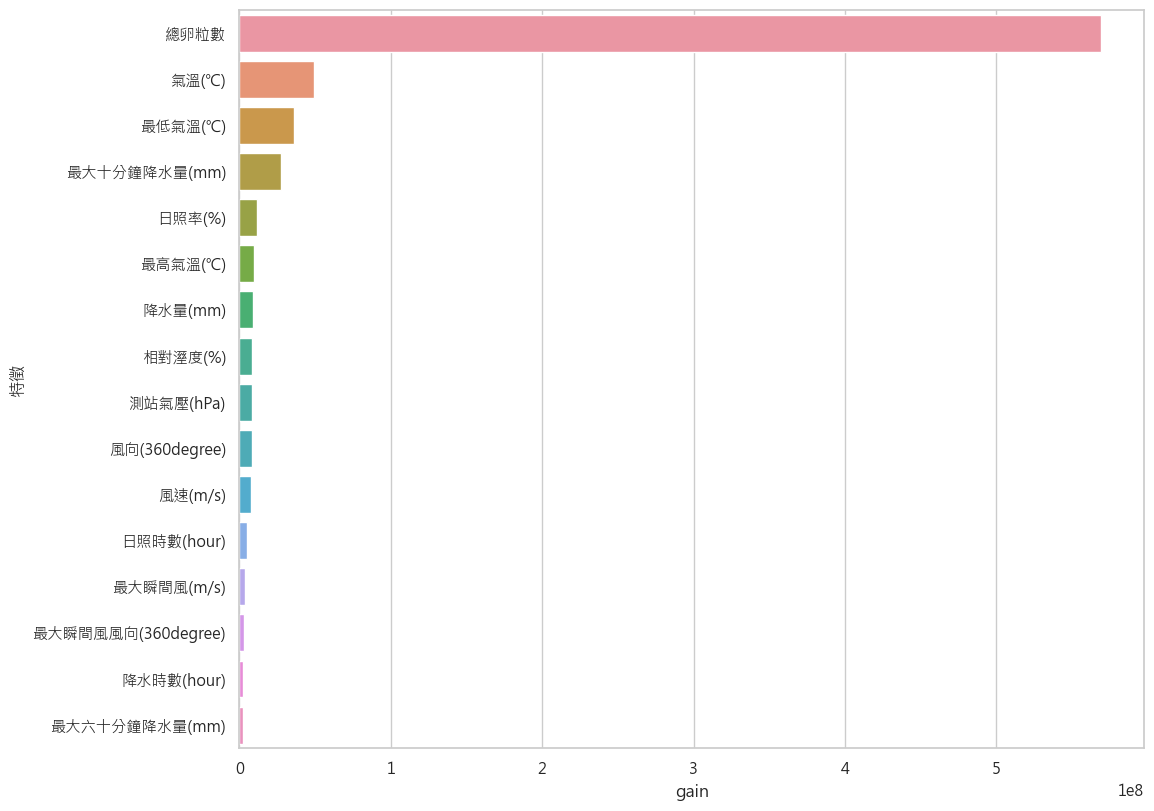

In [657]:
fi = {}
for index, col in enumerate(train_x.columns):
    fi_sum = 0
    for i in range(100):
        fi_sum += history[i][2].get(f'f{index}', 0)
    fi[col] = fi_sum/10

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
#plt.rcParams[".30................3.3figure.figsize"] = (11.7,8.27)
plt.rcParams['figure.figsize'] = (11.7, 8.27)

sns.set(font=['sans-serif'])
sns.set_style("whitegrid", {"font.sans-serif": ['Microsoft JhengHei']})
sns.barplot(data=pd.DataFrame({'特徵': list(fi.keys()), 'gain': list(fi.values())}).sort_values(['gain'], ascending=False), x='gain', y='特徵')
plt.tight_layout()
plt.show()

In [678]:
train_data = df_dengue_input[df_dengue_input['觀測時間(day)'] <= '2023-06-30']
val_data = df_dengue_input[df_dengue_input['觀測時間(day)'] > '2023-06-30']

train_x = train_data.drop(columns=['觀測時間(day)', '陽性率%','總卵粒數'])
train_y = train_data['總卵粒數']
val_x = val_data.drop(columns=['陽性率%', '觀測時間(day)','總卵粒數'])
val_y = val_data['總卵粒數']

scaler = MinMaxScaler()
train_x_scale = scaler.fit_transform(train_x)
val_x_scale = scaler.transform(val_x)

dtrain = xgb.DMatrix(train_x_scale, label = train_y)
dvalid = xgb.DMatrix(val_x_scale, label = val_y)

max_evals = 100
trials = Trials()
history = []
fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals)
history = sorted(history, key=lambda tpl: tpl[1])
print(f'best params:{history[0][0]}, score:{history[0][1]:.4f}')

100%|██████████| 100/100 [00:03<00:00, 29.22trial/s, best loss: 2092.7291011049083]
best params:{'booster': 'gbtree', 'objective': 'reg:squarederror', 'eta': 0.1, 'gamma': 0.00040181542809509125, 'alpha': 0.0, 'lambda': 1.0, 'min_child_weight': 0.24432762147925283, 'max_depth': 3, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.8500000000000001, 'random_state': 32}, score:2092.7291


In [ ]:
fi = {}
for index, col in enumerate(train_x.columns):
    fi_sum = 0
    for i in range(100):
        fi_sum += history[i][2].get(f'f{index}', 0)
    fi[col] = fi_sum/10

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
#plt.rcParams[".30................3.3figure.figsize"] = (11.7,8.27)
plt.rcParams['figure.figsize'] = (11.7, 8.27)

sns.set(font=['sans-serif'])
sns.set_style("whitegrid", {"font.sans-serif": ['Microsoft JhengHei']})
sns.barplot(data=pd.DataFrame({'特徵': list(fi.keys()), 'gain': list(fi.values())}).sort_values(['gain'], ascending=False), x='gain', y='特徵')
plt.tight_layout()
plt.show()

#linear

In [622]:
df_dengue_input_tainan

觀測時間(day)     總卵粒數      陽性率%  氣溫(℃)  測站氣壓(hPa)  最高氣溫(℃)  最低氣溫(℃)  \
0    2020-01-01    163.0  0.083300   18.7     1016.4     19.8     17.8   
1    2020-01-01   1027.0  0.072100   18.7     1016.4     19.8     17.8   
2    2020-01-01   1200.0  0.064800   18.7     1016.4     19.8     17.8   
3    2020-01-01   2605.0  0.116000   18.7     1016.4     19.8     17.8   
4    2020-01-01    452.0  0.096200   18.7     1016.4     19.8     17.8   
5    2020-01-01    774.0  0.050500   18.7     1016.4     19.8     17.8   
6    2020-01-01    527.0  0.114600   18.7     1016.4     19.8     17.8   
7    2020-01-01    369.0  0.058300   18.7     1016.4     19.8     17.8   
8    2020-01-01   2060.0  0.118200   18.7     1016.4     19.8     17.8   
9    2020-01-08   1260.0  0.101400   19.8     1019.2     25.1     16.2   
10   2020-01-08    576.0  0.142900   19.8     1019.2     25.1     16.2   
11   2020-01-08    324.0  0.222200   19.8     1019.2     25.1     16.2   
12   2020-01-08   1250.0  0.087000   19.8     1019.2     25.1     16.2   
13   2020-01-08   4021.0  0.181400   19.8     1019.2     25.1     16.2   
14   2020-01-08   2543.0  0.157000   19.8     1019.2     25.1     16.2   
15   2020-01-08    768.0  0.075800   19.8     1019.2     25.1     16.2   
16   2020-01-08    940.0  0.161500   19.8     1019.2     25.1     16.2   
17   2020-01-08    361.0  0.050000   19.8     1019.2     25.1     16.2   
18   2020-01-08    287.0  0.109000   19.8     1019.2     25.1     16.2   
19   2020-01-15    329.0  0.107100   17.6     1013.8     22.3     14.7   
20   2020-01-15    904.0  0.291700   17.6     1013.8     22.3     14.7   
21   2020-01-15   1005.0  0.087800   17.6     1013.8     22.3     14.7   
22   2020-01-15   1002.0  0.061100   17.6     1013.8     22.3     14.7   
23   2020-01-15   3280.0  0.165000   17.6     1013.8     22.3     14.7   
24   2020-01-15    288.0  0.076900   17.6     1013.8     22.3     14.7   
25   2020-01-15   2775.0  0.162800   17.6     1013.8     22.3     14.7   
26   2020-01-15    951.0  0.073200   17.6     1013.8     22.3     14.7   
27   2020-01-15    775.0  0.099000   17.6     1013.8     22.3     14.7   
28   2020-01-15   1088.0  0.091700   17.6     1013.8     22.3     14.7   
29   2020-01-22    308.0  0.095200   16.9     1018.5     24.6     11.9   
30   2020-01-22    228.0  0.111100   16.9     1018.5     24.6     11.9   
31   2020-01-22    976.0  0.076600   16.9     1018.5     24.6     11.9   
32   2020-01-22   1017.0  0.057400   16.9     1018.5     24.6     11.9   
33   2020-01-22   1884.0  0.099700   16.9     1018.5     24.6     11.9   
34   2020-01-22    549.0  0.048000   16.9     1018.5     24.6     11.9   
35   2020-01-22   1910.0  0.110500   16.9     1018.5     24.6     11.9   
36   2020-01-22    538.0  0.119800   16.9     1018.5     24.6     11.9   
37   2020-01-22    702.0  0.083300   16.9     1018.5     24.6     11.9   
38   2020-01-22     74.0  0.038500   16.9     1018.5     24.6     11.9   
39   2020-01-29   1539.0  0.096300   18.8     1010.1     26.4     15.7   
40   2020-01-29    650.0  0.208300   18.8     1010.1     26.4     15.7   
41   2020-01-29   1823.0  0.119400   18.8     1010.1     26.4     15.7   
42   2020-01-29   3480.0  0.174800   18.8     1010.1     26.4     15.7   
43   2020-01-29     57.0  0.035700   18.8     1010.1     26.4     15.7   
44   2020-01-29   3513.0  0.155000   18.8     1010.1     26.4     15.7   
45   2020-01-29   1048.0  0.113600   18.8     1010.1     26.4     15.7   
46   2020-01-29    869.0  0.177100   18.8     1010.1     26.4     15.7   
47   2020-01-29    740.0  0.091700   18.8     1010.1     26.4     15.7   
48   2020-01-29    319.0  0.102600   18.8     1010.1     26.4     15.7   
49   2020-02-05    190.0  0.125000   17.0     1020.9     24.1     11.6   
50   2020-02-05    598.0  0.042800   17.0     1020.9     24.1     11.6   
51   2020-02-05     56.0  0.035700   17.0     1020.9     24.1     11.6   
52   2020-02-05   1707.0  0.099700   17.0     1020.9     24.1     11.6   
53   2020-

In [677]:
df_dengue_input_tainan = merged_df_3_tainan.copy()

train_data = df_dengue_input_tainan[df_dengue_input_tainan['觀測時間(day)'] <= '2023-04-30']
val_data= df_dengue_input_tainan[df_dengue_input_tainan['觀測時間(day)'] > '2023-04-30']

train_x = train_data.drop(columns=['觀測時間(day)' , '陽性率%' , '總卵粒數'])
train_y = train_data['總卵粒數']
val_x = val_data.drop(columns=['觀測時間(day)', '陽性率%', '總卵粒數'])
val_y = val_data['總卵粒數']


scaler = MinMaxScaler()
train_x_scale = scaler.fit_transform(train_x)
val_x_scale = scaler.transform(val_x)


reg = LinearRegression().fit(train_x_scale, train_y)
pred = reg.predict(val_x_scale)
print(mean_squared_error(val_y, pred, squared=False))

2385.3193224609076


# 預測卵粒數

In [585]:
df_dengue_input = merged_df_3.copy()

In [586]:
train_data = df_dengue_input[df_dengue_input['觀測時間(day)'] <= '2023-12-31']
val_data = df_dengue_input[df_dengue_input['觀測時間(day)'] > '2023-12-31']

train_x = train_data.drop(columns=['觀測時間(day)' , 'rate'])
train_y = train_data['總卵粒數']
val_x = val_data.drop(columns=['觀測時間(day)', 'rate'])
val_y = val_data['總卵粒數']


In [587]:
scaler = MinMaxScaler()
train_x_scale = scaler.fit_transform(train_x)
val_x_scale = scaler.transform(val_x)

dtrain = xgb.DMatrix(train_x_scale, label = train_y)
dvalid = xgb.DMatrix(val_x_scale, label = val_y)

max_evals = 100
trials = Trials()
history = []
fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals)
history = sorted(history, key=lambda tpl: tpl[1])
print(f'best params:{history[0][0]}, score:{history[0][1]:.4f}')

100%|██████████| 100/100 [00:04<00:00, 20.05trial/s, best loss: 22.233339649690222]
best params:{'booster': 'gbtree', 'objective': 'reg:squarederror', 'eta': 0.1, 'gamma': 1.8721829904510387e-05, 'alpha': 0.0, 'lambda': 1.0, 'min_child_weight': 1.366099046340292, 'max_depth': 4, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.9500000000000001, 'random_state': 32}, score:22.2333


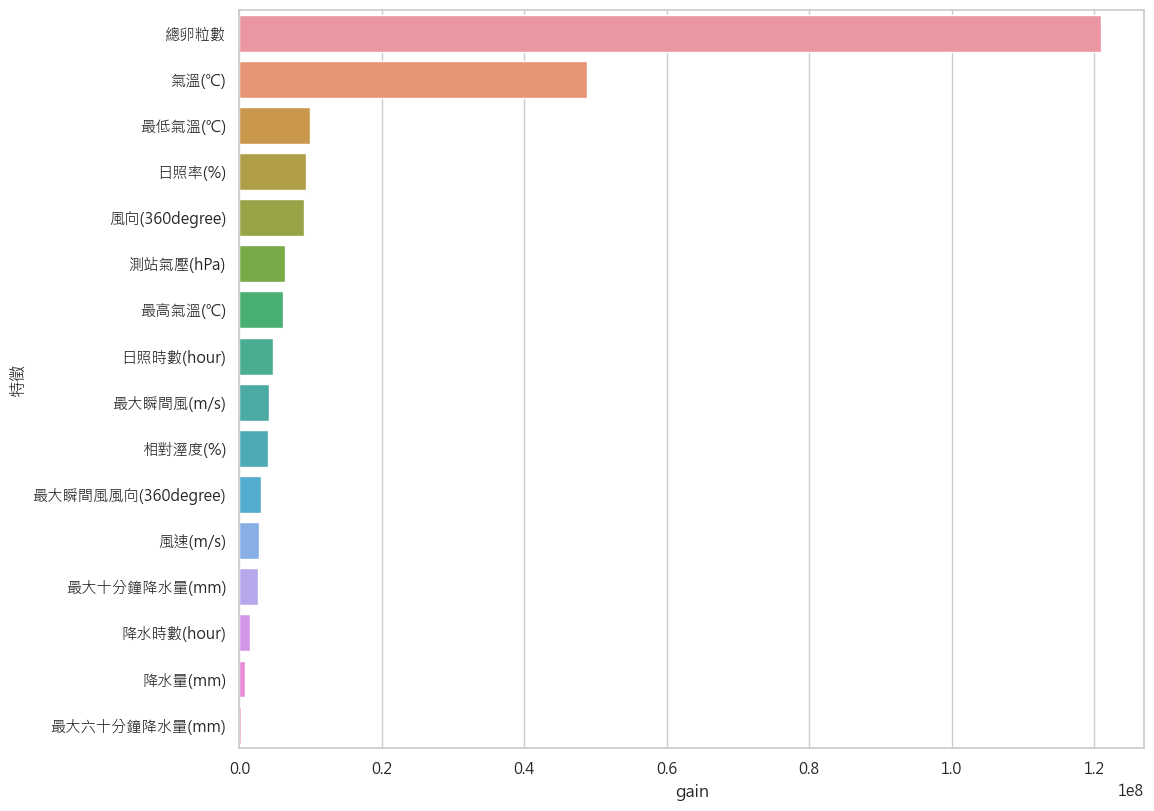

In [598]:
fi = {}
for index, col in enumerate(train_x.columns):
    fi_sum = 0
    for i in range(100):
        fi_sum += history[i][2].get(f'f{index}', 0)
    fi[col] = fi_sum/10

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
#plt.rcParams[".30................3.3figure.figsize"] = (11.7,8.27)
plt.rcParams['figure.figsize'] = (11.7, 8.27)

sns.set(font=['sans-serif'])
sns.set_style("whitegrid", {"font.sans-serif": ['Microsoft JhengHei']})
sns.barplot(data=pd.DataFrame({'特徵': list(fi.keys()), 'gain': list(fi.values())}).sort_values(['gain'], ascending=False), x='gain', y='特徵')
plt.tight_layout()
plt.show()

In [639]:
df_dengue_input = merged_df_3.copy()

train_data = df_dengue_input_tainan[df_dengue_input_tainan['觀測時間(day)'] <= '2022-12-31']
val_data= df_dengue_input_tainan[df_dengue_input_tainan['觀測時間(day)'] > '2022-12-31']

train_x = train_data.drop(columns=['觀測時間(day)' , '陽性率%'])
train_y = train_data['總卵粒數']
val_x = val_data.drop(columns=['觀測時間(day)', '陽性率%'])
val_y = val_data['總卵粒數']


scaler = MinMaxScaler()
train_x_scale = scaler.fit_transform(train_x)
val_x_scale = scaler.transform(val_x)


reg = LinearRegression().fit(train_x_scale, train_y)
pred = reg.predict(val_x_scale)
print(mean_squared_error(val_y, pred, squared=False))

2.7633002930409823e-12


# 預測陽性率

In [604]:
df_dengue_input_rate = merged_df_3.copy()

train_data_rate = df_dengue_input_rate[df_dengue_input_rate['觀測時間(day)'] <= '2023-12-31']
val_data_rate = df_dengue_input_rate[df_dengue_input_rate['觀測時間(day)'] > '2023-12-31']

train_x_ = train_data_rate.drop(columns=['觀測時間(day)' , '總卵粒數'])
train_y_ = train_data_rate['rate']
val_x_ = val_data_rate.drop(columns=['觀測時間(day)', '總卵粒數'])
val_y_ = val_data_rate['rate']

scaler = MinMaxScaler()
train_x_scale_ = scaler.fit_transform(train_x_)
val_x_scale_ = scaler.transform(val_x_)

dtrain_ = xgb.DMatrix(train_x_scale_, label = train_y_)
dvalid_ = xgb.DMatrix(val_x_scale_, label = val_y_)

max_evals = 100
trials = Trials()
history = []
fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals)
history = sorted(history, key=lambda tpl: tpl[1])
print(f'best params:{history[0][0]}, score:{history[0][1]:.4f}')


100%|██████████| 100/100 [00:05<00:00, 18.43trial/s, best loss: 22.946046641415062]
best params:{'booster': 'gbtree', 'objective': 'reg:squarederror', 'eta': 0.1, 'gamma': 4.4969862270273557e-08, 'alpha': 0.0, 'lambda': 1.0, 'min_child_weight': 0.353315140585943, 'max_depth': 4, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.9500000000000001, 'random_state': 32}, score:22.9460


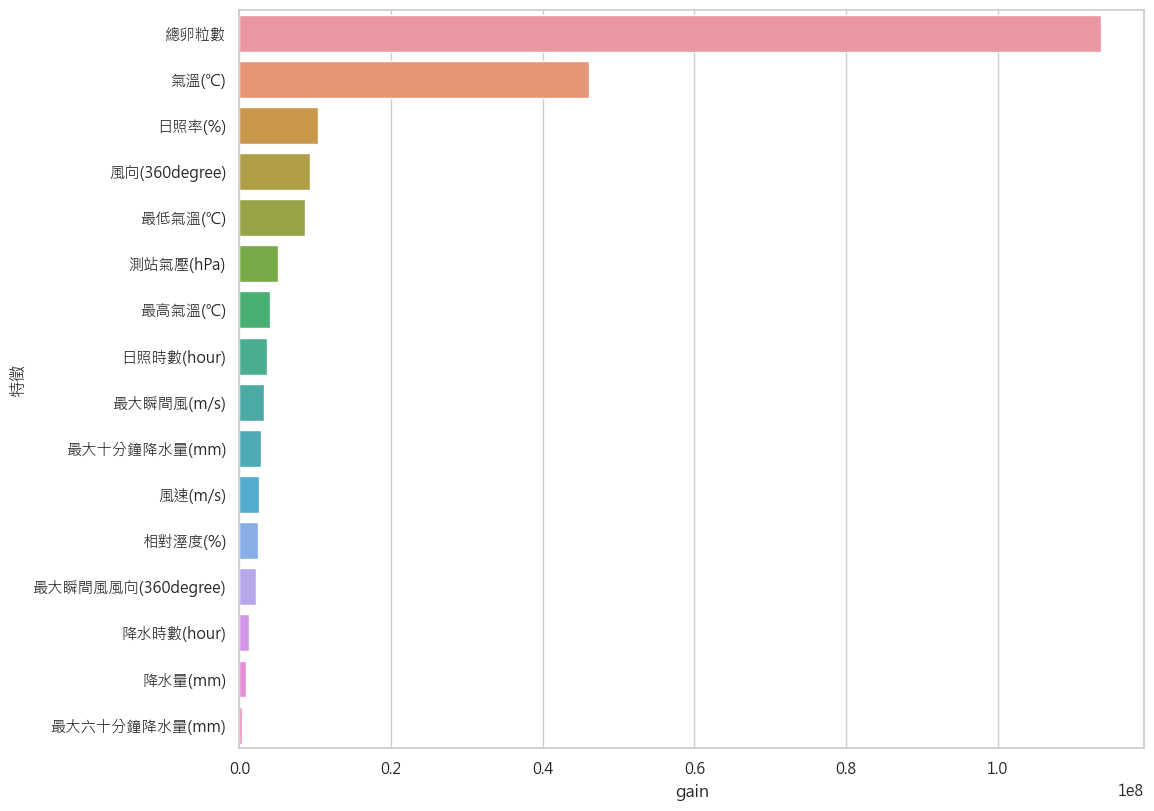

In [605]:
fi = {}
for index, col in enumerate(train_x.columns):
    fi_sum = 0
    for i in range(100):
        fi_sum += history[i][2].get(f'f{index}', 0)
    fi[col] = fi_sum/10

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
#plt.rcParams[".30................3.3figure.figsize"] = (11.7,8.27)
plt.rcParams['figure.figsize'] = (11.7, 8.27)

sns.set(font=['sans-serif'])
sns.set_style("whitegrid", {"font.sans-serif": ['Microsoft JhengHei']})
sns.barplot(data=pd.DataFrame({'特徵': list(fi.keys()), 'gain': list(fi.values())}).sort_values(['gain'], ascending=False), x='gain', y='特徵')
plt.tight_layout()
plt.show()

#只留氣溫feature

In [562]:
selected_data_ = merged_df_3[['觀測時間(day)', '總卵粒數', '氣溫(℃)', '最低氣溫(℃)']]

In [563]:
selected_data_

觀測時間(day)     總卵粒數  氣溫(℃)  最低氣溫(℃)
0   2020-01-01   2060.0   20.9     18.5
1   2020-01-08   2543.0   20.2     17.5
2   2020-01-15   2775.0   17.4     14.0
3   2020-01-22   1910.0   17.6     13.0
4   2020-01-29   3513.0   17.8     14.7
5   2020-02-05    701.0   17.9     13.2
6   2020-02-12   1398.0   18.0     11.4
7   2020-02-19   1598.0    0.0      0.0
8   2020-02-26   2171.0   21.3     17.2
9   2020-03-04   4046.0   21.9     18.5
10  2020-03-11   2684.0   25.1     20.7
11  2020-03-18   2301.0   21.2     16.7
12  2020-03-25   1869.0   24.8     21.6
13  2020-04-01   3232.0   23.8     19.9
14  2020-04-08   2156.0   18.7     17.2
15  2020-04-15   1795.0   19.4     14.5
16  2020-04-22   4616.0   26.6     23.5
17  2020-04-29   5277.0   25.5     21.3
18  2020-05-06   4799.0   28.4     25.1
19  2020-05-13   4130.0   29.5     26.7
20  2020-05-20   1820.0   28.2     25.4
21  2020-05-27   2644.0   28.7     25.8
22  2020-06-03   5870.0   29.6     26.9
23  2020-06-10   6213.0   26.9     24.1
24  2020-06-17   6871.0   30.2     27.0
25  2020-06-24  10519.0   30.4     27.1
26  2020-07-01   6415.0   30.5     27.7
27  2020-07-08   5133.0   29.7     27.3
28  2020-07-15   9323.0   31.4     27.9
29  2020-07-22   6735.0   29.0     26.1
30  2020-07-29   6743.0   30.4     27.4
31  2020-08-05   4726.0   26.1     24.7
32  2020-08-12   7404.0   29.2     27.3
33  2020-08-19   8370.0   28.8     25.2
34  2020-08-26   5784.0   28.9     24.9
35  2020-09-02   4854.0   27.6     24.5
36  2020-09-09   7321.0   28.0     23.2
37  2020-09-16   7660.0   29.8     26.6
38  2020-09-23   5493.0   29.1     25.9
39  2020-09-30   5591.0   27.4     23.6
40  2020-10-07   7045.0   28.9     25.3
41  2020-10-14   4317.0   27.6     25.0
42  2020-10-21   3700.0   25.8     21.6
43  2020-10-28   3627.0   26.4     22.9
44  2020-11-04   3065.0   25.0     21.7
45  2020-11-11   1713.0   20.3     18.9
46  2020-11-18   2232.0   24.2     22.1
47  2020-11-25   4773.0   24.9     22.4
48  2020-12-02   5230.0   21.3     19.3
49  2020-12-09   2705.0   22.0     19.6
50  2020-12-16   2228.0   20.0     16.6
51  2020-12-23   1342.0   17.2     16.3
52  2020-12-30   1365.0   21.4     18.0
53  2021-01-01   1407.0   15.8     11.8
54  2021-01-08    268.0   17.7     15.6
55  2021-01-15    631.0   14.2      8.0
56  2021-01-22    678.0   17.9     14.0
57  2021-01-29    776.0   18.3     15.6
58  2021-02-05    764.0   18.3     14.3
59  2021-02-12   1507.0   19.2     17.3
60  2021-02-19    896.0   18.7     15.0
61  2021-02-26   1771.0   21.2     18.6
62  2021-03-05   3615.0   18.9     15.7
63  2021-03-12   3437.0   21.0     17.3
64  2021-03-19   1945.0   25.1     20.7
65  2021-03-26   1211.0   19.0     17.2
66  2021-04-02   3648.0   26.7     24.2
67  2021-04-09   4741.0   22.5     19.0
68  2021-04-16   3769.0   25.2     21.6
69  2021-04-23   2370.0   26.3     23.3
70  2021-04-30   2417.0   25.3     22.0
71  2021-05-07   7119.0   27.8     23.3
72  2021-05-14   6104.0   29.9     25.9
73  2021-05-21   3407.0   30.5     27.7
74  2021-05-28   2577.0   30.6     27.8
75  2021-06-04   2137.0   30.3     27.0
76  2021-06-11   8578.0   29.0     26.1
77  2021-06-18   5474.0   28.8     27.2
78  2021-06-25   7543.0   26.4     24.5
79  2021-07-02  19211.0   29.0     25.4
80  2021-07-09  12982.0   30.4     27.7
81  2021-07-16   9346.0   29.1     25.5
82  2021-07-23   8195.0   29.2     25.9
83  2021-07-30   5434.0   29.1     25.8
84  2021-08-06   3977.0   27.1     25.8
85  2021-08-13  10813.0   28.7     25.9
86  2021-08-20  12728.0   29.2     27.2
87  2021-08-27   7686.0   29.6     27.1
88  2021-09-03   6416.0   29.3     27.4
89  2021-09-10   6660.0   30.1     27.2
90  2021-09-17   7839.0   29.1     26.3
91  2021-09-24   6123.0   29.8     26.3
92  2021-10-01   6629.0   29.9     28.1
93  2021-10-08   6083.0   29.7     26.5
94  2021-10-15   5541.0   26.2     25.1
95  2021-10-22   6777.0   26.5     22.9
96  2021-10-29   6305.0   25.9     22.4
97  2021-11-05   5006.0   25.8     22.3
98  2021-11-12   2649.0   20.6     17.8
99  2

In [564]:
df_dengue_input = selected_data_.copy()

In [565]:
param_space = {
    'min_child_weight': hp.loguniform('min_child_weight', np.log(0.1), np.log(10)),
    'max_depth': hp.quniform('max_depth', 3, 9, 1),
    'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
    'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
}

def score(space):
    params = {
        'booster': 'gbtree',
        'objective': 'reg:squarederror',
        'eta': 0.1,
        'gamma': space['gamma'],
        'alpha': 0.0,
        'lambda': 1.0,
        'min_child_weight': space['min_child_weight'],
        'max_depth': int(space['max_depth']),
        'subsample': space['subsample'],
        'colsample_bytree': space['colsample_bytree'],
        'random_state': 32
    }
    model = xgb.train(params, dtrain, num_boost_round=1000, verbose_eval=False, early_stopping_rounds=10, evals=[(dtrain, 'train'), (dvalid, 'eval')])
    pred = model.predict(dvalid)
    score = mean_squared_error(val_y, pred, squared=False)
    history.append((params, score, model.get_score(importance_type='gain')))
    return {'loss': score, 'status': STATUS_OK}

In [566]:
df_dengue_input

觀測時間(day)     總卵粒數  氣溫(℃)  最低氣溫(℃)
0   2020-01-01   2060.0   20.9     18.5
1   2020-01-08   2543.0   20.2     17.5
2   2020-01-15   2775.0   17.4     14.0
3   2020-01-22   1910.0   17.6     13.0
4   2020-01-29   3513.0   17.8     14.7
5   2020-02-05    701.0   17.9     13.2
6   2020-02-12   1398.0   18.0     11.4
7   2020-02-19   1598.0    0.0      0.0
8   2020-02-26   2171.0   21.3     17.2
9   2020-03-04   4046.0   21.9     18.5
10  2020-03-11   2684.0   25.1     20.7
11  2020-03-18   2301.0   21.2     16.7
12  2020-03-25   1869.0   24.8     21.6
13  2020-04-01   3232.0   23.8     19.9
14  2020-04-08   2156.0   18.7     17.2
15  2020-04-15   1795.0   19.4     14.5
16  2020-04-22   4616.0   26.6     23.5
17  2020-04-29   5277.0   25.5     21.3
18  2020-05-06   4799.0   28.4     25.1
19  2020-05-13   4130.0   29.5     26.7
20  2020-05-20   1820.0   28.2     25.4
21  2020-05-27   2644.0   28.7     25.8
22  2020-06-03   5870.0   29.6     26.9
23  2020-06-10   6213.0   26.9     24.1
24  2020-06-17   6871.0   30.2     27.0
25  2020-06-24  10519.0   30.4     27.1
26  2020-07-01   6415.0   30.5     27.7
27  2020-07-08   5133.0   29.7     27.3
28  2020-07-15   9323.0   31.4     27.9
29  2020-07-22   6735.0   29.0     26.1
30  2020-07-29   6743.0   30.4     27.4
31  2020-08-05   4726.0   26.1     24.7
32  2020-08-12   7404.0   29.2     27.3
33  2020-08-19   8370.0   28.8     25.2
34  2020-08-26   5784.0   28.9     24.9
35  2020-09-02   4854.0   27.6     24.5
36  2020-09-09   7321.0   28.0     23.2
37  2020-09-16   7660.0   29.8     26.6
38  2020-09-23   5493.0   29.1     25.9
39  2020-09-30   5591.0   27.4     23.6
40  2020-10-07   7045.0   28.9     25.3
41  2020-10-14   4317.0   27.6     25.0
42  2020-10-21   3700.0   25.8     21.6
43  2020-10-28   3627.0   26.4     22.9
44  2020-11-04   3065.0   25.0     21.7
45  2020-11-11   1713.0   20.3     18.9
46  2020-11-18   2232.0   24.2     22.1
47  2020-11-25   4773.0   24.9     22.4
48  2020-12-02   5230.0   21.3     19.3
49  2020-12-09   2705.0   22.0     19.6
50  2020-12-16   2228.0   20.0     16.6
51  2020-12-23   1342.0   17.2     16.3
52  2020-12-30   1365.0   21.4     18.0
53  2021-01-01   1407.0   15.8     11.8
54  2021-01-08    268.0   17.7     15.6
55  2021-01-15    631.0   14.2      8.0
56  2021-01-22    678.0   17.9     14.0
57  2021-01-29    776.0   18.3     15.6
58  2021-02-05    764.0   18.3     14.3
59  2021-02-12   1507.0   19.2     17.3
60  2021-02-19    896.0   18.7     15.0
61  2021-02-26   1771.0   21.2     18.6
62  2021-03-05   3615.0   18.9     15.7
63  2021-03-12   3437.0   21.0     17.3
64  2021-03-19   1945.0   25.1     20.7
65  2021-03-26   1211.0   19.0     17.2
66  2021-04-02   3648.0   26.7     24.2
67  2021-04-09   4741.0   22.5     19.0
68  2021-04-16   3769.0   25.2     21.6
69  2021-04-23   2370.0   26.3     23.3
70  2021-04-30   2417.0   25.3     22.0
71  2021-05-07   7119.0   27.8     23.3
72  2021-05-14   6104.0   29.9     25.9
73  2021-05-21   3407.0   30.5     27.7
74  2021-05-28   2577.0   30.6     27.8
75  2021-06-04   2137.0   30.3     27.0
76  2021-06-11   8578.0   29.0     26.1
77  2021-06-18   5474.0   28.8     27.2
78  2021-06-25   7543.0   26.4     24.5
79  2021-07-02  19211.0   29.0     25.4
80  2021-07-09  12982.0   30.4     27.7
81  2021-07-16   9346.0   29.1     25.5
82  2021-07-23   8195.0   29.2     25.9
83  2021-07-30   5434.0   29.1     25.8
84  2021-08-06   3977.0   27.1     25.8
85  2021-08-13  10813.0   28.7     25.9
86  2021-08-20  12728.0   29.2     27.2
87  2021-08-27   7686.0   29.6     27.1
88  2021-09-03   6416.0   29.3     27.4
89  2021-09-10   6660.0   30.1     27.2
90  2021-09-17   7839.0   29.1     26.3
91  2021-09-24   6123.0   29.8     26.3
92  2021-10-01   6629.0   29.9     28.1
93  2021-10-08   6083.0   29.7     26.5
94  2021-10-15   5541.0   26.2     25.1
95  2021-10-22   6777.0   26.5     22.9
96  2021-10-29   6305.0   25.9     22.4
97  2021-11-05   5006.0   25.8     22.3
98  2021-11-12   2649.0   20.6     17.8
99  2

In [567]:
c = df_dengue_input.columns
c

Index(['觀測時間(day)', '總卵粒數', '氣溫(℃)', '最低氣溫(℃)'], dtype='object')

In [569]:
train_data = df_dengue_input[df_dengue_input['觀測時間(day)'] <= '2023-12-31']
val_data = df_dengue_input[df_dengue_input['觀測時間(day)'] > '2023-12-31']

train_x = train_data.drop(columns=['觀測時間(day)'])
train_y = train_data['總卵粒數']
val_x = val_data.drop(columns=['觀測時間(day)'])
val_y = val_data['總卵粒數']

scaler = MinMaxScaler()
train_x_scale = scaler.fit_transform(train_x)
val_x_scale = scaler.transform(val_x)

dtrain = xgb.DMatrix(train_x_scale, label = train_y)
dvalid = xgb.DMatrix(val_x_scale, label = val_y)

max_evals = 100
trials = Trials()
history = []
fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals)
history = sorted(history, key=lambda tpl: tpl[1])
print(f'best params:{history[0][0]}, score:{history[0][1]:.4f}')

100%|██████████| 100/100 [00:08<00:00, 12.30trial/s, best loss: 53.56475516050688]
best params:{'booster': 'gbtree', 'objective': 'reg:squarederror', 'eta': 0.1, 'gamma': 4.2000744451102785e-07, 'alpha': 0.0, 'lambda': 1.0, 'min_child_weight': 7.256696233369184, 'max_depth': 5, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.8, 'random_state': 32}, score:53.5648


# 預測永康卵粒數

In [737]:
young_df_weather

觀測時間(day)     總卵粒數    總卵粒數1    總卵粒數2    總卵粒數3    陽性率%  氣溫(℃)  測站氣壓(hPa)  \
3   2020-01-22   1910.0   2775.0   2543.0   2060.0  0.1105   21.7     1017.8   
4   2020-01-29   3513.0   1910.0   2775.0   2543.0  0.1550   14.3     1016.5   
5   2020-02-05    701.0   3513.0   1910.0   2775.0  0.0523   18.3     1018.0   
6   2020-02-12   1398.0    701.0   3513.0   1910.0  0.0853    0.0     1016.5   
7   2020-02-19   1598.0   1398.0    701.0   3513.0  0.1085    0.0     1022.6   
8   2020-02-26   2171.0   1598.0   1398.0    701.0  0.1202   24.1     1016.1   
9   2020-03-04   4046.0   2171.0   1598.0   1398.0  0.1957   21.9     1015.4   
10  2020-03-11   2684.0   4046.0   2171.0   1598.0  0.1550   20.3     1016.2   
11  2020-03-18   2301.0   2684.0   4046.0   2171.0  0.1376   22.2     1014.4   
12  2020-03-25   1869.0   2301.0   2684.0   4046.0  0.1240   24.9     1012.5   
13  2020-04-01   3232.0   1869.0   2301.0   2684.0  0.2326   23.2     1012.9   
14  2020-04-08   2156.0   3232.0   1869.0   2301.0  0.1841   20.8     1013.6   
15  2020-04-15   1795.0   2156.0   3232.0   1869.0  0.1609   22.9     1013.8   
16  2020-04-22   4616.0   1795.0   2156.0   3232.0  0.2674   24.0     1012.7   
17  2020-04-29   5277.0   4616.0   1795.0   2156.0  0.2965   26.0     1014.4   
18  2020-05-06   4799.0   5277.0   4616.0   1795.0  0.2926   29.2     1008.3   
19  2020-05-13   4130.0   4799.0   5277.0   4616.0  0.2364   28.3     1010.8   
20  2020-05-20   1820.0   4130.0   4799.0   5277.0  0.1860   24.8     1007.2   
21  2020-05-27   2644.0   1820.0   4130.0   4799.0  0.2461   26.9     1007.9   
22  2020-06-03   5870.0   2644.0   1820.0   4130.0  0.3992   29.8     1008.5   
23  2020-06-10   6213.0   5870.0   2644.0   1820.0  0.3953   29.7     1008.7   
24  2020-06-17   6871.0   6213.0   5870.0   2644.0  0.4070   30.1     1007.8   
25  2020-06-24  10519.0   6871.0   6213.0   5870.0  0.5329   30.4     1006.0   
26  2020-07-01   6415.0  10519.0   6871.0   6213.0  0.3643   28.4     1005.3   
27  2020-07-08   5133.0   6415.0  10519.0   6871.0  0.3760   30.2     1006.8   
28  2020-07-15   9323.0   5133.0   6415.0  10519.0  0.4845   28.9     1005.5   
29  2020-07-22   6735.0   9323.0   5133.0   6415.0  0.4360   30.0     1008.7   
30  2020-07-29   6743.0   6735.0   9323.0   5133.0  0.4264   27.6     1006.8   
31  2020-08-05   4726.0   6743.0   6735.0   9323.0  0.4109   29.0     1008.8   
32  2020-08-12   7404.0   4726.0   6743.0   6735.0  0.4516   29.4     1011.5   
33  2020-08-19   8370.0   7404.0   4726.0   6743.0  0.4864   29.7     1006.9   
34  2020-08-26   5784.0   8370.0   7404.0   4726.0  0.4186   25.0     1003.3   
35  2020-09-02   4854.0   5784.0   8370.0   7404.0  0.4574   29.7     1005.0   
36  2020-09-09   7321.0   4854.0   5784.0   8370.0  0.4690   29.5     1008.7   
37  2020-09-16   7660.0   7321.0   4854.0   5784.0  0.4380   30.0     1007.6   
38  2020-09-23   5493.0   7660.0   7321.0   4854.0  0.3585   28.5     1008.5   
39  2020-09-30   5591.0   5493.0   7660.0   7321.0  0.3508   27.4     1005.9   
40  2020-10-07   7045.0   5591.0   5493.0   7660.0  0.3682   26.0     1010.9   
41  2020-10-14   4317.0   7045.0   5591.0   5493.0  0.3004   27.9     1011.6   
42  2020-10-21   3700.0   4317.0   7045.0   5591.0  0.2519   26.6     1006.1   
43  2020-10-28   3627.0   3700.0   4317.0   7045.0  0.2461   25.4     1012.9   
44  2020-11-04   3065.0   3627.0   3700.0   4317.0  0.2190   24.1     1013.8   
45  2020-11-11   1713.0   3065.0   3627.0   3700.0  0.1531   22.3     1016.3   
46  2020-11-18   2232.0   1713.0   3065.0   3627.0  0.1802   25.1     1011.5   
47  2020-11-25   4773.0   2232.0   1713.0   3065.0  0.3256   24.5     1016.0   
48  2020-12-02   5230.0   4773.0   2232.0   1713.0  0.3043   21.5     1015.0   
49  2020-12-09   2705.0   5230.0   4773.0   2232.0  0.2151   20.6     1013.9   
50  2020-12-16   2228.0   2705.0   5230.0   4773.0  0.1686   18.9     1018.6   
51  2020-12-23   1342.0   2228.0   2705.0   5230.0  0.1240   19.7     1013.7   
52  2

# baseline

In [802]:
df_dengue_input = young_df_weather.copy()

In [803]:
val_data = df_dengue_input[df_dengue_input['觀測時間(day)'] > '2022-05-31']
val_y = val_data['總卵粒數']
pred = [0 for i in range(len(val_y))]
print(mean_squared_error(val_y, pred, squared=False))

4285.353475631982


In [804]:
val_data = df_dengue_input[df_dengue_input['觀測時間(day)'] > '2022-05-31']
val_y = val_data['總卵粒數']
pred = val_data['總卵粒數1']
print(mean_squared_error(val_y, pred, squared=False))

1694.1860943303195


In [254]:
val_data = df_dengue_input[df_dengue_input['觀測時間(day)'] > '2022-01-01']
val_y = val_data['總卵粒數']
pred = [0 for i in range(len(val_y))]
print(mean_squared_error(val_y, pred, squared=False))

4156.891280534267


In [253]:
val_data = df_dengue_input[df_dengue_input['觀測時間(day)'] > '2022-01-01']
val_y = val_data['總卵粒數']
pred = val_data['總卵粒數1']
print(mean_squared_error(val_y, pred, squared=False))

1617.6609404265832


# xgboost

In [255]:
df_dengue_input = young_df_weather.copy()

In [256]:
param_space = {
    'min_child_weight': hp.loguniform('min_child_weight', np.log(0.1), np.log(10)),
    'max_depth': hp.quniform('max_depth', 3, 9, 1),
    'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
    'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
}

def score(space):
    params = {
        'booster': 'gbtree',
        'objective': 'reg:squarederror',
        'eta': 0.1,
        'gamma': space['gamma'],
        'alpha': 0.0,
        'lambda': 1.0,
        'min_child_weight': space['min_child_weight'],
        'max_depth': int(space['max_depth']),
        'subsample': space['subsample'],
        'colsample_bytree': space['colsample_bytree'],
        'random_state': 32
    }
    model = xgb.train(params, dtrain, num_boost_round=1000, verbose_eval=False, early_stopping_rounds=10, evals=[(dtrain, 'train'), (dvalid, 'eval')])
    pred = model.predict(dvalid)
    score = mean_squared_error(val_y, pred, squared=False)
    history.append((params, score, model.get_score(importance_type='gain')))
    return {'loss': score, 'status': STATUS_OK}

In [224]:
#可隨機取樣

In [225]:
train_data = df_dengue_input[df_dengue_input['觀測時間(day)'] <= '2022-05-31']
val_data = df_dengue_input[df_dengue_input['觀測時間(day)'] > '2022-05-31']

train_x = train_data.drop(columns=['總卵粒數', '觀測時間(day)','陽性率%'])
train_y = train_data['總卵粒數']
val_x = val_data.drop(columns=['總卵粒數', '觀測時間(day)','陽性率%'])
val_y = val_data['總卵粒數']

scaler = MinMaxScaler()
train_x_scale = scaler.fit_transform(train_x)
val_x_scale = scaler.transform(val_x)

dtrain = xgb.DMatrix(train_x_scale, label = train_y)
dvalid = xgb.DMatrix(val_x_scale, label = val_y)

max_evals = 100
trials = Trials()
history = []
fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals)
history = sorted(history, key=lambda tpl: tpl[1])
print(f'best params:{history[0][0]}, score:{history[0][1]:.4f}')

100%|██████████| 100/100 [00:03<00:00, 32.24trial/s, best loss: 1305.6963050527245]
best params:{'booster': 'gbtree', 'objective': 'reg:squarederror', 'eta': 0.1, 'gamma': 0.4903116917638871, 'alpha': 0.0, 'lambda': 1.0, 'min_child_weight': 7.404472746709005, 'max_depth': 3, 'subsample': 0.65, 'colsample_bytree': 0.7000000000000001, 'random_state': 32}, score:1305.6963


In [259]:
train_data = df_dengue_input[df_dengue_input['觀測時間(day)'] <= '2022-01-01']
val_data = df_dengue_input[df_dengue_input['觀測時間(day)'] > '2022-01-01']

train_x = train_data.drop(columns=['總卵粒數', '觀測時間(day)','陽性率%'])
train_y = train_data['總卵粒數']
val_x = val_data.drop(columns=['總卵粒數', '觀測時間(day)','陽性率%'])
val_y = val_data['總卵粒數']

scaler = MinMaxScaler()
train_x_scale = scaler.fit_transform(train_x)
val_x_scale = scaler.transform(val_x)

dtrain = xgb.DMatrix(train_x_scale, label = train_y)
dvalid = xgb.DMatrix(val_x_scale, label = val_y)

max_evals = 100
trials = Trials()
history = []
fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals)
history = sorted(history, key=lambda tpl: tpl[1])
print(f'best params:{history[0][0]}, score:{history[0][1]:.4f}')

100%|██████████| 100/100 [00:03<00:00, 29.21trial/s, best loss: 1289.73415235328] 
best params:{'booster': 'gbtree', 'objective': 'reg:squarederror', 'eta': 0.1, 'gamma': 0.007158103655504445, 'alpha': 0.0, 'lambda': 1.0, 'min_child_weight': 6.636573387449154, 'max_depth': 5, 'subsample': 0.8, 'colsample_bytree': 0.7000000000000001, 'random_state': 32}, score:1289.7342


100%|██████████| 100/100 [00:03<00:00, 32.45trial/s, best loss: 1300.780875872044]
Root Mean Squared Error (RMSE): 1300.7809


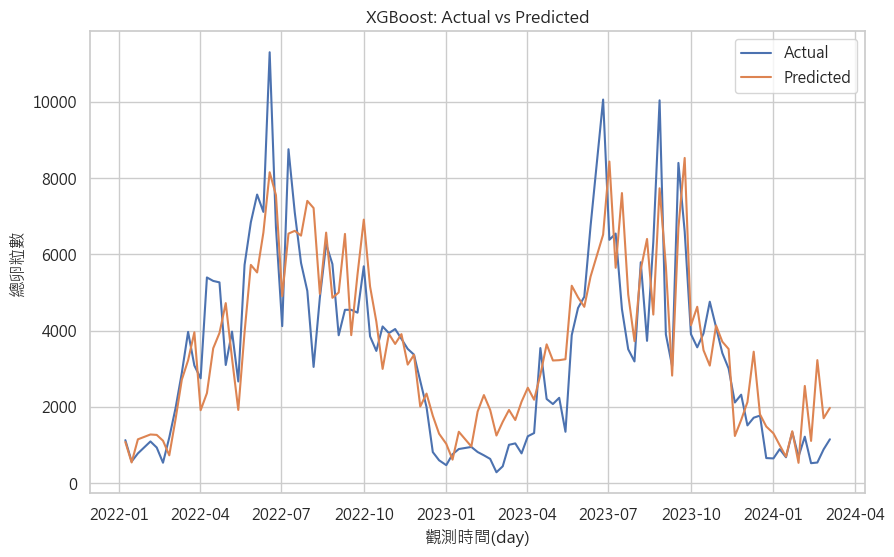

In [266]:
# 超參數優化
max_evals = 100
trials = Trials()
history = []
best_params = fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals)

# 使用最佳超參數訓練最終模型
best_model = xgb.train({
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eta': 0.1,
    'gamma': best_params['gamma'],
    'alpha': 0.0,
    'lambda': 1.0,
    'min_child_weight': best_params['min_child_weight'],
    'max_depth': int(best_params['max_depth']),
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'random_state': 32
}, dtrain, num_boost_round=1000, verbose_eval=False, early_stopping_rounds=10, evals=[(dtrain, 'train'), (dvalid, 'eval')])

# 使用最佳模型進行預測
pred = best_model.predict(dvalid)

# 計算預測結果的 RMSE
rmse = mean_squared_error(val_y, pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# 可視化預測結果
plt.figure(figsize=(10, 6))
plt.plot(val_data['觀測時間(day)'], val_y, label='Actual')
plt.plot(val_data['觀測時間(day)'], pred, label='Predicted')
plt.title('XGBoost: Actual vs Predicted')
plt.xlabel('觀測時間(day)')
plt.ylabel('總卵粒數')
#plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


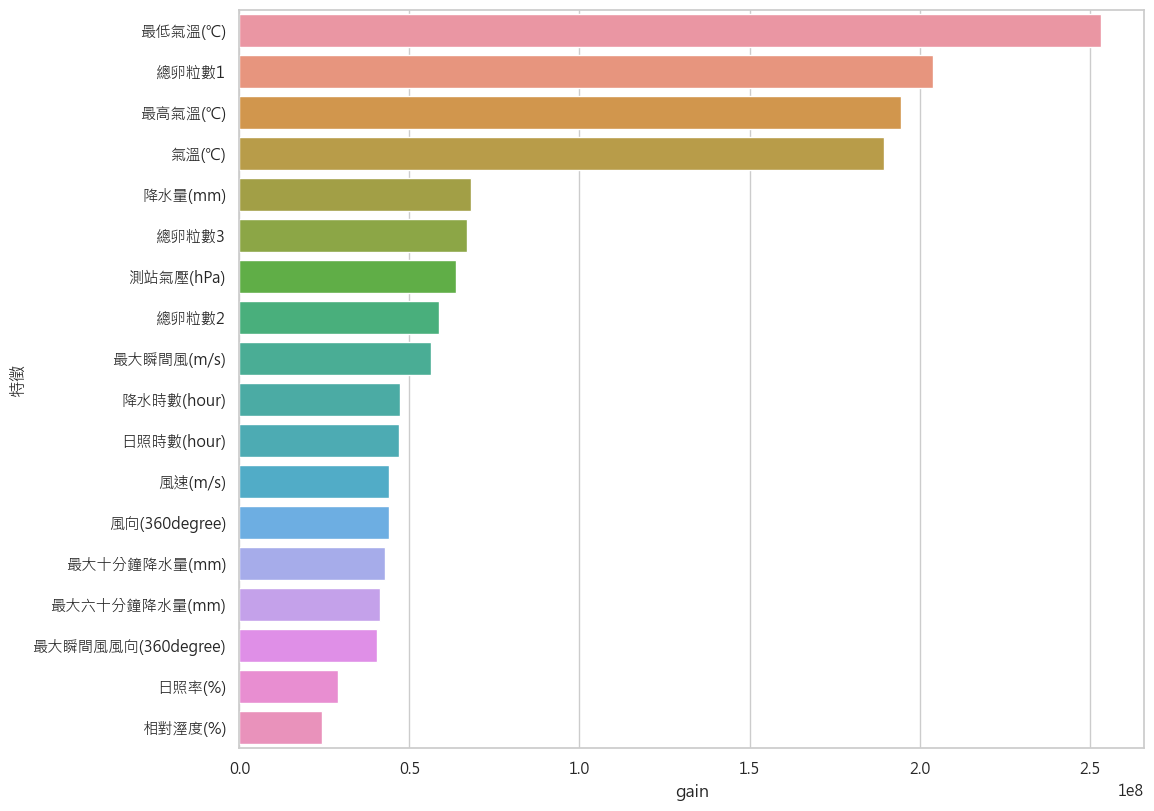

In [268]:
fi = {}
for index, col in enumerate(train_x.columns):
    fi_sum = 0
    for i in range(100):
        fi_sum += history[i][2].get(f'f{index}', 0)
    fi[col] = fi_sum/10

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
#plt.rcParams[".30................3.3figure.figsize"] = (11.7,8.27)
plt.rcParams['figure.figsize'] = (11.7, 8.27)

sns.set(font=['sans-serif'])
sns.set_style("whitegrid", {"font.sans-serif": ['Microsoft JhengHei']})
sns.barplot(data=pd.DataFrame({'特徵': list(fi.keys()), 'gain': list(fi.values())}).sort_values(['gain'], ascending=False), x='gain', y='特徵')
plt.tight_layout()
plt.show()

# xgb - 2022-01-31 開始預測

100%|██████████| 100/100 [00:03<00:00, 31.35trial/s, best loss: 1307.2936548160317]
Root Mean Squared Error (RMSE): 1307.2937


C:\Users\lilj\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32317 (\N{CJK UNIFIED IDEOGRAPH-7E3D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\lilj\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21365 (\N{CJK UNIFIED IDEOGRAPH-5375}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\lilj\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31890 (\N{CJK UNIFIED IDEOGRAPH-7C92}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\lilj\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25976 (\N{CJK UNIFIED IDEOGRAPH-6578}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\lilj\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35264 (\N{CJK UNIFIED IDEOGRAPH-89C0}) missing from current font.
  fig.canvas.print_figure(bytes_io, *

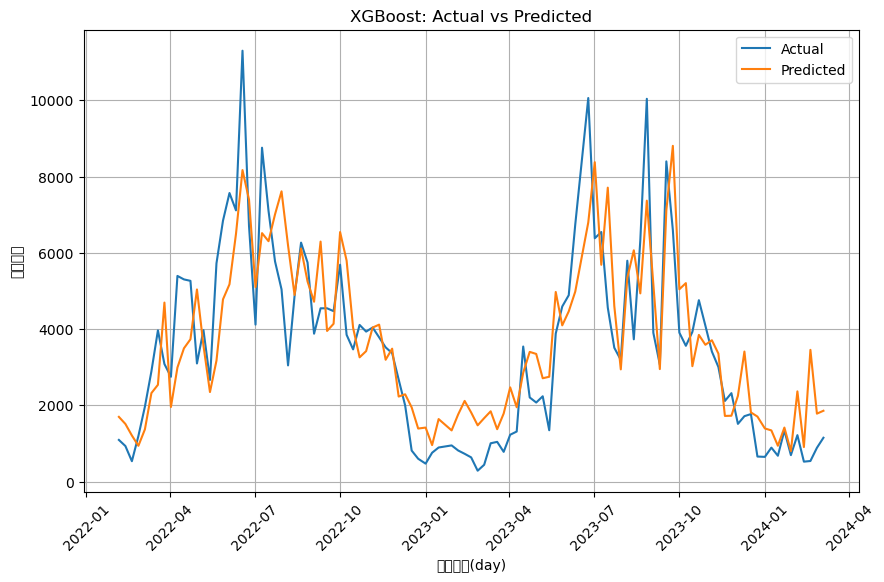

In [227]:
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 定義超參數空間
param_space = {
    'min_child_weight': hp.loguniform('min_child_weight', np.log(0.1), np.log(10)),
    'max_depth': hp.quniform('max_depth', 3, 9, 1),
    'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
    'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
}

# 定義評分函數
def score(space):
    params = {
        'booster': 'gbtree',
        'objective': 'reg:squarederror',
        'eta': 0.1,
        'gamma': space['gamma'],
        'alpha': 0.0,
        'lambda': 1.0,
        'min_child_weight': space['min_child_weight'],
        'max_depth': int(space['max_depth']),
        'subsample': space['subsample'],
        'colsample_bytree': space['colsample_bytree'],
        'random_state': 32
    }
    model = xgb.train(params, dtrain, num_boost_round=1000, verbose_eval=False, early_stopping_rounds=10, evals=[(dtrain, 'train'), (dvalid, 'eval')])
    pred = model.predict(dvalid)
    score = mean_squared_error(val_y, pred, squared=False)
    history.append((params, score, model.get_score(importance_type='gain')))
    return {'loss': score, 'status': STATUS_OK}

# 訓練集和驗證集的準備
train_data = df_dengue_input[df_dengue_input['觀測時間(day)'] <= '2022-01-31']
val_data = df_dengue_input[df_dengue_input['觀測時間(day)'] > '2022-01-31']

train_x = train_data.drop(columns=['總卵粒數', '觀測時間(day)', '陽性率%'])
train_y = train_data['總卵粒數']
val_x = val_data.drop(columns=['總卵粒數', '觀測時間(day)', '陽性率%'])
val_y = val_data['總卵粒數']

scaler = MinMaxScaler()
train_x_scale = scaler.fit_transform(train_x)
val_x_scale = scaler.transform(val_x)

dtrain = xgb.DMatrix(train_x_scale, label=train_y)
dvalid = xgb.DMatrix(val_x_scale, label=val_y)

# 超參數優化
max_evals = 100
trials = Trials()
history = []
best_params = fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals)

# 使用最佳超參數訓練最終模型
best_model = xgb.train({
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eta': 0.1,
    'gamma': best_params['gamma'],
    'alpha': 0.0,
    'lambda': 1.0,
    'min_child_weight': best_params['min_child_weight'],
    'max_depth': int(best_params['max_depth']),
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'random_state': 32
}, dtrain, num_boost_round=1000, verbose_eval=False, early_stopping_rounds=10, evals=[(dtrain, 'train'), (dvalid, 'eval')])

# 使用最佳模型進行預測
pred = best_model.predict(dvalid)

# 計算預測結果的 RMSE
rmse = mean_squared_error(val_y, pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# 可視化預測結果
plt.figure(figsize=(10, 6))
plt.plot(val_data['觀測時間(day)'], val_y, label='Actual')
plt.plot(val_data['觀測時間(day)'], pred, label='Predicted')
plt.title('XGBoost: Actual vs Predicted')
plt.xlabel('觀測時間(day)')
plt.ylabel('總卵粒數')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


# 2022-06-01 開始預測

100%|██████████| 100/100 [00:03<00:00, 32.30trial/s, best loss: 1291.4940448157759]
Root Mean Squared Error (RMSE): 1291.4940


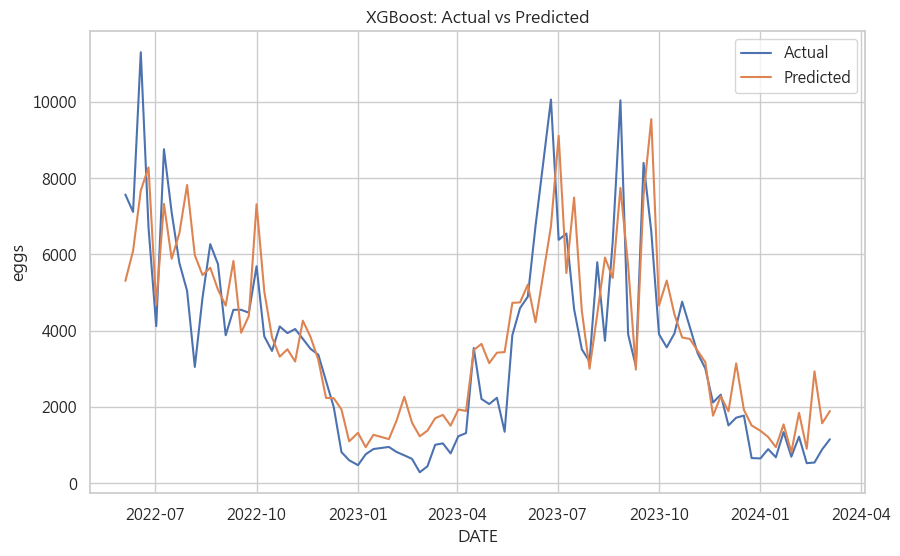

In [237]:
# 定義超參數空間
param_space = {
    'min_child_weight': hp.loguniform('min_child_weight', np.log(0.1), np.log(10)),
    'max_depth': hp.quniform('max_depth', 3, 9, 1),
    'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
    'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
}

# 定義評分函數
def score(space):
    params = {
        'booster': 'gbtree',
        'objective': 'reg:squarederror',
        'eta': 0.1,
        'gamma': space['gamma'],
        'alpha': 0.0,
        'lambda': 1.0,
        'min_child_weight': space['min_child_weight'],
        'max_depth': int(space['max_depth']),
        'subsample': space['subsample'],
        'colsample_bytree': space['colsample_bytree'],
        'random_state': 32
    }
    model = xgb.train(params, dtrain, num_boost_round=1000, verbose_eval=False, early_stopping_rounds=10, evals=[(dtrain, 'train'), (dvalid, 'eval')])
    pred = model.predict(dvalid)
    score = mean_squared_error(val_y, pred, squared=False)
    history.append((params, score, model.get_score(importance_type='gain')))
    return {'loss': score, 'status': STATUS_OK}

# 訓練集和驗證集的準備
train_data = df_dengue_input[df_dengue_input['觀測時間(day)'] <= '2022-05-31']
val_data = df_dengue_input[df_dengue_input['觀測時間(day)'] > '2022-05-31']

train_x = train_data.drop(columns=['總卵粒數', '觀測時間(day)', '陽性率%'])
train_y = train_data['總卵粒數']
val_x = val_data.drop(columns=['總卵粒數', '觀測時間(day)', '陽性率%'])
val_y = val_data['總卵粒數']

scaler = MinMaxScaler()
train_x_scale = scaler.fit_transform(train_x)
val_x_scale = scaler.transform(val_x)

dtrain = xgb.DMatrix(train_x_scale, label=train_y)
dvalid = xgb.DMatrix(val_x_scale, label=val_y)

# 超參數優化
max_evals = 100
trials = Trials()
history = []
best_params = fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals)

# 使用最佳超參數訓練最終模型
best_model = xgb.train({
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eta': 0.1,
    'gamma': best_params['gamma'],
    'alpha': 0.0,
    'lambda': 1.0,
    'min_child_weight': best_params['min_child_weight'],
    'max_depth': int(best_params['max_depth']),
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'random_state': 32
}, dtrain, num_boost_round=1000, verbose_eval=False, early_stopping_rounds=10, evals=[(dtrain, 'train'), (dvalid, 'eval')])

# 使用最佳模型進行預測
pred = best_model.predict(dvalid)

# 計算預測結果的 RMSE
rmse = mean_squared_error(val_y, pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# 可視化預測結果
plt.figure(figsize=(10, 6))
plt.plot(val_data['觀測時間(day)'], val_y, label='Actual')
plt.plot(val_data['觀測時間(day)'], pred, label='Predicted')
plt.title('XGBoost: Actual vs Predicted')
plt.xlabel('DATE')
plt.ylabel('eggs')
#plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# 2022-10-01

100%|██████████| 100/100 [00:04<00:00, 24.75trial/s, best loss: 1273.649395347337]
Root Mean Squared Error (RMSE): 1273.6494


findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of 

findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of 

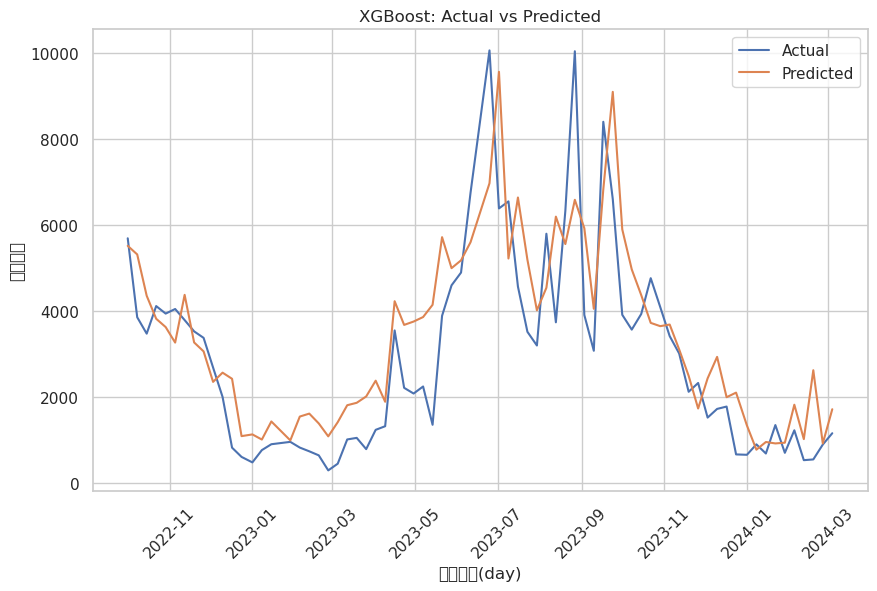

In [820]:
# 定義超參數空間
param_space = {
    'min_child_weight': hp.loguniform('min_child_weight', np.log(0.1), np.log(10)),
    'max_depth': hp.quniform('max_depth', 3, 9, 1),
    'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
    'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
}

# 定義評分函數
def score(space):
    params = {
        'booster': 'gbtree',
        'objective': 'reg:squarederror',
        'eta': 0.1,
        'gamma': space['gamma'],
        'alpha': 0.0,
        'lambda': 1.0,
        'min_child_weight': space['min_child_weight'],
        'max_depth': int(space['max_depth']),
        'subsample': space['subsample'],
        'colsample_bytree': space['colsample_bytree'],
        'random_state': 32
    }
    model = xgb.train(params, dtrain, num_boost_round=1000, verbose_eval=False, early_stopping_rounds=10, evals=[(dtrain, 'train'), (dvalid, 'eval')])
    pred = model.predict(dvalid)
    score = mean_squared_error(val_y, pred, squared=False)
    history.append((params, score, model.get_score(importance_type='gain')))
    return {'loss': score, 'status': STATUS_OK}

# 訓練集和驗證集的準備
train_data = df_dengue_input[df_dengue_input['觀測時間(day)'] <= '2022-09-30']
val_data = df_dengue_input[df_dengue_input['觀測時間(day)'] > '2022-09-30']

train_x = train_data.drop(columns=['總卵粒數', '觀測時間(day)', '陽性率%'])
train_y = train_data['總卵粒數']
val_x = val_data.drop(columns=['總卵粒數', '觀測時間(day)', '陽性率%'])
val_y = val_data['總卵粒數']

scaler = MinMaxScaler()
train_x_scale = scaler.fit_transform(train_x)
val_x_scale = scaler.transform(val_x)

dtrain = xgb.DMatrix(train_x_scale, label=train_y)
dvalid = xgb.DMatrix(val_x_scale, label=val_y)

# 超參數優化
max_evals = 100
trials = Trials()
history = []
best_params = fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals)

# 使用最佳超參數訓練最終模型
best_model = xgb.train({
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eta': 0.1,
    'gamma': best_params['gamma'],
    'alpha': 0.0,
    'lambda': 1.0,
    'min_child_weight': best_params['min_child_weight'],
    'max_depth': int(best_params['max_depth']),
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'random_state': 32
}, dtrain, num_boost_round=1000, verbose_eval=False, early_stopping_rounds=10, evals=[(dtrain, 'train'), (dvalid, 'eval')])

# 使用最佳模型進行預測
pred = best_model.predict(dvalid)

# 計算預測結果的 RMSE
rmse = mean_squared_error(val_y, pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# 可視化預測結果
plt.figure(figsize=(10, 6))
plt.plot(val_data['觀測時間(day)'], val_y, label='Actual')
plt.plot(val_data['觀測時間(day)'], pred, label='Predicted')
plt.title('XGBoost: Actual vs Predicted')
plt.xlabel('觀測時間(day)')
plt.ylabel('總卵粒數')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


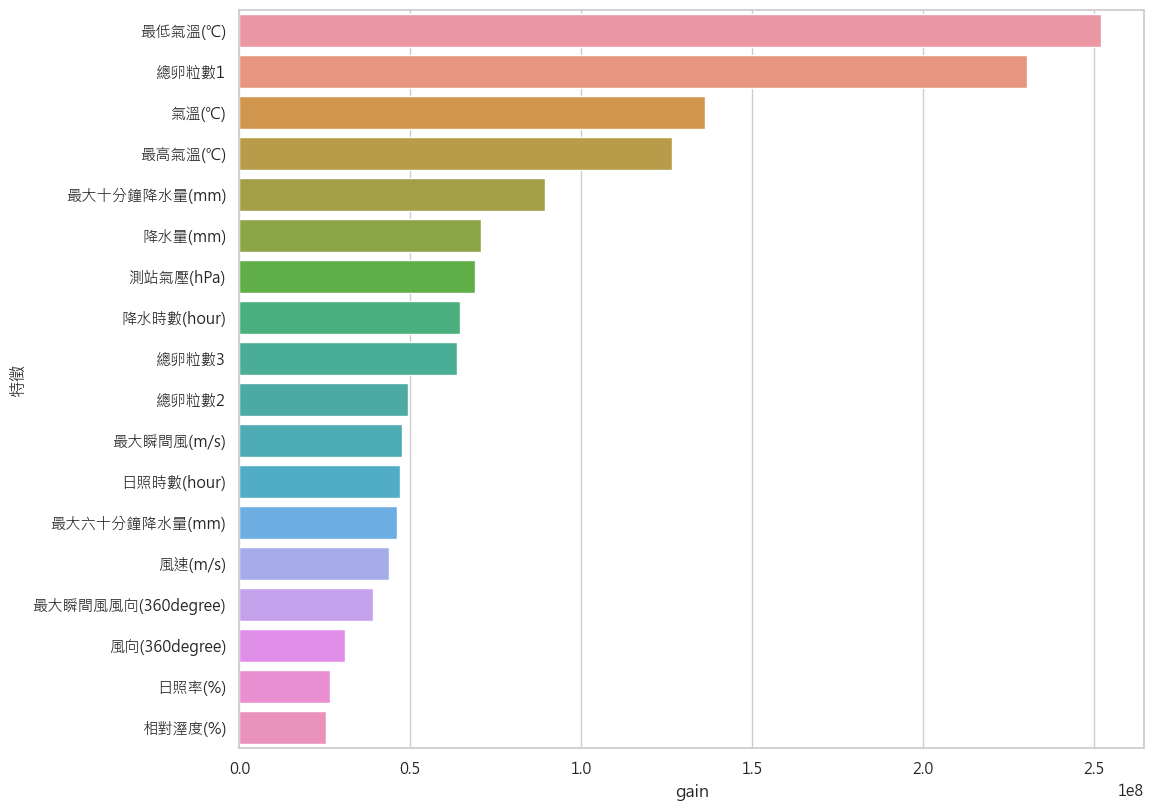

In [230]:
fi = {}
for index, col in enumerate(train_x.columns):
    fi_sum = 0
    for i in range(100):
        fi_sum += history[i][2].get(f'f{index}', 0)
    fi[col] = fi_sum/10

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
#plt.rcParams[".30................3.3figure.figsize"] = (11.7,8.27)
plt.rcParams['figure.figsize'] = (11.7, 8.27)

sns.set(font=['sans-serif'])
sns.set_style("whitegrid", {"font.sans-serif": ['Microsoft JhengHei']})
sns.barplot(data=pd.DataFrame({'特徵': list(fi.keys()), 'gain': list(fi.values())}).sort_values(['gain'], ascending=False), x='gain', y='特徵')
plt.tight_layout()
plt.show()

# bayesian

In [276]:
df_dengue_input = young_df_weather.copy()

In [277]:
param_space = {
    'alpha_1': hp.loguniform('alpha_1', np.log(1e-9), np.log(1e-3)),
    'alpha_2': hp.loguniform('alpha_2', np.log(1e-9), np.log(1e-3)),
    'lambda_1': hp.loguniform('lambda_1', np.log(1e-9), np.log(1e-3)),
    'lambda_2': hp.loguniform('lambda_2', np.log(1e-9), np.log(1e-3)),
    'max_iter': hp.quniform('max_iter', 100, 500, 1),
}

def score(space):
    params = {
        'alpha_1': space['alpha_1'],
        'alpha_2': space['alpha_2'],
        'lambda_1': space['lambda_1'],
        'lambda_2': space['lambda_2'],
        'max_iter': int(space['max_iter']),
    }
    clf = BayesianRidge(**params)
    clf.fit(train_x_scale, train_y)
    pred = clf.predict(val_x_scale)
    score = mean_squared_error(val_y, pred, squared=False)
    history.append((clf.get_params(), score, clf.coef_))
    return {'loss': score, 'status': STATUS_OK}

In [279]:
train_data = df_dengue_input[df_dengue_input['觀測時間(day)'] <= '2022-05-31']
val_data = df_dengue_input[df_dengue_input['觀測時間(day)'] > '2022-05-31']

train_x = train_data.drop(columns=['總卵粒數', '觀測時間(day)','陽性率%'])
train_y = train_data['總卵粒數']
val_x = val_data.drop(columns=['總卵粒數', '觀測時間(day)','陽性率%'])
val_y = val_data['總卵粒數']

scaler = MinMaxScaler()
train_x_scale = scaler.fit_transform(train_x)
val_x_scale = scaler.transform(val_x)

max_evals = 100
trials = Trials()
history = []
fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals)
history = sorted(history, key=lambda tpl: tpl[1])
print(f'best params:{history[0][0]}, score:{history[0][1]:.4f}')

100%|██████████| 100/100 [00:00<00:00, 124.52trial/s, best loss: 1335.470757704894]
best params:{'alpha_1': 0.000992072763831485, 'alpha_2': 2.411327913522417e-09, 'alpha_init': None, 'compute_score': False, 'copy_X': True, 'fit_intercept': True, 'lambda_1': 1.856662910129131e-08, 'lambda_2': 5.0932673893908884e-08, 'lambda_init': None, 'max_iter': 244, 'n_iter': 'deprecated', 'tol': 0.001, 'verbose': False}, score:1335.4708


In [278]:
train_data = df_dengue_input[df_dengue_input['觀測時間(day)'] <= '2022-01-01']
val_data = df_dengue_input[df_dengue_input['觀測時間(day)'] > '2022-01-01']

train_x = train_data.drop(columns=['總卵粒數', '觀測時間(day)','陽性率%'])
train_y = train_data['總卵粒數']
val_x = val_data.drop(columns=['總卵粒數', '觀測時間(day)','陽性率%'])
val_y = val_data['總卵粒數']

scaler = MinMaxScaler()
train_x_scale = scaler.fit_transform(train_x)
val_x_scale = scaler.transform(val_x)

max_evals = 100
trials = Trials()
history = []
fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals)
history = sorted(history, key=lambda tpl: tpl[1])
print(f'best params:{history[0][0]}, score:{history[0][1]:.4f}')

100%|██████████| 100/100 [00:00<00:00, 111.53trial/s, best loss: 1287.2088048079079]
best params:{'alpha_1': 0.0009985766064105064, 'alpha_2': 6.367918093997753e-06, 'alpha_init': None, 'compute_score': False, 'copy_X': True, 'fit_intercept': True, 'lambda_1': 9.231655275488387e-09, 'lambda_2': 0.0009103465811504121, 'lambda_init': None, 'max_iter': 229, 'n_iter': 'deprecated', 'tol': 0.001, 'verbose': False}, score:1287.2088


100%|██████████| 100/100 [00:01<00:00, 60.13trial/s, best loss: 1335.4707593105277]

findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of 


Root Mean Squared Error (RMSE): 1335.4708


findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of 

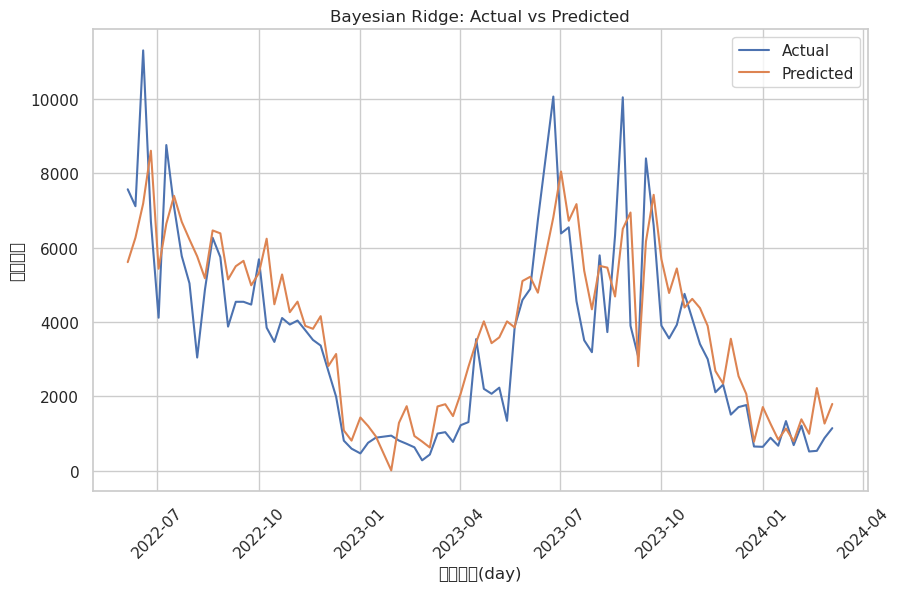

In [765]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

# 定义参数空间
param_space = {
    'alpha_1': hp.loguniform('alpha_1', np.log(1e-9), np.log(1e-3)),
    'alpha_2': hp.loguniform('alpha_2', np.log(1e-9), np.log(1e-3)),
    'lambda_1': hp.loguniform('lambda_1', np.log(1e-9), np.log(1e-3)),
    'lambda_2': hp.loguniform('lambda_2', np.log(1e-9), np.log(1e-3)),
    'max_iter': hp.quniform('max_iter', 100, 500, 1),  # 使用 quniform 定义整数范围
}

# 定义评分函数
def score(space):
    params = {
        'alpha_1': space['alpha_1'],
        'alpha_2': space['alpha_2'],
        'lambda_1': space['lambda_1'],
        'lambda_2': space['lambda_2'],
        'max_iter': int(space['max_iter']),  # 将 max_iter 转换为整数
    }
    clf = BayesianRidge(**params)
    clf.fit(train_x_scale, train_y)
    pred = clf.predict(val_x_scale)
    score = mean_squared_error(val_y, pred, squared=False)
    history.append((clf.get_params(), score, clf.coef_))
    return {'loss': score, 'status': STATUS_OK}

# 假设您已经定义了 train_x_scale, train_y, val_x_scale, val_y
# train_x_scale, val_x_scale: 经过缩放的训练集和验证集特征
# train_y, val_y: 训练集和验证集标签

# 初始化 Trials 和 history
trials = Trials()
history = []

# 运行超参数优化
best_params = fmin(score, param_space, algo=tpe.suggest, max_evals=100, trials=trials)

# 使用最佳超参数训练最终模型
best_model = BayesianRidge(
    alpha_1=best_params['alpha_1'],
    alpha_2=best_params['alpha_2'],
    lambda_1=best_params['lambda_1'],
    lambda_2=best_params['lambda_2'],
    max_iter=int(best_params['max_iter'])  # 确保 max_iter 是整数类型
)
best_model.fit(train_x_scale, train_y)

# 使用最佳模型进行预测
pred = best_model.predict(val_x_scale)

# 计算预测结果的 RMSE
rmse = mean_squared_error(val_y, pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# 可视化预测结果
plt.figure(figsize=(10, 6))
plt.plot(val_data['觀測時間(day)'], val_y, label='Actual')
plt.plot(val_data['觀測時間(day)'], pred, label='Predicted')
plt.title('Bayesian Ridge: Actual vs Predicted')
plt.xlabel('觀測時間(day)')
plt.ylabel('總卵粒數')
plt.xticks(rotation=45)
plt.legend()
plt.show()


findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of 

C:\Users\lilj\AppData\Local\Temp\ipykernel_14520\2410493874.py:24: UserWarning: Glyph 20845 (\N{CJK UNIFIED IDEOGRAPH-516D}) missing from current font.
  plt.tight_layout()
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont

findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
C:\Users\lilj\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
C:\Users\lilj\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39080 (\N{CJK UNIFIED IDEOGRAPH-98A8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\lilj\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21521 (\N{CJK UNIFIED IDEOGRAPH-5411}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
C:\Users\lilj\anaconda3\Lib\site-packages\IPyt

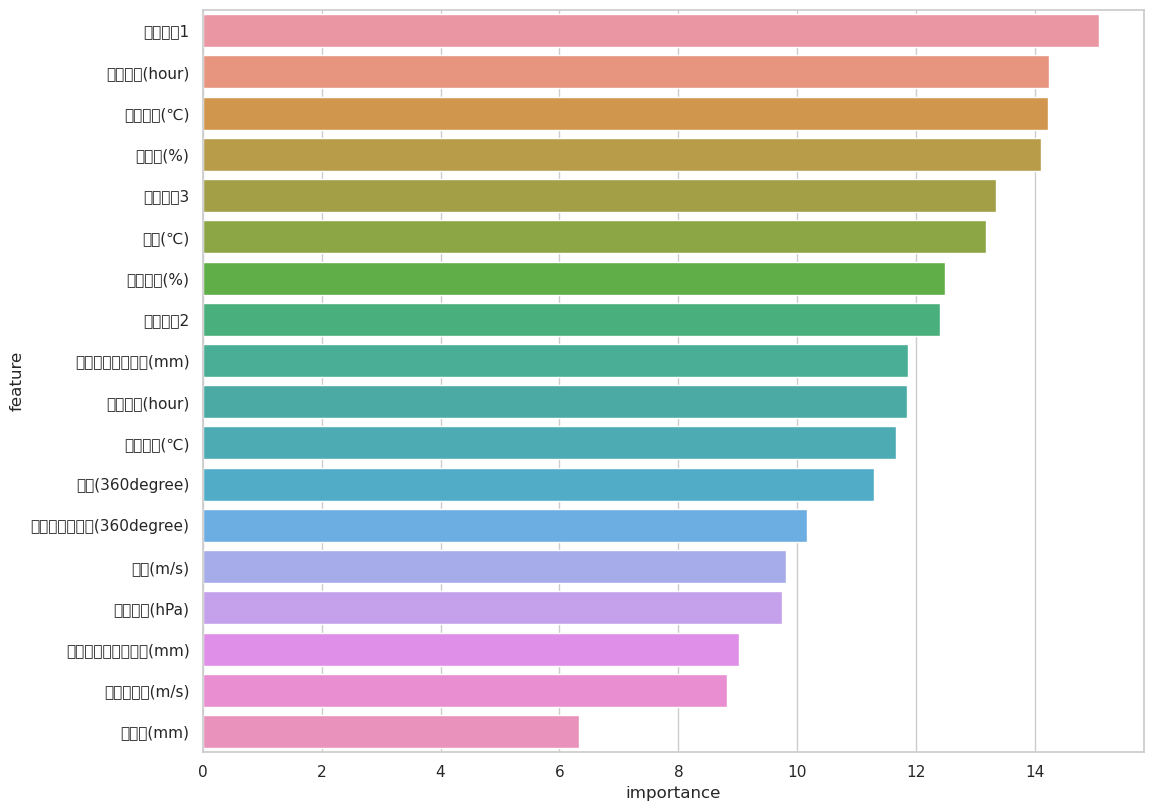

In [746]:
import math
# 使用最佳參數訓練模型
best_params = history[0][0]
model = BayesianRidge(**best_params)
model.fit(train_x_scale, train_y)

# 計算置換特徵重要性
result = permutation_importance(model, val_x_scale, val_y, n_repeats=10)

# 創建一個 DataFrame 來存儲特徵重要性
importance = pd.DataFrame()
importance['feature'] = train_x.columns
importance['importance'] = [math.log(abs(i)*10000000) for i in result.importances_mean]

# 繪製特徵重要性
plt.rcParams['font.sans-serif'] = ['jf-openhuninn-2.0'] 
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (11.7,8.27)

sns.set(font=['sans-serif'])
sns.set_style("whitegrid", {"font.sans-serif": ['jf-openhuninn-2.0']})

sns.barplot(data=importance.sort_values('importance', ascending=False), x='importance', y='feature')
plt.tight_layout()
plt.show()

# linear

In [280]:
df_dengue_input = young_df_weather.copy()

In [748]:
train_data = df_dengue_input[df_dengue_input['觀測時間(day)'] <= '2022-05-31']
val_data = df_dengue_input[df_dengue_input['觀測時間(day)'] > '2022-05-31']

train_x = train_data.drop(columns=['總卵粒數', '觀測時間(day)','陽性率%'])
train_y = train_data['總卵粒數']
val_x = val_data.drop(columns=['總卵粒數', '觀測時間(day)','陽性率%'])
val_y = val_data['總卵粒數']

scaler = MinMaxScaler()
train_x_scale = scaler.fit_transform(train_x)
val_x_scale = scaler.transform(val_x)

reg = LinearRegression().fit(train_x_scale, train_y)
pred = reg.predict(val_x_scale)
print(mean_squared_error(val_y, pred, squared=False))

1361.2467842437236


In [281]:
train_data = df_dengue_input[df_dengue_input['觀測時間(day)'] <= '2022-01-01']
val_data = df_dengue_input[df_dengue_input['觀測時間(day)'] > '2022-01-01']

train_x = train_data.drop(columns=['總卵粒數', '觀測時間(day)','陽性率%'])
train_y = train_data['總卵粒數']
val_x = val_data.drop(columns=['總卵粒數', '觀測時間(day)','陽性率%'])
val_y = val_data['總卵粒數']

scaler = MinMaxScaler()
train_x_scale = scaler.fit_transform(train_x)
val_x_scale = scaler.transform(val_x)

reg = LinearRegression().fit(train_x_scale, train_y)
pred = reg.predict(val_x_scale)
print(mean_squared_error(val_y, pred, squared=False))

1386.4303866555047


findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of 

findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of 

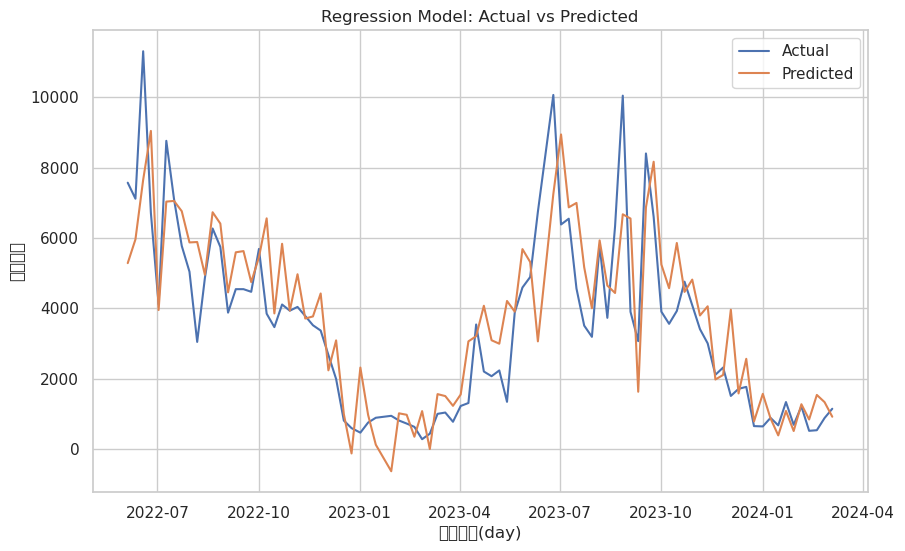

In [749]:
plt.figure(figsize=(10, 6))
plt.plot(val_data['觀測時間(day)'], val_y, label='Actual')
plt.plot(val_data['觀測時間(day)'], pred, label='Predicted')
plt.title('Regression Model: Actual vs Predicted')
plt.xlabel('觀測時間(day)')
plt.ylabel('總卵粒數')
plt.legend()
plt.show()

# SVM

In [282]:
df_dengue_input = young_df_weather.copy()

In [283]:
param_space = {
    'C': hp.loguniform('C', np.log(1e-1), np.log(1e1)),  # 正則化參數
    'epsilon': hp.loguniform('epsilon', np.log(1e-3), np.log(1e-1))  # SVR模型的epsilon參數
}

def score(space):
    params = {
        'C': space['C'],
        'epsilon': space['epsilon']
    }
    clf = SVR(**params)
    clf.fit(train_x_scale, train_y)
    pred = clf.predict(val_x_scale)
    score = mean_squared_error(val_y, pred, squared=False)

    # 只有在使用線性核函數時才嘗試獲取 coef_
    if clf.kernel == 'linear':
        coef = clf.coef_
    else:
        coef = None

    history.append((clf.get_params(), score, coef))
    return {'loss': score, 'status': STATUS_OK}

In [248]:
train_data = df_dengue_input[df_dengue_input['觀測時間(day)'] <= '2022-05-31']
val_data = df_dengue_input[df_dengue_input['觀測時間(day)'] > '2022-05-31']

train_x = train_data.drop(columns=[ '總卵粒數','觀測時間(day)','陽性率%'])
train_y = train_data['總卵粒數']
val_x = val_data.drop(columns=['總卵粒數', '觀測時間(day)','陽性率%'])
val_y = val_data['總卵粒數']

scaler = MinMaxScaler()
train_x_scale = scaler.fit_transform(train_x)
val_x_scale = scaler.transform(val_x)
# 有試過將y也scale 結果一樣
# y_scaler = MinMaxScaler()
# train_y_scale = y_scaler.fit_transform(train_y.to_numpy().reshape(-1, 1))
# val_y_scale = y_scaler.transform(val_y.to_numpy().reshape(-1, 1))

max_evals = 1000
trials = Trials()
history = []
fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals)
history = sorted(history, key=lambda tpl: tpl[1])
print(f'best params:{history[0][0]}, score:{history[0][1]:.4f}')

100%|██████████| 1000/1000 [00:07<00:00, 132.93trial/s, best loss: 2462.509609641012]
best params:{'C': 9.999286015172196, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.0047396581086309965, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}, score:2462.5096


In [284]:
train_data = df_dengue_input[df_dengue_input['觀測時間(day)'] <= '2022-01-01']
val_data = df_dengue_input[df_dengue_input['觀測時間(day)'] > '2022-01-01']

train_x = train_data.drop(columns=[ '總卵粒數','觀測時間(day)','陽性率%'])
train_y = train_data['總卵粒數']
val_x = val_data.drop(columns=['總卵粒數', '觀測時間(day)','陽性率%'])
val_y = val_data['總卵粒數']

scaler = MinMaxScaler()
train_x_scale = scaler.fit_transform(train_x)
val_x_scale = scaler.transform(val_x)
# 有試過將y也scale 結果一樣
# y_scaler = MinMaxScaler()
# train_y_scale = y_scaler.fit_transform(train_y.to_numpy().reshape(-1, 1))
# val_y_scale = y_scaler.transform(val_y.to_numpy().reshape(-1, 1))

max_evals = 1000
trials = Trials()
history = []
fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals)
history = sorted(history, key=lambda tpl: tpl[1])
print(f'best params:{history[0][0]}, score:{history[0][1]:.4f}')

100%|██████████| 1000/1000 [00:07<00:00, 139.54trial/s, best loss: 2441.5414078648073]
best params:{'C': 9.999257376945838, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.0025712219193179398, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}, score:2441.5414


100%|██████████| 100/100 [00:00<00:00, 199.44trial/s, best loss: 2508.8848599131275]
Root Mean Squared Error (RMSE): 2508.8849


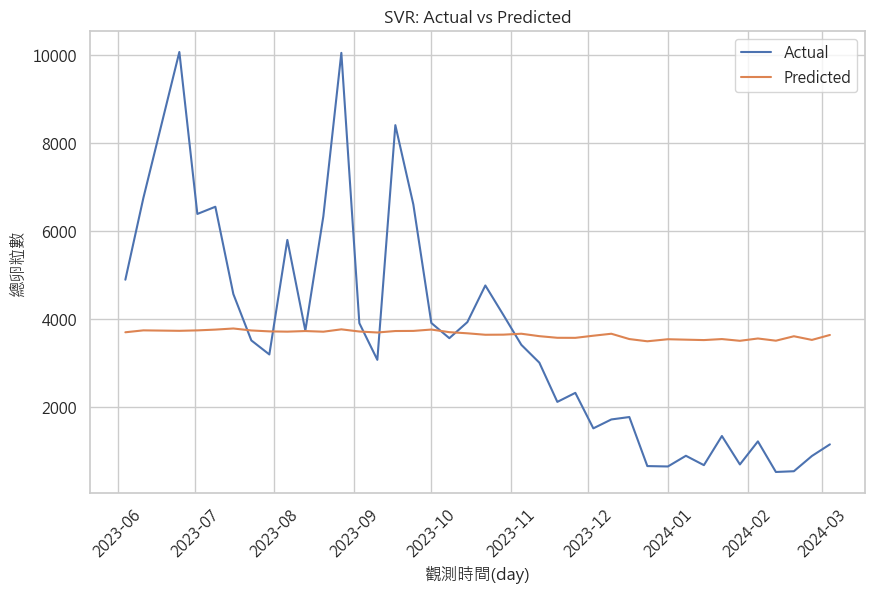

In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

# 定义参数空间
param_space = {
    'C': hp.loguniform('C', np.log(1e-1), np.log(1e1)),  # 正则化参数
    'epsilon': hp.loguniform('epsilon', np.log(1e-3), np.log(1e-1))  # SVR模型的epsilon参数
}

# 定义评分函数
def score(space):
    params = {
        'C': space['C'],
        'epsilon': space['epsilon']
    }
    clf = SVR(**params)
    clf.fit(train_x_scale, train_y)
    pred = clf.predict(val_x_scale)
    score = mean_squared_error(val_y, pred, squared=False)

    # 只有在使用线性核函数时才尝试获取 coef_
    if clf.kernel == 'linear':
        coef = clf.coef_
    else:
        coef = None

    history.append((clf.get_params(), score, coef))
    return {'loss': score, 'status': STATUS_OK}

# 假设您已经定义了 train_x_scale, train_y, val_x_scale, val_y
# train_x_scale, val_x_scale: 经过缩放的训练集和验证集特征
# train_y, val_y: 训练集和验证集标签

# 初始化 Trials 和 history
trials = Trials()
history = []

# 运行超参数优化
max_evals = 100
best_params = fmin(score, param_space, algo=tpe.suggest, max_evals=max_evals, trials=trials)

# 使用最佳超参数训练最终模型
best_C = best_params['C']
best_epsilon = best_params['epsilon']

best_model = SVR(C=best_C, epsilon=best_epsilon)
best_model.fit(train_x_scale, train_y)

# 使用最佳模型进行预测
pred = best_model.predict(val_x_scale)

# 计算预测结果的 RMSE
rmse = mean_squared_error(val_y, pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# 可视化预测结果
plt.figure(figsize=(10, 6))
plt.plot(val_data['觀測時間(day)'], val_y, label='Actual')
plt.plot(val_data['觀測時間(day)'], pred, label='Predicted')
plt.title('SVR: Actual vs Predicted')
plt.xlabel('觀測時間(day)')
plt.ylabel('總卵粒數')
plt.xticks(rotation=45)
plt.legend()
plt.show()


findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of 

C:\Users\lilj\AppData\Local\Temp\ipykernel_14520\356662507.py:23: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from current font.
  plt.tight_layout()
C:\Users\lilj\AppData\Local\Temp\ipykernel_14520\356662507.py:23: UserWarning: Glyph 23565 (\N{CJK UNIFIED IDEOGRAPH-5C0D}) missing from current font.
  plt.tight_layout()
C:\Users\lilj\AppData\Local\Temp\ipykernel_14520\356662507.py:23: UserWarning: Glyph 28348 (\N{CJK UNIFIED IDEOGRAPH-6EBC}) missing from current font.
  plt.tight_layout()
C:\Users\lilj\AppData\Local\Temp\ipykernel_14520\356662507.py:23: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following 

C:\Users\lilj\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\lilj\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30636 (\N{CJK UNIFIED IDEOGRAPH-77AC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\lilj\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
C:\Users\lilj\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38477 (\N{CJK UNIFIED IDEOGRAPH-964D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\lilj\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserW

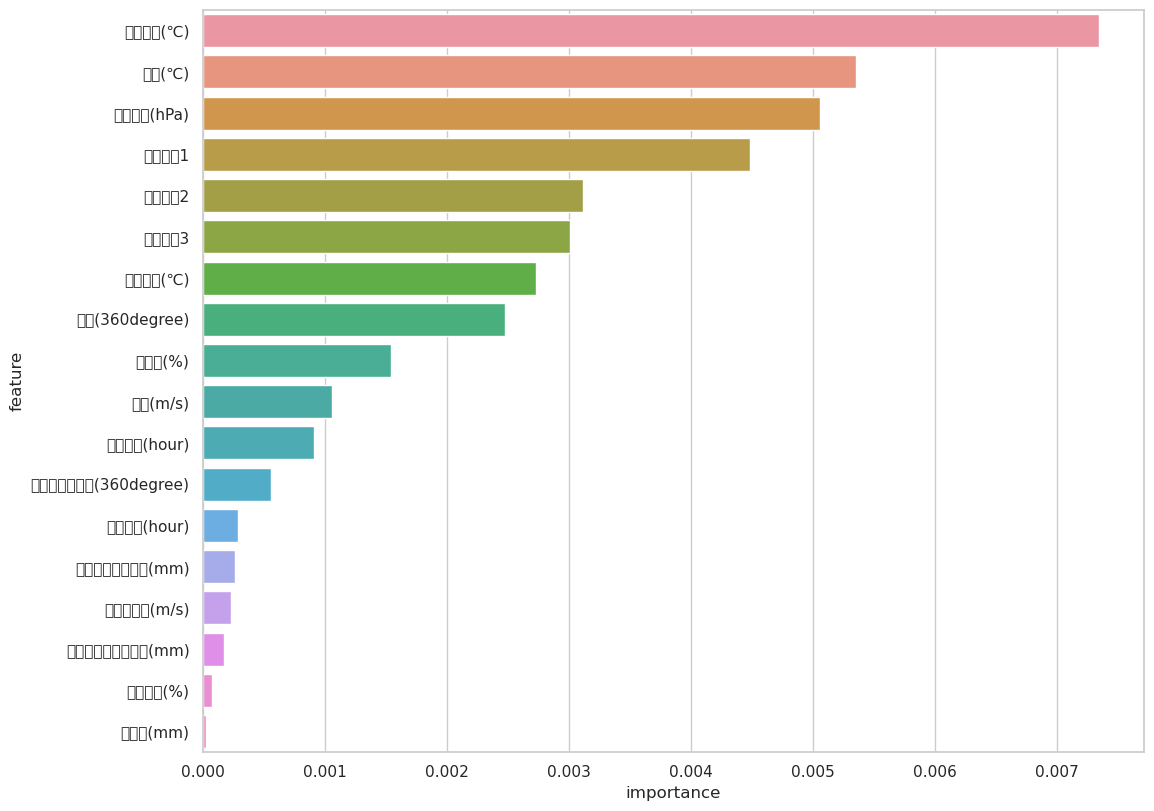

In [759]:
# 使用最佳參數訓練模型
best_params = history[0][0]
model = SVR(**best_params)
model.fit(train_x_scale, train_y)

# 計算置換特徵重要性
result = permutation_importance(model, val_x_scale, val_y, n_repeats=10)

# 創建一個 DataFrame 來存儲特徵重要性
importance = pd.DataFrame()
importance['feature'] = train_x.columns
importance['importance'] = result.importances_mean

# 繪製特徵重要性
plt.rcParams['font.sans-serif'] = ['jf-openhuninn-2.0'] 
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (11.7,8.27)

sns.set(font=['sans-serif'])
sns.set_style("whitegrid", {"font.sans-serif": ['jf-openhuninn-2.0']})

sns.barplot(data=importance.sort_values('importance', ascending=False), x='importance', y='feature')
plt.tight_layout()
plt.show()

# cross decomposition

In [299]:
from sklearn.cross_decomposition import PLSRegression

In [300]:
param_space = {
    'n_components': hp.choice('n_components', range(1, 10)),  # Number of components to keep
}

def score(space):
    params = {
        'n_components': space['n_components'],
    }
    clf = PLSRegression(**params)
    clf.fit(train_x_scale, train_y)
    pred = clf.predict(val_x_scale)[:, 0]
    score = mean_squared_error(val_y, pred, squared=False)

    history.append((clf.get_params(), score))
    return {'loss': score, 'status': STATUS_OK}

In [783]:
train_data = df_dengue_input[df_dengue_input['觀測時間(day)'] <= '2022-05-31']
val_data = df_dengue_input[df_dengue_input['觀測時間(day)'] > '2022-05-31']

train_x = train_data.drop(columns=['總卵粒數', '觀測時間(day)','陽性率%'])
train_y = train_data['總卵粒數']
val_x = val_data.drop(columns=['總卵粒數', '觀測時間(day)','陽性率%'])
val_y = val_data['總卵粒數']


scaler = MinMaxScaler()
train_x_scale = scaler.fit_transform(train_x)
val_x_scale = scaler.transform(val_x)

max_evals = 100
trials = Trials()
history = []
fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals)
history = sorted(history, key=lambda tpl: tpl[1])
print(f'best params:{history[0][0]}, score:{history[0][1]:.4f}')

100%|██████████| 100/100 [00:00<00:00, 389.59trial/s, best loss: 1333.2213278643121]
best params:{'copy': True, 'max_iter': 500, 'n_components': 4, 'scale': True, 'tol': 1e-06}, score:1333.2213


In [301]:
train_data = df_dengue_input[df_dengue_input['觀測時間(day)'] <= '2022-01-01']
val_data = df_dengue_input[df_dengue_input['觀測時間(day)'] > '2022-01-01']

train_x = train_data.drop(columns=['總卵粒數', '觀測時間(day)','陽性率%'])
train_y = train_data['總卵粒數']
val_x = val_data.drop(columns=['總卵粒數', '觀測時間(day)','陽性率%'])
val_y = val_data['總卵粒數']


scaler = MinMaxScaler()
train_x_scale = scaler.fit_transform(train_x)
val_x_scale = scaler.transform(val_x)

max_evals = 100
trials = Trials()
history = []
fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals)
history = sorted(history, key=lambda tpl: tpl[1])
print(f'best params:{history[0][0]}, score:{history[0][1]:.4f}')

100%|██████████| 100/100 [00:00<00:00, 398.41trial/s, best loss: 1274.524449517107]
best params:{'copy': True, 'max_iter': 500, 'n_components': 3, 'scale': True, 'tol': 1e-06}, score:1274.5244


findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of 

findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of 

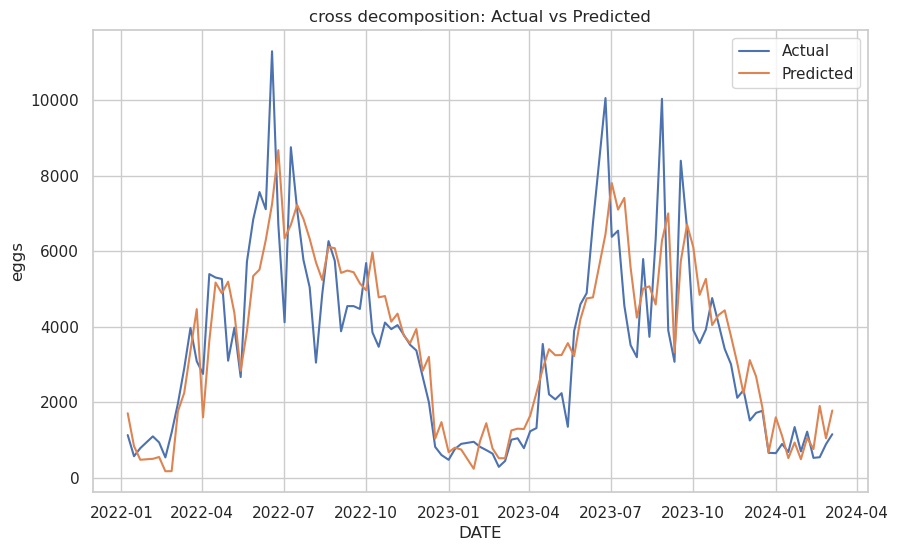

In [307]:
# 获取最佳参数对应的模型
best_params = history[0][0]
best_n_components = best_params['n_components']
best_pls = PLSRegression(n_components=best_n_components)
best_pls.fit(train_x_scale, train_y)

# 对验证集进行预测
pred_val = best_pls.predict(val_x_scale)[:, 0]

# 可视化预测结果与真实值
plt.figure(figsize=(10, 6))
plt.plot(val_data['觀測時間(day)'], val_y, label='Actual')
plt.plot(val_data['觀測時間(day)'], pred_val, label='Predicted')
plt.title('cross decomposition: Actual vs Predicted')
plt.xlabel('DATE')
plt.ylabel('eggs')
plt.legend()
plt.grid(True)
plt.show()


findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of 

findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of 

findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of 

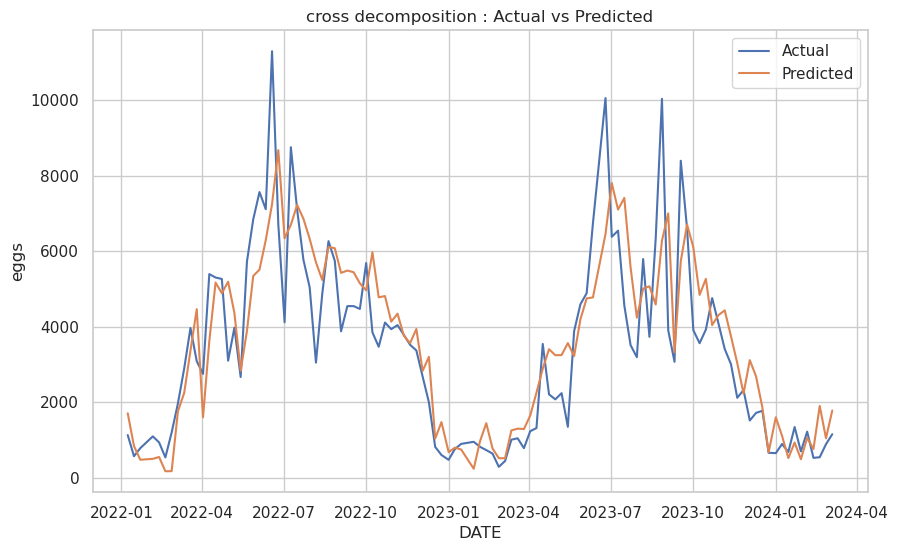

In [308]:
# 获取最佳参数对应的模型
best_params = history[0][0]
best_n_components = best_params['n_components']
best_pls = PLSRegression(n_components=best_n_components)
best_pls.fit(train_x_scale, train_y)

# 对验证集进行预测
pred_val = best_pls.predict(val_x_scale)[:, 0]

# 可视化预测结果与真实值
plt.figure(figsize=(10, 6))
plt.plot(val_data['觀測時間(day)'], val_y, label='Actual')
plt.plot(val_data['觀測時間(day)'], pred_val, label='Predicted')
plt.title('cross decomposition : Actual vs Predicted')
plt.xlabel('DATE')
plt.ylabel('eggs')
plt.legend()
plt.grid(True)

# 将图形保存为图片文件
plt.savefig('predicted_vs_actual.png')  # 指定文件名及格式，例如 PNG、JPEG 等

# 显示图形
plt.show()


In [305]:
plt.savefig('predicted_vs_actual.png')

<Figure size 1170x827 with 0 Axes>

findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of 

findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of 

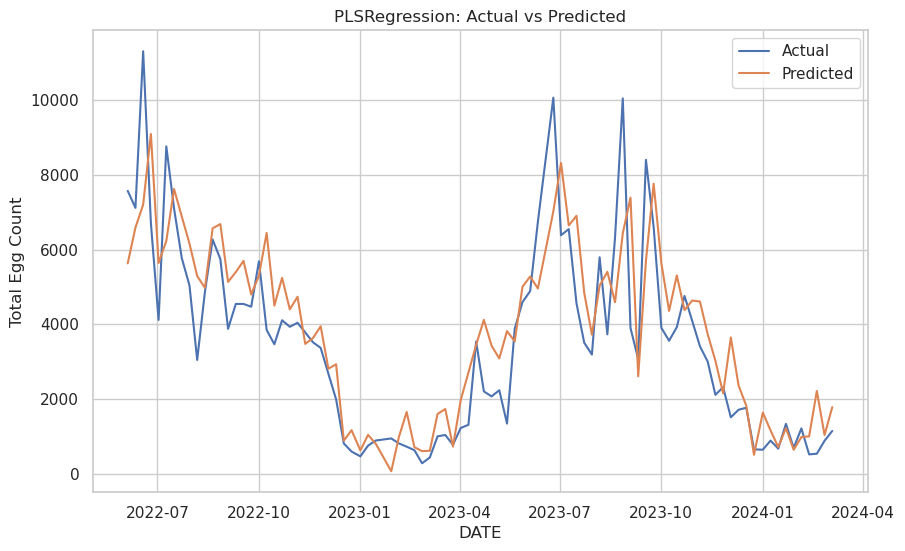

In [784]:
import matplotlib.pyplot as plt

# 获取最佳参数对应的模型
best_params = history[0][0]
best_n_components = best_params['n_components']
best_pls = PLSRegression(n_components=best_n_components)
best_pls.fit(train_x_scale, train_y)

# 对验证集进行预测
pred_val = best_pls.predict(val_x_scale)[:, 0]

# 可视化预测结果与真实值
plt.figure(figsize=(10, 6))
plt.plot(val_data['觀測時間(day)'], val_y, label='Actual')
plt.plot(val_data['觀測時間(day)'], pred_val, label='Predicted')
plt.title('PLSRegression: Actual vs Predicted')
plt.xlabel('DATE')
plt.ylabel('Total Egg Count')
plt.legend()
plt.show()


# ridge model

In [288]:
from sklearn.linear_model import Ridge

In [289]:
param_space = {
    'alpha': hp.loguniform('alpha', np.log(1e-1), np.log(1e1)),
}

def score(space):
    params = {
        'alpha': space['alpha'],
    }
    clf = Ridge(**params)
    clf.fit(train_x_scale, train_y)
    pred = clf.predict(val_x_scale)
    score = mean_squared_error(val_y, pred, squared=False)

    history.append((clf.get_params(), score))
    return {'loss': score, 'status': STATUS_OK}

In [235]:
train_data = df_dengue_input[df_dengue_input['觀測時間(day)'] <= '2022-05-31']
val_data = df_dengue_input[df_dengue_input['觀測時間(day)'] > '2022-05-31']

train_x = train_data.drop(columns=['總卵粒數', '觀測時間(day)','陽性率%'])
train_y = train_data['總卵粒數']
val_x = val_data.drop(columns=['總卵粒數', '觀測時間(day)','陽性率%'])
val_y = val_data['總卵粒數']

scaler = MinMaxScaler()
train_x_scale = scaler.fit_transform(train_x)
val_x_scale = scaler.transform(val_x)

max_evals = 100
trials = Trials()
history = []
fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals)
history = sorted(history, key=lambda tpl: tpl[1])
print(f'best params:{history[0][0]}, score:{history[0][1]:.4f}')

100%|██████████| 100/100 [00:00<00:00, 182.17trial/s, best loss: 1327.38015444026]
best params:{'alpha': 0.1297664174403084, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}, score:1327.3802


In [290]:
train_data = df_dengue_input[df_dengue_input['觀測時間(day)'] <= '2022-01-01']
val_data = df_dengue_input[df_dengue_input['觀測時間(day)'] > '2022-01-01']

train_x = train_data.drop(columns=['總卵粒數', '觀測時間(day)','陽性率%'])
train_y = train_data['總卵粒數']
val_x = val_data.drop(columns=['總卵粒數', '觀測時間(day)','陽性率%'])
val_y = val_data['總卵粒數']

scaler = MinMaxScaler()
train_x_scale = scaler.fit_transform(train_x)
val_x_scale = scaler.transform(val_x)

max_evals = 100
trials = Trials()
history = []
fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals)
history = sorted(history, key=lambda tpl: tpl[1])
print(f'best params:{history[0][0]}, score:{history[0][1]:.4f}')

100%|██████████| 100/100 [00:00<00:00, 382.70trial/s, best loss: 1279.8196626594868]
best params:{'alpha': 0.1873795702644173, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}, score:1279.8197


findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of 

findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of 

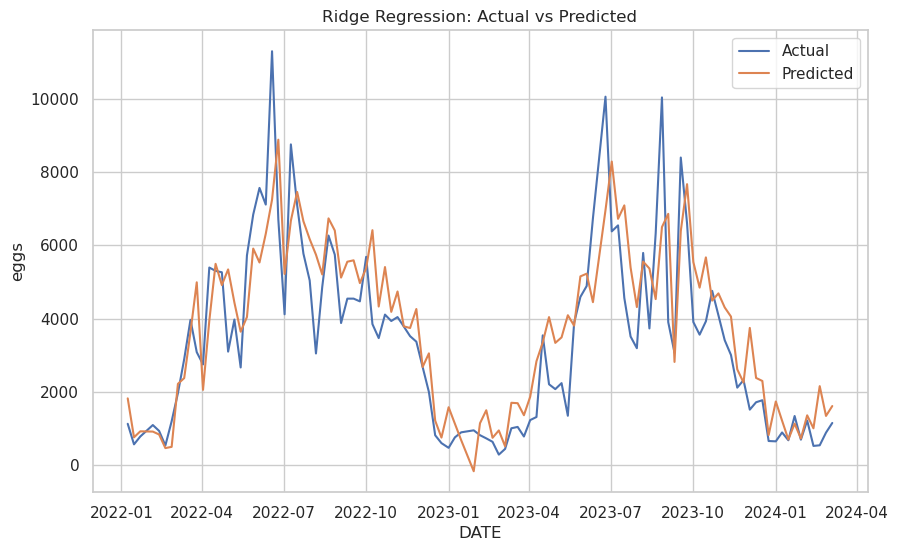

In [291]:
import matplotlib.pyplot as plt

# 获取最佳参数对应的模型
best_params = history[0][0]
best_alpha = best_params['alpha']
best_ridge = Ridge(alpha=best_alpha)
best_ridge.fit(train_x_scale, train_y)

# 对验证集进行预测
pred_val = best_ridge.predict(val_x_scale)
 
# 可视化预测结果与真实值
plt.figure(figsize=(10, 6))
plt.plot(val_data['觀測時間(day)'], val_y, label='Actual')
plt.plot(val_data['觀測時間(day)'], pred_val, label='Predicted')
plt.title('Ridge Regression: Actual vs Predicted')
plt.xlabel('DATE')
plt.ylabel('eggs')
plt.legend()
plt.show()


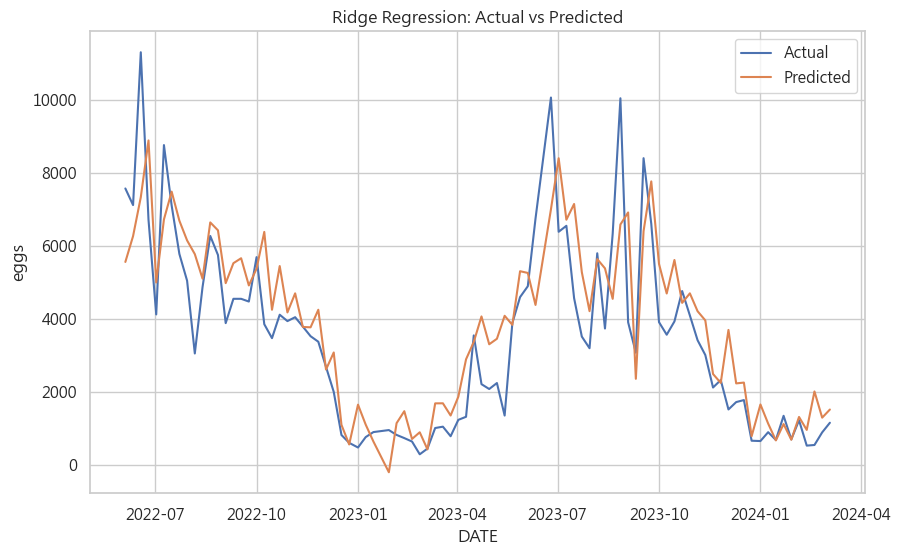

In [236]:
import matplotlib.pyplot as plt

# 获取最佳参数对应的模型
best_params = history[0][0]
best_alpha = best_params['alpha']
best_ridge = Ridge(alpha=best_alpha)
best_ridge.fit(train_x_scale, train_y)

# 对验证集进行预测
pred_val = best_ridge.predict(val_x_scale)
 
# 可视化预测结果与真实值
plt.figure(figsize=(10, 6))
plt.plot(val_data['觀測時間(day)'], val_y, label='Actual')
plt.plot(val_data['觀測時間(day)'], pred_val, label='Predicted')
plt.title('Ridge Regression: Actual vs Predicted')
plt.xlabel('DATE')
plt.ylabel('eggs')
plt.legend()
plt.show()


In [238]:
from sklearn.linear_model import Ridge

param_space = {
    'alpha': hp.loguniform('alpha', np.log(1e-1), np.log(1e1)),
}

def score(space):
    params = {
        'alpha': space['alpha'],
    }
    clf = Ridge(**params)
    clf.fit(train_x_scale, train_y)
    pred = clf.predict(val_x_scale)
    score = mean_squared_error(val_y, pred, squared=False)

    # Get feature importances from Ridge coefficients
    feature_importance = clf.coef_
    feature_names = train_x.columns.tolist()
    fi = dict(zip(feature_names, feature_importance))

    history.append((clf.get_params(), score, fi))
    return {'loss': score, 'status': STATUS_OK}

train_data = df_dengue_input[df_dengue_input['觀測時間(day)'] <= '2022-05-31']
val_data = df_dengue_input[df_dengue_input['觀測時間(day)'] > '2022-05-31']

train_x = train_data.drop(columns=['總卵粒數', '觀測時間(day)', '陽性率%'])
train_y = train_data['總卵粒數']
val_x = val_data.drop(columns=['總卵粒數', '觀測時間(day)', '陽性率%'])
val_y = val_data['總卵粒數']

scaler = MinMaxScaler()
train_x_scale = scaler.fit_transform(train_x)
val_x_scale = scaler.transform(val_x)

max_evals = 100
trials = Trials()
history = []
fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals)
history = sorted(history, key=lambda tpl: tpl[1])
best_params = history[0][0]
best_score = history[0][1]
best_fi = history[0][2]

print(f'Best params: {best_params}, Score: {best_score:.4f}')

# Print feature importance
sorted_fi = sorted(best_fi.items(), key=lambda x: abs(x[1]), reverse=True)
print("Feature Importance:")
for feature, importance in sorted_fi:
    print(f"{feature}: {importance:.4f}")


100%|██████████| 100/100 [00:00<00:00, 393.20trial/s, best loss: 1327.3801161971696]
Best params: {'alpha': 0.13029569081987938, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}, Score: 1327.3801
Feature Importance:
總卵粒數1: 9266.5283
最低氣溫(℃): 5358.1032
總卵粒數3: 3755.0323
日照率(%): -3278.6359
氣溫(℃): 3196.3609
最高氣溫(℃): -3145.8906
相對溼度(%): -3139.2916
總卵粒數2: -3103.9145
日照時數(hour): 2883.5993
最大十分鐘降水量(mm): -2846.1111
最大六十分鐘降水量(mm): 1825.6316
降水時數(hour): -1484.6477
降水量(mm): 1051.7237
最大瞬間風風向(360degree): -617.2057
風向(360degree): 417.9645
風速(m/s): -370.6842
最大瞬間風(m/s): 202.5777
測站氣壓(hPa): 26.1341


# lasso

In [292]:
from sklearn.linear_model import Lasso

In [293]:
param_space = {
    'alpha': hp.loguniform('alpha', np.log(1e-3), np.log(1e3)),
}

def score(space):
    params = {
        'alpha': space['alpha'],
    }
    clf = Lasso(**params)
    clf.fit(train_x_scale, train_y)
    pred = clf.predict(val_x_scale)
    score = mean_squared_error(val_y, pred, squared=False)

    history.append((clf.get_params(), score))
    return {'loss': score, 'status': STATUS_OK}

In [790]:
train_data = df_dengue_input[df_dengue_input['觀測時間(day)'] <= '2022-05-31']
val_data = df_dengue_input[df_dengue_input['觀測時間(day)'] > '2022-05-31']

train_x = train_data.drop(columns=['總卵粒數', '觀測時間(day)','陽性率%'])
train_y = train_data['總卵粒數']
val_x = val_data.drop(columns=['總卵粒數', '觀測時間(day)','陽性率%'])
val_y = val_data['總卵粒數']

scaler = MinMaxScaler()
train_x_scale = scaler.fit_transform(train_x)
val_x_scale = scaler.transform(val_x)

max_evals = 100
trials = Trials()
history = []
fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals)
history = sorted(history, key=lambda tpl: tpl[1])
print(f'best params:{history[0][0]}, score:{history[0][1]:.4f}')

 61%|██████    | 61/100 [00:00<00:00, 227.15trial/s, best loss: 1335.6549309069467]

C:\Users\lilj\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.917e+05, tolerance: 1.106e+05
  model = cd_fast.enet_coordinate_descent(

C:\Users\lilj\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.565e+05, tolerance: 1.106e+05
  model = cd_fast.enet_coordinate_descent(



100%|██████████| 100/100 [00:00<00:00, 226.32trial/s, best loss: 1335.6549309069467]
best params:{'alpha': 1.8405699758965095, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}, score:1335.6549


In [294]:
train_data = df_dengue_input[df_dengue_input['觀測時間(day)'] <= '2022-01-31']
val_data = df_dengue_input[df_dengue_input['觀測時間(day)'] > '2022-01-31']

train_x = train_data.drop(columns=['總卵粒數', '觀測時間(day)','陽性率%'])
train_y = train_data['總卵粒數']
val_x = val_data.drop(columns=['總卵粒數', '觀測時間(day)','陽性率%'])
val_y = val_data['總卵粒數']

scaler = MinMaxScaler()
train_x_scale = scaler.fit_transform(train_x)
val_x_scale = scaler.transform(val_x)

max_evals = 100
trials = Trials()
history = []
fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals)
history = sorted(history, key=lambda tpl: tpl[1])
print(f'best params:{history[0][0]}, score:{history[0][1]:.4f}')

100%|██████████| 100/100 [00:00<00:00, 281.70trial/s, best loss: 1322.4094133681967]
best params:{'alpha': 11.675830027791278, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}, score:1322.4094


C:\Users\lilj\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.482e+05, tolerance: 1.032e+05
  model = cd_fast.enet_coordinate_descent(



findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of 

findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of 

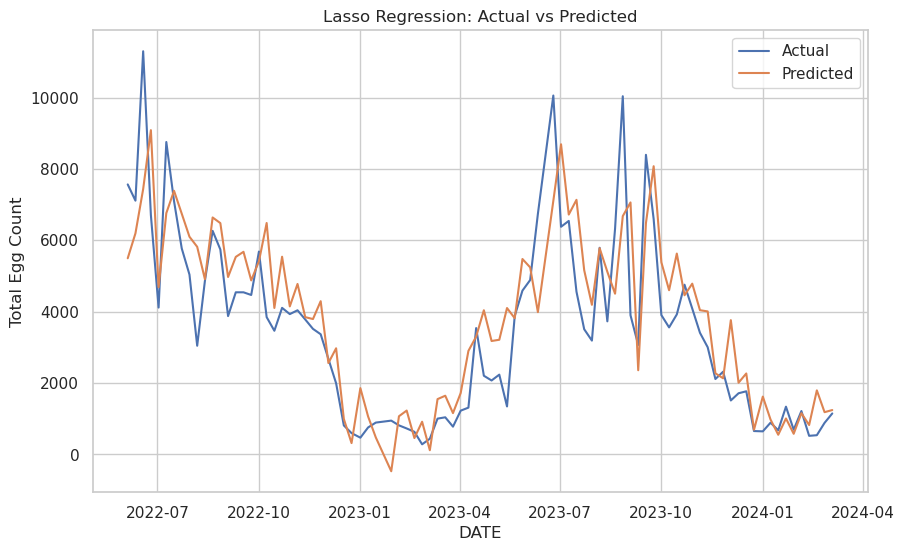

In [792]:
import matplotlib.pyplot as plt

# 获取历史记录中最佳的参数
best_params = history[0][0]
best_alpha = best_params['alpha']

# 使用最佳的 alpha 参数构建 Lasso 模型
best_lasso = Lasso(alpha=best_alpha)
best_lasso.fit(train_x_scale, train_y)

# 在验证集上进行预测
pred_val = best_lasso.predict(val_x_scale)

# 可视化预测结果与真实值
plt.figure(figsize=(10, 6))
plt.plot(val_data['觀測時間(day)'], val_y, label='Actual')
plt.plot(val_data['觀測時間(day)'], pred_val, label='Predicted')
plt.title('Lasso Regression: Actual vs Predicted')
plt.xlabel('DATE')
plt.ylabel('Total Egg Count')
plt.legend()
plt.show()


# elastic net

In [295]:
from sklearn.linear_model import ElasticNet

In [296]:
param_space = {
    'alpha': hp.loguniform('alpha', np.log(1e-3), np.log(1e3)),
    'l1_ratio': hp.quniform('subsample', 0, 1, 0.05),
}

def score(space):
    params = {
        'alpha': space['alpha'],
        'l1_ratio': space['l1_ratio']
    }
    clf = ElasticNet(**params)
    clf.fit(train_x_scale, train_y)
    pred = clf.predict(val_x_scale)
    score = mean_squared_error(val_y, pred, squared=False)

    history.append((clf.get_params(), score))
    return {'loss': score, 'status': STATUS_OK}

In [800]:
train_data = df_dengue_input[df_dengue_input['觀測時間(day)'] <= '2022-05-31']
val_data = df_dengue_input[df_dengue_input['觀測時間(day)'] > '2022-05-31']

train_x = train_data.drop(columns=['總卵粒數', '觀測時間(day)','陽性率%'])
train_y = train_data['總卵粒數']
val_x = val_data.drop(columns=['總卵粒數', '觀測時間(day)','陽性率%'])
val_y = val_data['總卵粒數']


scaler = MinMaxScaler()
train_x_scale = scaler.fit_transform(train_x)
val_x_scale = scaler.transform(val_x)

max_evals = 30
trials = Trials()
history = []
fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals)
history = sorted(history, key=lambda tpl: tpl[1])
print(f'best params:{history[0][0]}, score:{history[0][1]:.4f}')

100%|██████████| 30/30 [00:00<00:00, 371.42trial/s, best loss: 1328.042027260369]
best params:{'alpha': 0.0017508547276465583, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.55, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}, score:1328.0420


In [297]:
train_data = df_dengue_input[df_dengue_input['觀測時間(day)'] <= '2022-01-01']
val_data = df_dengue_input[df_dengue_input['觀測時間(day)'] > '2022-01-01']

train_x = train_data.drop(columns=['總卵粒數', '觀測時間(day)','陽性率%'])
train_y = train_data['總卵粒數']
val_x = val_data.drop(columns=['總卵粒數', '觀測時間(day)','陽性率%'])
val_y = val_data['總卵粒數']


scaler = MinMaxScaler()
train_x_scale = scaler.fit_transform(train_x)
val_x_scale = scaler.transform(val_x)

max_evals = 30
trials = Trials()
history = []
fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals)
history = sorted(history, key=lambda tpl: tpl[1])
print(f'best params:{history[0][0]}, score:{history[0][1]:.4f}')

100%|██████████| 30/30 [00:00<00:00, 364.58trial/s, best loss: 1279.8555290181603]
best params:{'alpha': 0.00474418755222932, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.6000000000000001, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}, score:1279.8555


100%|██████████| 30/30 [00:00<00:00, 358.12trial/s, best loss: 1327.396990433532]

C:\Users\lilj\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.521e+08, tolerance: 1.106e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(

findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn

findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of the following families were found: jf-openhuninn-2.0
findfont: Generic family 'sans-serif' not found because none of 

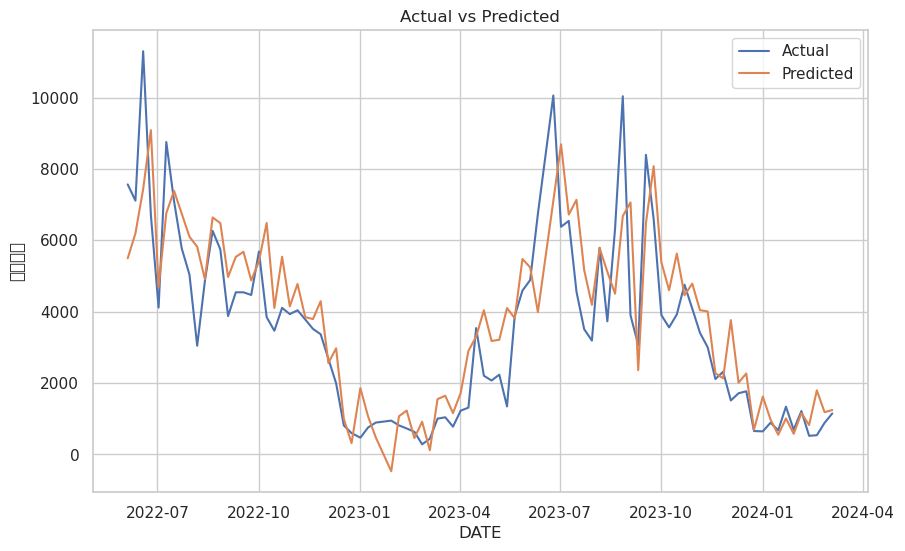

In [801]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
import hyperopt
from hyperopt import fmin, hp, STATUS_OK, Trials

param_space = {
    'alpha': hp.loguniform('alpha', np.log(1e-3), np.log(1e3)),
    'l1_ratio': hp.quniform('l1_ratio', 0, 1, 0.05),
}

# 定义评分函数
def score(space):
    params = {
        'alpha': space['alpha'],
        'l1_ratio': space['l1_ratio']
    }
    clf = ElasticNet(**params)
    clf.fit(train_x_scale, train_y)
    pred = clf.predict(val_x_scale)
    score = mean_squared_error(val_y, pred, squared=False)

    history.append((clf.get_params(), score))
    return {'loss': score, 'status': STATUS_OK}

# 定义数据
train_data = df_dengue_input[df_dengue_input['觀測時間(day)'] <= '2022-05-31']
val_data = df_dengue_input[df_dengue_input['觀測時間(day)'] > '2022-05-31']

train_x = train_data.drop(columns=['總卵粒數', '觀測時間(day)', '陽性率%'])
train_y = train_data['總卵粒數']
val_x = val_data.drop(columns=['總卵粒數', '觀測時間(day)', '陽性率%'])
val_y = val_data['總卵粒數']

scaler = MinMaxScaler()
train_x_scale = scaler.fit_transform(train_x)
val_x_scale = scaler.transform(val_x)

# 参数优化
max_evals = 30
trials = Trials()
history = []
best_params = fmin(score, param_space, algo=hyperopt.tpe.suggest, trials=trials, max_evals=max_evals)

# 获取最佳参数
best_alpha = best_params['alpha']
best_l1_ratio = best_params['l1_ratio']

# 使用最佳参数训练模型
best_clf = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio)
best_clf.fit(train_x_scale, train_y)

# 对验证数据进行预测
pred = best_clf.predict(val_x_scale)

# 可视化预测结果
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(val_data['觀測時間(day)'], val_y, label='Actual')
plt.plot(val_data['觀測時間(day)'], pred_val, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('DATE')
plt.ylabel('總卵粒數')
plt.legend()
plt.show()


# LSTM

In [197]:
df_dengue_input = young_df_weather.copy()

In [202]:
for column in df_dengue_input.columns:
    print(column)
#21欄位    

觀測時間(day)
總卵粒數
總卵粒數1
總卵粒數2
總卵粒數3
陽性率%
氣溫(℃)
測站氣壓(hPa)
最高氣溫(℃)
最低氣溫(℃)
相對溼度(%)
風速(m/s)
風向(360degree)
最大瞬間風(m/s)
最大瞬間風風向(360degree)
降水量(mm)
降水時數(hour)
最大十分鐘降水量(mm)
最大六十分鐘降水量(mm)
日照時數(hour)
日照率(%)


In [201]:
df_dengue_input

觀測時間(day)    總卵粒數   總卵粒數1   總卵粒數2   總卵粒數3    陽性率%  氣溫(℃)  測站氣壓(hPa)  \
3   2020-01-22  1910.0  2775.0  2543.0  2060.0  0.1105   21.7     1017.8   
4   2020-01-29  3513.0  1910.0  2775.0  2543.0  0.1550   14.3     1016.5   
5   2020-02-05   701.0  3513.0  1910.0  2775.0  0.0523   18.3     1018.0   
6   2020-02-12  1398.0   701.0  3513.0  1910.0  0.0853    0.0     1016.5   
7   2020-02-19  1598.0  1398.0   701.0  3513.0  0.1085    0.0     1022.6   
..         ...     ...     ...     ...     ...     ...    ...        ...   
211 2024-02-05  1217.0   693.0  1339.0   677.0  0.0969   20.8     1017.1   
212 2024-02-12   522.0  1217.0   693.0  1339.0  0.0426   17.3     1024.8   
213 2024-02-19   539.0   522.0  1217.0   693.0  0.0446   25.5     1015.2   
214 2024-02-26   885.0   539.0   522.0  1217.0  0.0620   17.6     1019.5   
215 2024-03-04  1149.0   885.0   539.0   522.0  0.0891   22.5     1013.1   

     最高氣溫(℃)  最低氣溫(℃)  ...  風速(m/s)  風向(360degree)  最大瞬間風(m/s)  \
3       28.2     16.8  ...      1.9            360         9.6   
4       18.8     11.9  ...      5.4            360        11.6   
5       25.1     14.4  ...      4.0            360         9.0   
6        0.0      0.0  ...      2.2            200        12.4   
7        0.0      0.0  ...      2.6            350         8.1   
..       ...      ...  ...      ...            ...         ...   
211     27.2     17.5  ...      3.8            360        12.1   
212     23.9     12.8  ...      2.2            360         8.4   
213     31.3     21.0  ...      2.7            250         8.1   
214     23.8     14.4  ...      3.7            360        11.3   
215     27.9     16.3  ...      2.8             10         8.6   

     最大瞬間風風向(360degree)  降水量(mm)  降水時數(hour)  最大十分鐘降水量(mm)  最大六十分鐘降水量(mm)  \
3                 350.0      0.0         0.0           0.0            0.0   
4                 360.0      0.0         0.0           0.0            0.0   
5                 360.0      0.0         0.0           0.0            0.0   
6                 210.0      0.0         0.0           0.0            0.0   
7                 350.0      0.0         0.0           0.0            0.0   
..                  ...      ...         ...           ...            ...   
211               360.0      0.0         0.0           0.0            0.0   
212               320.0      0.0         0.0           0.0            0.0   
213               280.0      0.0         0.0           0.0            0.0   
214               350.0      0.0         0.0           0.0            0.0   
215               150.0      0.0         0.0           0.0            0.0   

     日照時數(hour)  日照率(%)  
3           6.8    62.4  
4           3.6    32.7  
5           9.2    82.7  
6           9.3    82.6  
7          10.0    87.7  
..          ...     ...  
211         2.3    20.6  
212        10.5    93.1  
213         8.9    77.9  
214         3.0    25.9  
215         7.4    63.1  

[213 rows x 21 columns]

In [203]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK


In [204]:
# 訓練集和驗證集的準備
train_data = df_dengue_input[df_dengue_input['觀測時間(day)'] <= '2022-05-31']
val_data = df_dengue_input[df_dengue_input['觀測時間(day)'] > '2022-05-31']

train_x = train_data.drop(columns=['總卵粒數', '觀測時間(day)', '陽性率%'])
train_y = train_data['總卵粒數']
val_x = val_data.drop(columns=['總卵粒數', '觀測時間(day)', '陽性率%'])
val_y = val_data['總卵粒數']

scaler = MinMaxScaler()
train_x_scale = scaler.fit_transform(train_x)
val_x_scale = scaler.transform(val_x)


In [205]:
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=64, input_shape=input_shape))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

n_steps = 3
n_features = 18
input_shape = ( n_steps , n_features )  # Shape for LSTM input ( , )
lstm_model = create_lstm_model(input_shape)


In [208]:
val_x_scale.shape[1]

18

In [213]:
def score(space):
    model = create_lstm_model(input_shape)
    model.fit(train_x_scale.reshape(train_x_scale.shape[0], 3 , 18),
              train_y,
              epochs=50,
              batch_size=32,
              verbose=0,
              validation_split=0.1)  # Using a fraction of training data for validation

    pred = model.predict(val_x_scale.reshape(val_x_scale.shape[0], 3 , 18))
    score = mean_squared_error(val_y, pred, squared=False)
    history.append((space, score))
    return {'loss': score, 'status': STATUS_OK}


In [214]:
param_space = {
    'units': hp.quniform('units', 32, 128, 16),
    'dropout': hp.uniform('dropout', 0.1, 0.5),
    'activation': hp.choice('activation', ['relu', 'tanh'])
}

trials = Trials()
best_params = fmin(score, param_space, algo=tpe.suggest, max_evals=100, trials=trials)

lstm_model = create_lstm_model(input_shape)  # Recreate model with best params
lstm_model.fit(train_x_scale.reshape(train_x_scale.shape[0], 3 , 18),
               train_y,
               epochs=50,
               batch_size=32,
               verbose=0,
               validation_split=0.1)  # Training on entire dataset without early stopping

pred = lstm_model.predict(val_x_scale.reshape(val_x_scale.shape[0], 3 , 18))
rmse = mean_squared_error(val_y, pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# 可視化預測結果
plt.figure(figsize=(10, 6))
plt.plot(val_data['觀測時間(day)'], val_y, label='Actual')
plt.plot(val_data['觀測時間(day)'], pred, label='Predicted')
plt.title('LSTM: Actual vs Predicted')
plt.xlabel('觀測時間(day)')
plt.ylabel('總卵粒數')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

job exception: cannot reshape array of size 2214 into shape (123,3,18)



  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]


ValueError: cannot reshape array of size 2214 into shape (123,3,18)

In [215]:
print(train_x_scale.shape)

(123, 18)


In [216]:
try:
    train_x_reshaped = train_x_scale.reshape(123, 3, 18)
except ValueError as e:
    print("重塑數組失敗：", e)

重塑數組失敗： cannot reshape array of size 2214 into shape (123,3,18)


# 重來LSTM

In [530]:
# 設置顯示的最大行和列數
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [531]:
young_df_weather

觀測時間(day)     總卵粒數    總卵粒數1    總卵粒數2    總卵粒數3    陽性率%  氣溫(℃)  測站氣壓(hPa)  \
3   2020-01-22   1910.0   2775.0   2543.0   2060.0  0.1105   21.7     1017.8   
4   2020-01-29   3513.0   1910.0   2775.0   2543.0  0.1550   14.3     1016.5   
5   2020-02-05    701.0   3513.0   1910.0   2775.0  0.0523   18.3     1018.0   
6   2020-02-12   1398.0    701.0   3513.0   1910.0  0.0853    0.0     1016.5   
7   2020-02-19   1598.0   1398.0    701.0   3513.0  0.1085    0.0     1022.6   
8   2020-02-26   2171.0   1598.0   1398.0    701.0  0.1202   24.1     1016.1   
9   2020-03-04   4046.0   2171.0   1598.0   1398.0  0.1957   21.9     1015.4   
10  2020-03-11   2684.0   4046.0   2171.0   1598.0  0.1550   20.3     1016.2   
11  2020-03-18   2301.0   2684.0   4046.0   2171.0  0.1376   22.2     1014.4   
12  2020-03-25   1869.0   2301.0   2684.0   4046.0  0.1240   24.9     1012.5   
13  2020-04-01   3232.0   1869.0   2301.0   2684.0  0.2326   23.2     1012.9   
14  2020-04-08   2156.0   3232.0   1869.0   2301.0  0.1841   20.8     1013.6   
15  2020-04-15   1795.0   2156.0   3232.0   1869.0  0.1609   22.9     1013.8   
16  2020-04-22   4616.0   1795.0   2156.0   3232.0  0.2674   24.0     1012.7   
17  2020-04-29   5277.0   4616.0   1795.0   2156.0  0.2965   26.0     1014.4   
18  2020-05-06   4799.0   5277.0   4616.0   1795.0  0.2926   29.2     1008.3   
19  2020-05-13   4130.0   4799.0   5277.0   4616.0  0.2364   28.3     1010.8   
20  2020-05-20   1820.0   4130.0   4799.0   5277.0  0.1860   24.8     1007.2   
21  2020-05-27   2644.0   1820.0   4130.0   4799.0  0.2461   26.9     1007.9   
22  2020-06-03   5870.0   2644.0   1820.0   4130.0  0.3992   29.8     1008.5   
23  2020-06-10   6213.0   5870.0   2644.0   1820.0  0.3953   29.7     1008.7   
24  2020-06-17   6871.0   6213.0   5870.0   2644.0  0.4070   30.1     1007.8   
25  2020-06-24  10519.0   6871.0   6213.0   5870.0  0.5329   30.4     1006.0   
26  2020-07-01   6415.0  10519.0   6871.0   6213.0  0.3643   28.4     1005.3   
27  2020-07-08   5133.0   6415.0  10519.0   6871.0  0.3760   30.2     1006.8   
28  2020-07-15   9323.0   5133.0   6415.0  10519.0  0.4845   28.9     1005.5   
29  2020-07-22   6735.0   9323.0   5133.0   6415.0  0.4360   30.0     1008.7   
30  2020-07-29   6743.0   6735.0   9323.0   5133.0  0.4264   27.6     1006.8   
31  2020-08-05   4726.0   6743.0   6735.0   9323.0  0.4109   29.0     1008.8   
32  2020-08-12   7404.0   4726.0   6743.0   6735.0  0.4516   29.4     1011.5   
33  2020-08-19   8370.0   7404.0   4726.0   6743.0  0.4864   29.7     1006.9   
34  2020-08-26   5784.0   8370.0   7404.0   4726.0  0.4186   25.0     1003.3   
35  2020-09-02   4854.0   5784.0   8370.0   7404.0  0.4574   29.7     1005.0   
36  2020-09-09   7321.0   4854.0   5784.0   8370.0  0.4690   29.5     1008.7   
37  2020-09-16   7660.0   7321.0   4854.0   5784.0  0.4380   30.0     1007.6   
38  2020-09-23   5493.0   7660.0   7321.0   4854.0  0.3585   28.5     1008.5   
39  2020-09-30   5591.0   5493.0   7660.0   7321.0  0.3508   27.4     1005.9   
40  2020-10-07   7045.0   5591.0   5493.0   7660.0  0.3682   26.0     1010.9   
41  2020-10-14   4317.0   7045.0   5591.0   5493.0  0.3004   27.9     1011.6   
42  2020-10-21   3700.0   4317.0   7045.0   5591.0  0.2519   26.6     1006.1   
43  2020-10-28   3627.0   3700.0   4317.0   7045.0  0.2461   25.4     1012.9   
44  2020-11-04   3065.0   3627.0   3700.0   4317.0  0.2190   24.1     1013.8   
45  2020-11-11   1713.0   3065.0   3627.0   3700.0  0.1531   22.3     1016.3   
46  2020-11-18   2232.0   1713.0   3065.0   3627.0  0.1802   25.1     1011.5   
47  2020-11-25   4773.0   2232.0   1713.0   3065.0  0.3256   24.5     1016.0   
48  2020-12-02   5230.0   4773.0   2232.0   1713.0  0.3043   21.5     1015.0   
49  2020-12-09   2705.0   5230.0   4773.0   2232.0  0.2151   20.6     1013.9   
50  2020-12-16   2228.0   2705.0   5230.0   4773.0  0.1686   18.9     1018.6   
51  2020-12-23   1342.0   2228.0   2705.0   5230.0  0.1240   19.7     1013.7   
52  2

In [425]:
young_df_weather.copy()

觀測時間(day)    總卵粒數   總卵粒數1   總卵粒數2   總卵粒數3    陽性率%  氣溫(℃)  測站氣壓(hPa)  \
3   2020-01-22  1910.0  2775.0  2543.0  2060.0  0.1105   21.7     1017.8   
4   2020-01-29  3513.0  1910.0  2775.0  2543.0  0.1550   14.3     1016.5   
5   2020-02-05   701.0  3513.0  1910.0  2775.0  0.0523   18.3     1018.0   
6   2020-02-12  1398.0   701.0  3513.0  1910.0  0.0853    0.0     1016.5   
7   2020-02-19  1598.0  1398.0   701.0  3513.0  0.1085    0.0     1022.6   
..         ...     ...     ...     ...     ...     ...    ...        ...   
211 2024-02-05  1217.0   693.0  1339.0   677.0  0.0969   20.8     1017.1   
212 2024-02-12   522.0  1217.0   693.0  1339.0  0.0426   17.3     1024.8   
213 2024-02-19   539.0   522.0  1217.0   693.0  0.0446   25.5     1015.2   
214 2024-02-26   885.0   539.0   522.0  1217.0  0.0620   17.6     1019.5   
215 2024-03-04  1149.0   885.0   539.0   522.0  0.0891   22.5     1013.1   

     最高氣溫(℃)  最低氣溫(℃)  ...  風速(m/s)  風向(360degree)  最大瞬間風(m/s)  \
3       28.2     16.8  ...      1.9            360         9.6   
4       18.8     11.9  ...      5.4            360        11.6   
5       25.1     14.4  ...      4.0            360         9.0   
6        0.0      0.0  ...      2.2            200        12.4   
7        0.0      0.0  ...      2.6            350         8.1   
..       ...      ...  ...      ...            ...         ...   
211     27.2     17.5  ...      3.8            360        12.1   
212     23.9     12.8  ...      2.2            360         8.4   
213     31.3     21.0  ...      2.7            250         8.1   
214     23.8     14.4  ...      3.7            360        11.3   
215     27.9     16.3  ...      2.8             10         8.6   

     最大瞬間風風向(360degree)  降水量(mm)  降水時數(hour)  最大十分鐘降水量(mm)  最大六十分鐘降水量(mm)  \
3                 350.0      0.0         0.0           0.0            0.0   
4                 360.0      0.0         0.0           0.0            0.0   
5                 360.0      0.0         0.0           0.0            0.0   
6                 210.0      0.0         0.0           0.0            0.0   
7                 350.0      0.0         0.0           0.0            0.0   
..                  ...      ...         ...           ...            ...   
211               360.0      0.0         0.0           0.0            0.0   
212               320.0      0.0         0.0           0.0            0.0   
213               280.0      0.0         0.0           0.0            0.0   
214               350.0      0.0         0.0           0.0            0.0   
215               150.0      0.0         0.0           0.0            0.0   

     日照時數(hour)  日照率(%)  
3           6.8    62.4  
4           3.6    32.7  
5           9.2    82.7  
6           9.3    82.6  
7          10.0    87.7  
..          ...     ...  
211         2.3    20.6  
212        10.5    93.1  
213         8.9    77.9  
214         3.0    25.9  
215         7.4    63.1  

[213 rows x 21 columns]

In [426]:
df = young_df_weather.copy()
df

觀測時間(day)    總卵粒數   總卵粒數1   總卵粒數2   總卵粒數3    陽性率%  氣溫(℃)  測站氣壓(hPa)  \
3   2020-01-22  1910.0  2775.0  2543.0  2060.0  0.1105   21.7     1017.8   
4   2020-01-29  3513.0  1910.0  2775.0  2543.0  0.1550   14.3     1016.5   
5   2020-02-05   701.0  3513.0  1910.0  2775.0  0.0523   18.3     1018.0   
6   2020-02-12  1398.0   701.0  3513.0  1910.0  0.0853    0.0     1016.5   
7   2020-02-19  1598.0  1398.0   701.0  3513.0  0.1085    0.0     1022.6   
..         ...     ...     ...     ...     ...     ...    ...        ...   
211 2024-02-05  1217.0   693.0  1339.0   677.0  0.0969   20.8     1017.1   
212 2024-02-12   522.0  1217.0   693.0  1339.0  0.0426   17.3     1024.8   
213 2024-02-19   539.0   522.0  1217.0   693.0  0.0446   25.5     1015.2   
214 2024-02-26   885.0   539.0   522.0  1217.0  0.0620   17.6     1019.5   
215 2024-03-04  1149.0   885.0   539.0   522.0  0.0891   22.5     1013.1   

     最高氣溫(℃)  最低氣溫(℃)  ...  風速(m/s)  風向(360degree)  最大瞬間風(m/s)  \
3       28.2     16.8  ...      1.9            360         9.6   
4       18.8     11.9  ...      5.4            360        11.6   
5       25.1     14.4  ...      4.0            360         9.0   
6        0.0      0.0  ...      2.2            200        12.4   
7        0.0      0.0  ...      2.6            350         8.1   
..       ...      ...  ...      ...            ...         ...   
211     27.2     17.5  ...      3.8            360        12.1   
212     23.9     12.8  ...      2.2            360         8.4   
213     31.3     21.0  ...      2.7            250         8.1   
214     23.8     14.4  ...      3.7            360        11.3   
215     27.9     16.3  ...      2.8             10         8.6   

     最大瞬間風風向(360degree)  降水量(mm)  降水時數(hour)  最大十分鐘降水量(mm)  最大六十分鐘降水量(mm)  \
3                 350.0      0.0         0.0           0.0            0.0   
4                 360.0      0.0         0.0           0.0            0.0   
5                 360.0      0.0         0.0           0.0            0.0   
6                 210.0      0.0         0.0           0.0            0.0   
7                 350.0      0.0         0.0           0.0            0.0   
..                  ...      ...         ...           ...            ...   
211               360.0      0.0         0.0           0.0            0.0   
212               320.0      0.0         0.0           0.0            0.0   
213               280.0      0.0         0.0           0.0            0.0   
214               350.0      0.0         0.0           0.0            0.0   
215               150.0      0.0         0.0           0.0            0.0   

     日照時數(hour)  日照率(%)  
3           6.8    62.4  
4           3.6    32.7  
5           9.2    82.7  
6           9.3    82.6  
7          10.0    87.7  
..          ...     ...  
211         2.3    20.6  
212        10.5    93.1  
213         8.9    77.9  
214         3.0    25.9  
215         7.4    63.1  

[213 rows x 21 columns]

In [476]:
look_df = df.copy()
#look_df = look_df.iloc[160:,:]
#look_df

In [427]:
df.set_index(['觀測時間(day)'], inplace=True)
#df

In [428]:
df = df.drop(columns=['總卵粒數1', '總卵粒數2', '總卵粒數3', '陽性率%'])
df

總卵粒數  氣溫(℃)  測站氣壓(hPa)  最高氣溫(℃)  最低氣溫(℃)  相對溼度(%)  風速(m/s)  \
觀測時間(day)                                                                  
2020-01-22  1910.0   21.7     1017.8     28.2     16.8     70.0      1.9   
2020-01-29  3513.0   14.3     1016.5     18.8     11.9     67.0      5.4   
2020-02-05   701.0   18.3     1018.0     25.1     14.4     73.0      4.0   
2020-02-12  1398.0    0.0     1016.5      0.0      0.0      0.0      2.2   
2020-02-19  1598.0    0.0     1022.6      0.0      0.0      0.0      2.6   
...            ...    ...        ...      ...      ...      ...      ...   
2024-02-05  1217.0   20.8     1017.1     27.2     17.5     82.0      3.8   
2024-02-12   522.0   17.3     1024.8     23.9     12.8     67.0      2.2   
2024-02-19   539.0   25.5     1015.2     31.3     21.0     72.0      2.7   
2024-02-26   885.0   17.6     1019.5     23.8     14.4     69.0      3.7   
2024-03-04  1149.0   22.5     1013.1     27.9     16.3     70.0      2.8   

            風向(360degree)  最大瞬間風(m/s)  最大瞬間風風向(360degree)  降水量(mm)  \
觀測時間(day)                                                            
2020-01-22            360         9.6               350.0      0.0   
2020-01-29            360        11.6               360.0      0.0   
2020-02-05            360         9.0               360.0      0.0   
2020-02-12            200        12.4               210.0      0.0   
2020-02-19            350         8.1               350.0      0.0   
...                   ...         ...                 ...      ...   
2024-02-05            360        12.1               360.0      0.0   
2024-02-12            360         8.4               320.0      0.0   
2024-02-19            250         8.1               280.0      0.0   
2024-02-26            360        11.3               350.0      0.0   
2024-03-04             10         8.6               150.0      0.0   

            降水時數(hour)  最大十分鐘降水量(mm)  最大六十分鐘降水量(mm)  日照時數(hour)  日照率(%)  
觀測時間(day)                                                                
2020-01-22         0.0           0.0            0.0         6.8    62.4  
2020-01-29         0.0           0.0            0.0         3.6    32.7  
2020-02-05         0.0           0.0            0.0         9.2    82.7  
2020-02-12         0.0           0.0            0.0         9.3    82.6  
2020-02-19         0.0           0.0            0.0        10.0    87.7  
...                ...           ...            ...         ...     ...  
2024-02-05         0.0           0.0            0.0         2.3    20.6  
2024-02-12         0.0           0.0            0.0        10.5    93.1  
2024-02-19         0.0           0.0            0.0         8.9    77.9  
2024-02-26         0.0           0.0            0.0         3.0    25.9  
2024-03-04         0.0           0.0            0.0         7.4    63.1  

[213 rows x 16 columns]

In [429]:
#先拆分
train = df[0:176]
test = df[176:]

In [430]:
#正規化(正規化存在scaler裡)

scaler = MinMaxScaler()
#scaler.fit(train)

train = pd.DataFrame(scaler.fit_transform(train), columns=df.columns)
test = pd.DataFrame(scaler.fit_transform(test), columns=df.columns)

In [431]:
#看一下正規化後長怎樣
train

總卵粒數     氣溫(℃)  測站氣壓(hPa)   最高氣溫(℃)   最低氣溫(℃)   相對溼度(%)   風速(m/s)  \
0    0.086681  0.700000   0.760000  0.803419  0.595745  0.729167  0.081967   
1    0.171303  0.461290   0.720000  0.535613  0.421986  0.697917  0.655738   
2    0.022858  0.590323   0.766154  0.715100  0.510638  0.760417  0.426230   
3    0.059653  0.000000   0.720000  0.000000  0.000000  0.000000  0.131148   
4    0.070211  0.000000   0.907692  0.000000  0.000000  0.000000  0.196721   
..        ...       ...        ...       ...       ...       ...       ...   
171  0.056908  0.825806   0.510769  0.831909  0.836879  0.802083  0.147541   
172  0.190783  0.945161   0.507692  0.951567  0.911348  0.791667  0.213115   
173  0.228264  0.919355   0.443077  0.928775  0.918440  0.822917  0.180328   
174  0.243942  0.958065   0.480000  0.980057  0.946809  0.812500  0.163934   
175  0.341815  0.929032   0.255385  0.914530  0.890071  0.895833  0.049180   

     風向(360degree)  最大瞬間風(m/s)  最大瞬間風風向(360degree)  降水量(mm)  降水時數(hour)  \
0         1.000000    0.482412            0.972222  0.00000    0.000000   
1         1.000000    0.582915            1.000000  0.00000    0.000000   
2         1.000000    0.452261            1.000000  0.00000    0.000000   
3         0.542857    0.623116            0.583333  0.00000    0.000000   
4         0.971429    0.407035            0.972222  0.00000    0.000000   
..             ...         ...                 ...      ...         ...   
171       0.914286    0.407035            0.916667  0.00000    0.017544   
172       0.571429    0.427136            0.722222  0.00000    0.000000   
173       0.885714    0.457286            0.833333  0.00000    0.000000   
174       0.885714    0.487437            0.833333  0.00000    0.000000   
175       0.371429    0.432161            0.666667  0.12594    0.087719   

     最大十分鐘降水量(mm)  最大六十分鐘降水量(mm)  日照時數(hour)    日照率(%)  
0        0.000000        0.00000    0.566667  0.663124  
1        0.000000        0.00000    0.300000  0.347503  
2        0.000000        0.00000    0.766667  0.878852  
3        0.000000        0.00000    0.775000  0.877790  
4        0.000000        0.00000    0.833333  0.931987  
..            ...            ...         ...       ...  
171      0.000000        0.00000    0.000000  0.000000  
172      0.000000        0.00000    0.833333  0.799150  
173      0.000000        0.00000    0.708333  0.674814  
174      0.000000        0.00000    0.550000  0.521785  
175      0.603774        0.42446    0.158333  0.149841  

[176 rows x 16 columns]

In [532]:
import tqdm
n = 3   #LSTM 處理的時間步
feature_names = list(train.drop('總卵粒數', axis=1).columns)

X = []
y = []
indexes = []

norm_data_x = train[feature_names]
for i in tqdm.tqdm_notebook(range(0,len(train)-n)): 
    X.append(norm_data_x.iloc[i:i+n].values) 
    y.append(train['總卵粒數'].iloc[i+n]) #現有資料+3天的Y
    indexes.append(train.index[i+n]) #Y的日期

C:\Users\lilj\AppData\Local\Temp\ipykernel_10200\2148677817.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(0,len(train)-n)):


  0%|          | 0/173 [00:00<?, ?it/s]

In [443]:
print(X[0])
print(y[0])

[[0.7        0.76       0.8034188  0.59574468 0.72916667 0.08196721
  1.         0.48241206 0.97222222 0.         0.         0.
  0.         0.56666667 0.66312434]
 [0.46129032 0.72       0.53561254 0.42198582 0.69791667 0.6557377
  1.         0.58291457 1.         0.         0.         0.
  0.         0.3        0.34750266]
 [0.59032258 0.76615385 0.71509972 0.5106383  0.76041667 0.42622951
  1.         0.45226131 1.         0.         0.         0.
  0.         0.76666667 0.87885228]]
0.05965264213693713


In [444]:
X=np.array(X) 
y=np.array(y)
print(X.shape)
print(y.shape)

(173, 3, 15)
(173,)


In [445]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras.backend as K

In [456]:
n_steps = 3
n_features = 15
model = Sequential()
model.add(LSTM(50,activation='relu', return_sequences=False, input_shape = (n_steps, n_features)))
#input_shape = (n_steps, n_features)  幾步, 幾個特徵
#return_sequences預設false，輸出是否為序列? 是: 輸出多個值
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse' , metrics=['mse','mape'])

In [457]:
history = model.fit(X,y,batch_size=100,epochs=100)

Epoch 1/100
2/2 [==============================] - 1s 4ms/step - loss: 0.0483 - mse: 0.0483 - mape: 34474.1602
Epoch 2/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0292 - mse: 0.0292 - mape: 298996.5312
Epoch 3/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0199 - mse: 0.0199 - mape: 462632.4688
Epoch 4/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0178 - mse: 0.0178 - mape: 886403.6875
Epoch 5/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0199 - mse: 0.0199 - mape: 973998.1250
Epoch 6/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0214 - mse: 0.0214 - mape: 1050472.5000
Epoch 7/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0203 - mse: 0.0203 - mape: 971280.1875
Epoch 8/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0179 - mse: 0.0179 - mape: 849869.1250
Epoch 9/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0160 - mse: 0.0160 - mape: 7793

In [459]:
# 從 history 中提取 MSE
mse_history = history.history['mse']

# 將 MSE 轉換為 RMSE
rmse_history = np.sqrt(mse_history)

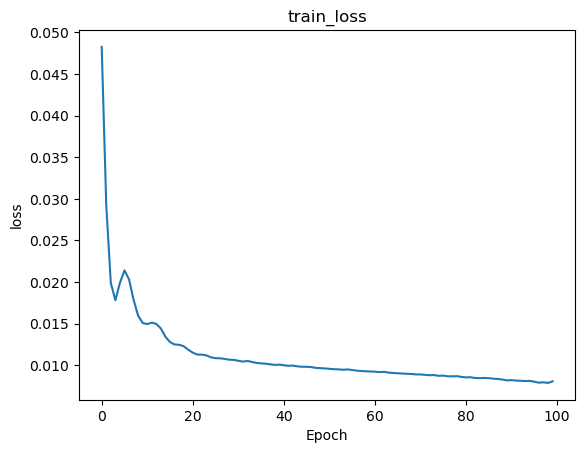

In [458]:
plt.title('train_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.plot(history.history["loss"])

In [460]:
rmse_history

array([0.21966372, 0.17098178, 0.14105147, 0.13350479, 0.14108502,
       0.14631296, 0.14259952, 0.13371103, 0.1263368 , 0.12285171,
       0.12230358, 0.1230131 , 0.12237281, 0.12009134, 0.11588214,
       0.1131057 , 0.11184453, 0.11167357, 0.11090342, 0.10899774,
       0.10734059, 0.10628472, 0.10626513, 0.10580303, 0.10470694,
       0.10423063, 0.10415848, 0.10380823, 0.10335447, 0.10322528,
       0.10271414, 0.10222643, 0.10264149, 0.1020024 , 0.10147121,
       0.10119131, 0.10100022, 0.10060024, 0.10027263, 0.1004403 ,
       0.1000518 , 0.09974215, 0.09983649, 0.09938964, 0.0991559 ,
       0.09913224, 0.0989681 , 0.09848387, 0.09830853, 0.09814186,
       0.09789375, 0.09764764, 0.0975741 , 0.09731128, 0.0975196 ,
       0.0971934 , 0.09673855, 0.0965564 , 0.0963612 , 0.09625903,
       0.09613308, 0.09585536, 0.0960414 , 0.09552992, 0.09532327,
       0.09512352, 0.09496076, 0.09478677, 0.0946741 , 0.09440361,
       0.09438722, 0.09412136, 0.09388959, 0.09397365, 0.09351

In [474]:
#X_test

In [475]:
#len(X_test)

In [ ]:
#以下為 將預測值反轉回正常值 最後拿來做正常值的RMSE

In [463]:
# Step 1: Make predictions
X_test = []
norm_data_x_test = test[feature_names]
for i in range(0, len(test) - n):
    X_test.append(norm_data_x_test.iloc[i:i+n].values)
    
X_test = np.array(X_test)

predicted_values = model.predict(X_test)

2/2 [==============================] - 0s 2ms/step


In [464]:
predicted_values #標準化的值

array([[ 0.26910222],
       [ 0.3079369 ],
       [ 0.33305818],
       [ 0.3246884 ],
       [ 0.29540372],
       [ 0.36135668],
       [ 0.3151438 ],
       [ 0.3462399 ],
       [ 0.31522313],
       [ 0.3568369 ],
       [ 0.44792727],
       [ 0.26305115],
       [ 0.25421077],
       [ 0.21147145],
       [ 0.1628849 ],
       [ 0.12854145],
       [ 0.10536384],
       [ 0.14917676],
       [ 0.11140627],
       [ 0.07752427],
       [ 0.0568669 ],
       [ 0.01987235],
       [ 0.05820564],
       [ 0.02126464],
       [-0.01085661],
       [-0.01586344],
       [-0.00634396],
       [-0.01066885],
       [-0.03992805],
       [-0.05048787],
       [-0.05068943],
       [-0.01628736],
       [ 0.03648879],
       [ 0.01990997]], dtype=float32)

In [465]:
predicted_values.shape

(34, 1)

In [466]:
# 將預測值重複16次以匹配特徵數量 (轉回正常值) 
predicted_values = np.repeat(predicted_values, 16, axis=1)

In [467]:
predicted_values

array([[ 0.26910222,  0.26910222,  0.26910222,  0.26910222,  0.26910222,
         0.26910222,  0.26910222,  0.26910222,  0.26910222,  0.26910222,
         0.26910222,  0.26910222,  0.26910222,  0.26910222,  0.26910222,
         0.26910222],
       [ 0.3079369 ,  0.3079369 ,  0.3079369 ,  0.3079369 ,  0.3079369 ,
         0.3079369 ,  0.3079369 ,  0.3079369 ,  0.3079369 ,  0.3079369 ,
         0.3079369 ,  0.3079369 ,  0.3079369 ,  0.3079369 ,  0.3079369 ,
         0.3079369 ],
       [ 0.33305818,  0.33305818,  0.33305818,  0.33305818,  0.33305818,
         0.33305818,  0.33305818,  0.33305818,  0.33305818,  0.33305818,
         0.33305818,  0.33305818,  0.33305818,  0.33305818,  0.33305818,
         0.33305818],
       [ 0.3246884 ,  0.3246884 ,  0.3246884 ,  0.3246884 ,  0.3246884 ,
         0.3246884 ,  0.3246884 ,  0.3246884 ,  0.3246884 ,  0.3246884 ,
         0.3246884 ,  0.3246884 ,  0.3246884 ,  0.3246884 ,  0.3246884 ,
         0.3246884 ],
       [ 0.29540372,  0.29540372,  0

In [418]:
predicted_values.shape

(34, 16)

In [362]:
#predict = predicted_values.copy()

In [419]:
#predict = predict[:, 0].reshape(-1, 1)
#predict

In [364]:
#predicted_values = predicted_values.reshape(-1, 1)

In [420]:
# Step 2: Inverse transform the predicted values
#predicted_values = predicted_values.reshape(-1, 1)

In [468]:
predicted_values = scaler.inverse_transform(predicted_values)

In [469]:
predicted_values  #已經還原成真實值

array([[ 3.08896606e+03,  2.04019814e+01,  1.00082654e+03,
         2.47328796e+01,  1.69325466e+01,  7.16112671e+01,
         2.21494746e+00,  1.04185776e+02,  9.69068813e+00,
         1.04185776e+02,  1.25132532e+01,  3.01394486e+00,
         2.96012449e+00,  8.20761776e+00,  3.09467554e+00,
         2.52148781e+01],
       [ 3.45941016e+03,  2.09650841e+01,  1.00210034e+03,
         2.52571487e+01,  1.75577850e+01,  7.28539810e+01,
         2.34698558e+00,  1.17777916e+02,  1.01800051e+01,
         1.17777916e+02,  1.43190660e+01,  3.44889331e+00,
         3.38730597e+00,  9.39207554e+00,  3.54127455e+00,
         2.88536873e+01],
       [ 3.69904199e+03,  2.13293438e+01,  1.00292432e+03,
         2.55962849e+01,  1.79622364e+01,  7.36578598e+01,
         2.43239784e+00,  1.26570358e+02,  1.04965334e+01,
         1.26570358e+02,  1.54872055e+01,  3.73025155e+00,
         3.66364002e+00,  1.01582747e+01,  3.83016896e+00,
         3.12075520e+01],
       [ 3.61920288e+03,  2.12079811e

In [470]:
predicted_values.shape

(34, 16)

In [471]:
P_d = predicted_values.copy()

In [472]:
new_df = pd.DataFrame(P_d[:, 0], columns=['預測出的卵粒數'])

In [473]:
new_df

預測出的卵粒數
0   3088.966064
1   3459.410156
2   3699.041992
3   3619.202881
4   3339.856201
5   3968.981445
6   3528.156738
7   3824.782471
8   3528.913574
9   3925.867188
10  4794.777832
11  3031.245117
12  2946.916504
13  2539.226074
14  2075.759033
15  1748.156860
16  1527.065674
17  1944.997070
18  1584.704468
19  1261.504028
20  1064.453247
21   711.562317
22  1077.223511
23   724.843384
24   418.438782
25   370.678619
26   461.484985
27   420.229828
28   141.126343
29    40.396191
30    38.473503
31   366.634857
32   870.066528
33   711.921204

In [477]:
look_df .shape

(213, 16)

In [ ]:
look_df = look_df.iloc[-34:]

In [478]:
last_34_rows = look_df.iloc[-34:]

               總卵粒數  氣溫(℃)  測站氣壓(hPa)  最高氣溫(℃)  最低氣溫(℃)  相對溼度(%)  風速(m/s)  \
觀測時間(day)                                                                   
2023-07-16   4563.0   29.5     1000.3     33.2     26.9     80.0      2.0   
2023-07-23   3510.0   29.4     1009.2     34.2     27.2     85.0      2.3   
2023-07-30   3191.0   28.2     1006.2     32.8     25.7     88.0      2.5   
2023-08-06   5793.0   29.8     1001.8     31.4     28.7     86.0      3.9   
2023-08-13   3731.0   28.4     1005.1     31.8     26.4     88.0      3.0   
2023-08-20   6329.0   29.5     1008.3     33.5     26.0     78.0      2.4   
2023-08-27  10041.0   28.9     1003.0     33.3     26.2     78.0      1.4   
2023-09-03   3902.0   27.7      992.0     28.8     25.7     91.0      3.6   
2023-09-10   3069.0   25.8     1006.7     27.7     23.9     95.0      3.6   
2023-09-17   8399.0   29.5     1010.1     33.2     27.1     76.0      1.7   
2023-09-24   6598.0   30.0     1008.8     33.4     27.5     78.0      2.5   

In [480]:
last_34_rows.shape

(34, 16)

In [490]:
new_df

預測出的卵粒數
0   3088.966064
1   3459.410156
2   3699.041992
3   3619.202881
4   3339.856201
5   3968.981445
6   3528.156738
7   3824.782471
8   3528.913574
9   3925.867188
10  4794.777832
11  3031.245117
12  2946.916504
13  2539.226074
14  2075.759033
15  1748.156860
16  1527.065674
17  1944.997070
18  1584.704468
19  1261.504028
20  1064.453247
21   711.562317
22  1077.223511
23   724.843384
24   418.438782
25   370.678619
26   461.484985
27   420.229828
28   141.126343
29    40.396191
30    38.473503
31   366.634857
32   870.066528
33   711.921204

In [491]:
df_34_ = young_df_weather.copy()

In [493]:
df_34_ = df_34_[-34:]

In [494]:
df_34_

觀測時間(day)     總卵粒數    總卵粒數1    總卵粒數2    總卵粒數3    陽性率%  氣溫(℃)  測站氣壓(hPa)  \
182 2023-07-16   4563.0   6546.0   6382.0  10061.0  0.3198   29.5     1000.3   
183 2023-07-23   3510.0   4563.0   6546.0   6382.0  0.2926   29.4     1009.2   
184 2023-07-30   3191.0   3510.0   4563.0   6546.0  0.3043   28.2     1006.2   
185 2023-08-06   5793.0   3191.0   3510.0   4563.0  0.3779   29.8     1001.8   
186 2023-08-13   3731.0   5793.0   3191.0   3510.0  0.3120   28.4     1005.1   
187 2023-08-20   6329.0   3731.0   5793.0   3191.0  0.4438   29.5     1008.3   
188 2023-08-27  10041.0   6329.0   3731.0   5793.0  0.5213   28.9     1003.0   
189 2023-09-03   3902.0  10041.0   6329.0   3731.0  0.3120   27.7      992.0   
190 2023-09-10   3069.0   3902.0  10041.0   6329.0  0.2694   25.8     1006.7   
191 2023-09-17   8399.0   3069.0   3902.0  10041.0  0.4826   29.5     1010.1   
192 2023-09-24   6598.0   8399.0   3069.0   3902.0  0.4109   30.0     1008.8   
193 2023-10-01   3906.0   6598.0   8399.0   3069.0  0.3004   29.9     1007.0   
194 2023-10-08   3561.0   3906.0   6598.0   8399.0  0.2849   27.3     1011.5   
195 2023-10-15   3925.0   3561.0   3906.0   6598.0  0.2965   26.4     1011.6   
196 2023-10-22   4758.0   3925.0   3561.0   3906.0  0.3101   26.7     1016.1   
197 2023-10-29   4089.0   4758.0   3925.0   3561.0  0.2597   25.8     1014.0   
198 2023-11-05   3410.0   4089.0   4758.0   3925.0  0.2597   27.0     1013.3   
199 2023-11-12   3005.0   3410.0   4089.0   4758.0  0.2093   24.4     1017.1   
200 2023-11-19   2114.0   3005.0   3410.0   4089.0  0.1667   20.0     1018.4   
201 2023-11-26   2319.0   2114.0   3005.0   3410.0  0.1628   21.9     1017.1   
202 2023-12-03   1513.0   2319.0   2114.0   3005.0  0.1047   21.4     1017.9   
203 2023-12-10   1715.0   1513.0   2319.0   2114.0  0.1143   25.2     1012.5   
204 2023-12-17   1770.0   1715.0   1513.0   2319.0  0.1124   17.6     1021.4   
205 2023-12-24    656.0   1770.0   1715.0   1513.0  0.0523   16.9     1023.7   
206 2024-01-01    647.0    656.0   1770.0   1715.0  0.0484   18.9     1017.7   
207 2024-01-08    890.0    647.0    656.0   1770.0  0.0756   18.8     1017.8   
208 2024-01-15    677.0    890.0    647.0    656.0  0.0581   19.3     1019.6   
209 2024-01-22   1339.0    677.0    890.0    647.0  0.0988   16.5     1019.5   
210 2024-01-29    693.0   1339.0    677.0    890.0  0.0543   18.3     1021.7   
211 2024-02-05   1217.0    693.0   1339.0    677.0  0.0969   20.8     1017.1   
212 2024-02-12    522.0   1217.0    693.0   1339.0  0.0426   17.3     1024.8   
213 2024-02-19    539.0    522.0   1217.0    693.0  0.0446   25.5     1015.2   
214 2024-02-26    885.0    539.0    522.0   1217.0  0.0620   17.6     1019.5   
215 2024-03-04   1149.0    885.0    539.0    522.0  0.0891   22.5     1013.1   

     最高氣溫(℃)  最低氣溫(℃)  ...  風速(m/s)  風向(360degree)  最大瞬間風(m/s)  \
182     33.2     26.9  ...      2.0             20         9.6   
183     34.2     27.2  ...      2.3             40         9.3   
184     32.8     25.7  ...      2.5             10        10.0   
185     31.4     28.7  ...      3.9            260        12.5   
186     31.8     26.4  ...      3.0            150        13.7   
187     33.5     26.0  ...      2.4            240         7.7   
188     33.3     26.2  ...      1.4            120         8.4   
189     28.8     25.7  ...      3.6            130        18.9   
190     27.7     23.9  ...      3.6            200        10.6   
191     33.2     27.1  ...      1.7            320         8.0   
192     33.4     27.5  ...      2.5            300         8.3   
193     34.5     27.5  ...      1.9            160        10.0   
194     32.1     24.8  ...      2.4            350         8.3   
195     30.1     23.9  ...      2.3            360         8.1   
196     31.3     23.5  ...      2.0            340         6.9   
197     29.9     23.2  ...      2.1            360         7.5   
198     32.7     23.2  ...      1.3            320         7.2   
199     29.0    

In [500]:
#columns = ['觀測時間(day)','總卵粒數']
df_34_ = df_34_[['觀測時間(day)','總卵粒數']]

In [501]:
df_34_

觀測時間(day)     總卵粒數
182 2023-07-16   4563.0
183 2023-07-23   3510.0
184 2023-07-30   3191.0
185 2023-08-06   5793.0
186 2023-08-13   3731.0
187 2023-08-20   6329.0
188 2023-08-27  10041.0
189 2023-09-03   3902.0
190 2023-09-10   3069.0
191 2023-09-17   8399.0
192 2023-09-24   6598.0
193 2023-10-01   3906.0
194 2023-10-08   3561.0
195 2023-10-15   3925.0
196 2023-10-22   4758.0
197 2023-10-29   4089.0
198 2023-11-05   3410.0
199 2023-11-12   3005.0
200 2023-11-19   2114.0
201 2023-11-26   2319.0
202 2023-12-03   1513.0
203 2023-12-10   1715.0
204 2023-12-17   1770.0
205 2023-12-24    656.0
206 2024-01-01    647.0
207 2024-01-08    890.0
208 2024-01-15    677.0
209 2024-01-22   1339.0
210 2024-01-29    693.0
211 2024-02-05   1217.0
212 2024-02-12    522.0
213 2024-02-19    539.0
214 2024-02-26    885.0
215 2024-03-04   1149.0

In [502]:
df_34_reset_index = df_34_.reset_index(drop=True)

In [503]:
df_34_reset_index

觀測時間(day)     總卵粒數
0  2023-07-16   4563.0
1  2023-07-23   3510.0
2  2023-07-30   3191.0
3  2023-08-06   5793.0
4  2023-08-13   3731.0
5  2023-08-20   6329.0
6  2023-08-27  10041.0
7  2023-09-03   3902.0
8  2023-09-10   3069.0
9  2023-09-17   8399.0
10 2023-09-24   6598.0
11 2023-10-01   3906.0
12 2023-10-08   3561.0
13 2023-10-15   3925.0
14 2023-10-22   4758.0
15 2023-10-29   4089.0
16 2023-11-05   3410.0
17 2023-11-12   3005.0
18 2023-11-19   2114.0
19 2023-11-26   2319.0
20 2023-12-03   1513.0
21 2023-12-10   1715.0
22 2023-12-17   1770.0
23 2023-12-24    656.0
24 2024-01-01    647.0
25 2024-01-08    890.0
26 2024-01-15    677.0
27 2024-01-22   1339.0
28 2024-01-29    693.0
29 2024-02-05   1217.0
30 2024-02-12    522.0
31 2024-02-19    539.0
32 2024-02-26    885.0
33 2024-03-04   1149.0

In [506]:
new_df

預測出的卵粒數
0   3088.966064
1   3459.410156
2   3699.041992
3   3619.202881
4   3339.856201
5   3968.981445
6   3528.156738
7   3824.782471
8   3528.913574
9   3925.867188
10  4794.777832
11  3031.245117
12  2946.916504
13  2539.226074
14  2075.759033
15  1748.156860
16  1527.065674
17  1944.997070
18  1584.704468
19  1261.504028
20  1064.453247
21   711.562317
22  1077.223511
23   724.843384
24   418.438782
25   370.678619
26   461.484985
27   420.229828
28   141.126343
29    40.396191
30    38.473503
31   366.634857
32   870.066528
33   711.921204

In [507]:
print(new_df.dtypes)

預測出的卵粒數    float32
dtype: object


In [512]:
new_df = new_df.astype('float64')

In [513]:
new_df

預測出的卵粒數
0   3088.966064
1   3459.410156
2   3699.041992
3   3619.202881
4   3339.856201
5   3968.981445
6   3528.156738
7   3824.782471
8   3528.913574
9   3925.867188
10  4794.777832
11  3031.245117
12  2946.916504
13  2539.226074
14  2075.759033
15  1748.156860
16  1527.065674
17  1944.997070
18  1584.704468
19  1261.504028
20  1064.453247
21   711.562317
22  1077.223511
23   724.843384
24   418.438782
25   370.678619
26   461.484985
27   420.229828
28   141.126343
29    40.396191
30    38.473503
31   366.634857
32   870.066528
33   711.921204

In [521]:
print(new_df.dtypes)

預測出的卵粒數    float64
dtype: object


In [514]:
print(df_34_reset_index.dtypes)

觀測時間(day)    datetime64[ns]
總卵粒數                float64
dtype: object


In [525]:
merged_df = pd.concat([df_34_reset_index, new_df], axis=1)

In [526]:
merged_df

觀測時間(day)     總卵粒數      預測出的卵粒數
0  2023-07-16   4563.0  3088.966064
1  2023-07-23   3510.0  3459.410156
2  2023-07-30   3191.0  3699.041992
3  2023-08-06   5793.0  3619.202881
4  2023-08-13   3731.0  3339.856201
5  2023-08-20   6329.0  3968.981445
6  2023-08-27  10041.0  3528.156738
7  2023-09-03   3902.0  3824.782471
8  2023-09-10   3069.0  3528.913574
9  2023-09-17   8399.0  3925.867188
10 2023-09-24   6598.0  4794.777832
11 2023-10-01   3906.0  3031.245117
12 2023-10-08   3561.0  2946.916504
13 2023-10-15   3925.0  2539.226074
14 2023-10-22   4758.0  2075.759033
15 2023-10-29   4089.0  1748.156860
16 2023-11-05   3410.0  1527.065674
17 2023-11-12   3005.0  1944.997070
18 2023-11-19   2114.0  1584.704468
19 2023-11-26   2319.0  1261.504028
20 2023-12-03   1513.0  1064.453247
21 2023-12-10   1715.0   711.562317
22 2023-12-17   1770.0  1077.223511
23 2023-12-24    656.0   724.843384
24 2024-01-01    647.0   418.438782
25 2024-01-08    890.0   370.678619
26 2024-01-15    677.0   461.484985
27 2024-01-22   1339.0   420.229828
28 2024-01-29    693.0   141.126343
29 2024-02-05   1217.0    40.396191
30 2024-02-12    522.0    38.473503
31 2024-02-19    539.0   366.634857
32 2024-02-26    885.0   870.066528
33 2024-03-04   1149.0   711.921204

In [527]:
# 提取實際值和預測值
actual_values = merged_df['總卵粒數']
predicted_values = merged_df['預測出的卵粒數']

# 計算均方根誤差（RMSE）
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print("RMSE:", rmse)

RMSE: 1762.5999448826235


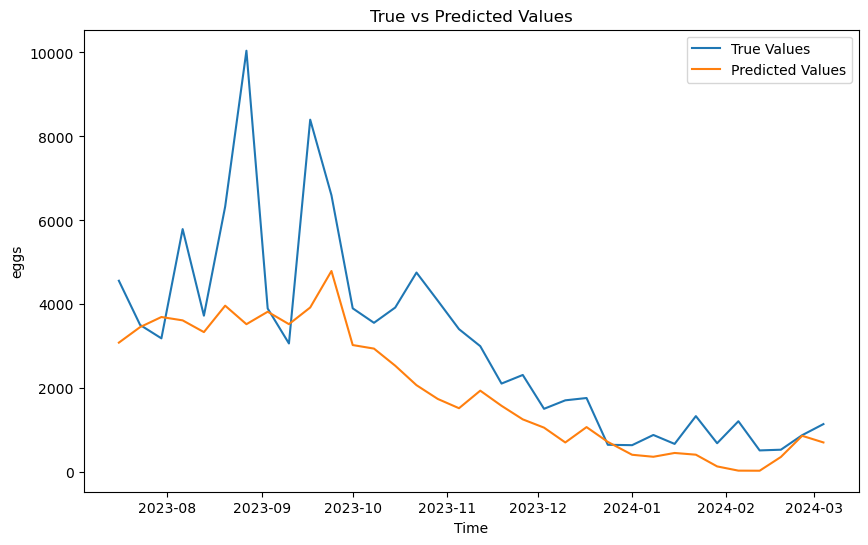

In [529]:
plt.figure(figsize=(10, 6))
plt.plot(merged_df['觀測時間(day)'], merged_df['總卵粒數'], label='True Values')
plt.plot(merged_df['觀測時間(day)'], merged_df['預測出的卵粒數'], label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('eggs')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

C:\Users\lilj\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32317 (\N{CJK UNIFIED IDEOGRAPH-7E3D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\lilj\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21365 (\N{CJK UNIFIED IDEOGRAPH-5375}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\lilj\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31890 (\N{CJK UNIFIED IDEOGRAPH-7C92}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\lilj\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25976 (\N{CJK UNIFIED IDEOGRAPH-6578}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


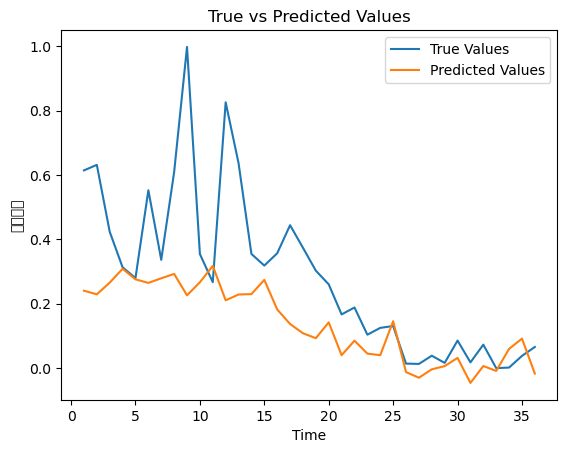

ValueError: Found input variables with inconsistent numbers of samples: [36, 34]

In [291]:
# Step 3: Plot true values against predicted values
import matplotlib.pyplot as plt

true_values = test['總卵粒數'][n:]
plt.plot(true_values.index, true_values, label='True Values')
plt.plot(true_values.index, predicted_values, label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('總卵粒數')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

# Step 4: Calculate RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(true_values, predict))
print("RMSE:", rmse)


In [192]:
# 使用模型對測試數據進行預測
predictions = model.predict(X)

# 將預測結果進行逆轉換還原成原來的數據型態
predictions_original = scaler.inverse_transform(predictions)

# 將逆轉換後的預測結果和實際值組合成 DataFrame
predictions_df = pd.DataFrame(predictions_original, columns=['預測值'])
actual_df = pd.DataFrame(y, columns=['實際值'])

final = pd.concat([predictions_df, actual_df], axis=1)
final['mae'] = abs(final['預測值'] - final['實際值'])

# 可以繼續使用 final DataFrame 進行後續的分析或視覺化
print(final)


2/2 [==============================] - 0s 2ms/step


ValueError: non-broadcastable output operand with shape (34,1) doesn't match the broadcast shape (34,16)

In [193]:
print(predictions.shape)

(34, 1)


In [194]:
print(scaler.min_)

[-5.47227173e-02 -1.13793103e+00 -3.02439024e+01 -1.56296296e+00
 -7.82608696e-01 -1.96875000e+00 -3.82352941e-01 -2.85714286e-02
 -5.00000000e-01 -2.85714286e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]


In [195]:
print(scaler.scale_)

[1.04832792e-04 6.89655172e-02 3.04878049e-02 7.40740741e-02
 6.21118012e-02 3.12500000e-02 2.94117647e-01 2.85714286e-03
 7.93650794e-02 2.85714286e-03 2.15053763e-02 8.92857143e-02
 9.09090909e-02 3.27868852e-02 8.69565217e-02 1.06723586e-02]


# 0427 LSTM

In [121]:
df = young_df_weather.copy()
df

觀測時間(day)    總卵粒數   總卵粒數1   總卵粒數2   總卵粒數3    陽性率%  氣溫(℃)  測站氣壓(hPa)  \
3   2020-01-22  1910.0  2775.0  2543.0  2060.0  0.1105   21.7     1017.8   
4   2020-01-29  3513.0  1910.0  2775.0  2543.0  0.1550   14.3     1016.5   
5   2020-02-05   701.0  3513.0  1910.0  2775.0  0.0523   18.3     1018.0   
6   2020-02-12  1398.0   701.0  3513.0  1910.0  0.0853    0.0     1016.5   
7   2020-02-19  1598.0  1398.0   701.0  3513.0  0.1085    0.0     1022.6   
..         ...     ...     ...     ...     ...     ...    ...        ...   
211 2024-02-05  1217.0   693.0  1339.0   677.0  0.0969   20.8     1017.1   
212 2024-02-12   522.0  1217.0   693.0  1339.0  0.0426   17.3     1024.8   
213 2024-02-19   539.0   522.0  1217.0   693.0  0.0446   25.5     1015.2   
214 2024-02-26   885.0   539.0   522.0  1217.0  0.0620   17.6     1019.5   
215 2024-03-04  1149.0   885.0   539.0   522.0  0.0891   22.5     1013.1   

     最高氣溫(℃)  最低氣溫(℃)  ...  風速(m/s)  風向(360degree)  最大瞬間風(m/s)  \
3       28.2     16.8  ...      1.9            360         9.6   
4       18.8     11.9  ...      5.4            360        11.6   
5       25.1     14.4  ...      4.0            360         9.0   
6        0.0      0.0  ...      2.2            200        12.4   
7        0.0      0.0  ...      2.6            350         8.1   
..       ...      ...  ...      ...            ...         ...   
211     27.2     17.5  ...      3.8            360        12.1   
212     23.9     12.8  ...      2.2            360         8.4   
213     31.3     21.0  ...      2.7            250         8.1   
214     23.8     14.4  ...      3.7            360        11.3   
215     27.9     16.3  ...      2.8             10         8.6   

     最大瞬間風風向(360degree)  降水量(mm)  降水時數(hour)  最大十分鐘降水量(mm)  最大六十分鐘降水量(mm)  \
3                 350.0      0.0         0.0           0.0            0.0   
4                 360.0      0.0         0.0           0.0            0.0   
5                 360.0      0.0         0.0           0.0            0.0   
6                 210.0      0.0         0.0           0.0            0.0   
7                 350.0      0.0         0.0           0.0            0.0   
..                  ...      ...         ...           ...            ...   
211               360.0      0.0         0.0           0.0            0.0   
212               320.0      0.0         0.0           0.0            0.0   
213               280.0      0.0         0.0           0.0            0.0   
214               350.0      0.0         0.0           0.0            0.0   
215               150.0      0.0         0.0           0.0            0.0   

     日照時數(hour)  日照率(%)  
3           6.8    62.4  
4           3.6    32.7  
5           9.2    82.7  
6           9.3    82.6  
7          10.0    87.7  
..          ...     ...  
211         2.3    20.6  
212        10.5    93.1  
213         8.9    77.9  
214         3.0    25.9  
215         7.4    63.1  

[213 rows x 21 columns]

In [122]:
df = df.drop(columns = ['總卵粒數1','總卵粒數2','最高氣溫(℃)','相對溼度(%)','總卵粒數3','風速(m/s)','風向(360degree)','最大瞬間風(m/s)','最大瞬間風風向(360degree)','降水時數(hour)','最大十分鐘降水量(mm)','最大六十分鐘降水量(mm)','日照時數(hour)','日照率(%)'])

In [148]:
df = df[['觀測時間(day)' , '氣溫(℃)' , '最低氣溫(℃)' , '測站氣壓(hPa)' , '總卵粒數', '陽性率%']]

In [149]:
df

觀測時間(day)  氣溫(℃)  最低氣溫(℃)  測站氣壓(hPa)    總卵粒數    陽性率%
3   2020-01-22   21.7     16.8     1017.8  1910.0  0.1105
4   2020-01-29   14.3     11.9     1016.5  3513.0  0.1550
5   2020-02-05   18.3     14.4     1018.0   701.0  0.0523
6   2020-02-12    0.0      0.0     1016.5  1398.0  0.0853
7   2020-02-19    0.0      0.0     1022.6  1598.0  0.1085
..         ...    ...      ...        ...     ...     ...
211 2024-02-05   20.8     17.5     1017.1  1217.0  0.0969
212 2024-02-12   17.3     12.8     1024.8   522.0  0.0426
213 2024-02-19   25.5     21.0     1015.2   539.0  0.0446
214 2024-02-26   17.6     14.4     1019.5   885.0  0.0620
215 2024-03-04   22.5     16.3     1013.1  1149.0  0.0891

[213 rows x 6 columns]

In [95]:
from sklearn.preprocessing import StandardScaler
import torch

In [111]:
import torch.nn as nn

In [116]:
# 指定使用 GPU 或 CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [156]:
def preprocess(data_trend, train_ratio, n_past):
    
    scaler = StandardScaler() 
    data_trend = scaler.fit_transform(data_trend)
    
    train_ind = int(len(data_trend)*train_ratio)
    train_data = data_trend[:train_ind]
    val_data = data_trend[train_ind:]

    # convert our train data into a pytorch tensor
    X_train, Y_train = create_sequences(train_data, n_past)
    X_val, Y_val = create_sequences(val_data, n_past)

    return X_train, Y_train, X_val, Y_val, scaler


def create_sequences(data, n_past):
    X,Y = [],[]
    L = len(data)
    for i in range(L-(n_past+5)):
        X.append(data[i:i+n_past])
        Y.append(data[i+n_past:i+n_past+5][:,3])
    
    return torch.Tensor(np.array(X)), torch.Tensor(np.array(Y))

In [177]:
train_ratio = 0.8
n_past = 2

In [178]:
data = df[[c for c in df.columns if c not in ['觀測時間(day)','陽性率%']]].values
X_train, Y_train, X_val, Y_val, scaler = preprocess(data, train_ratio, n_past)

batch_size = 32
train_set = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)

val_set = torch.utils.data.TensorDataset(X_val, Y_val)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)


In [179]:
print(X_train.shape) # torch.Size([166, 3 , 17])
print(Y_train.shape) # torch.Size([166, 1])

torch.Size([163, 2, 4])
torch.Size([163, 5])


In [180]:
class LSTM(nn.Module):
    def __init__(self, n_features, hidden_dim):
        super(LSTM, self).__init__()
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_size=self.n_features, hidden_size=self.hidden_dim, 
                            num_layers=2, bidirectional=False, batch_first=True, dropout=0.2)
        self.linear = nn.Linear(self.hidden_dim, 5)
        
    def forward(self, x): 
        x, _ = self.lstm(x)
        x = self.linear(x[:,-1,:]) #取最後一個state
        
        return x

model = LSTM(5, 128)
model

LSTM(
  (lstm): LSTM(5, 128, num_layers=2, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=128, out_features=5, bias=True)
)

In [181]:
class My_loss(nn.Module):
    def __init__(self, scaler):
        super().__init__()
        self.scaler = scaler
        
    def forward(self, output, target):
        np_output = output.detach().cpu().numpy()
        np_target = target.detach().cpu().numpy()
        
        np_output = np.sqrt(scaler.var_[3])*np_output + scaler.mean_[3]
        np_target = np.sqrt(scaler.var_[3])*np_target + scaler.mean_[3]
        
        return np.mean(np.absolute(np_output - np_target))
rescale_MAE = My_loss(scaler)

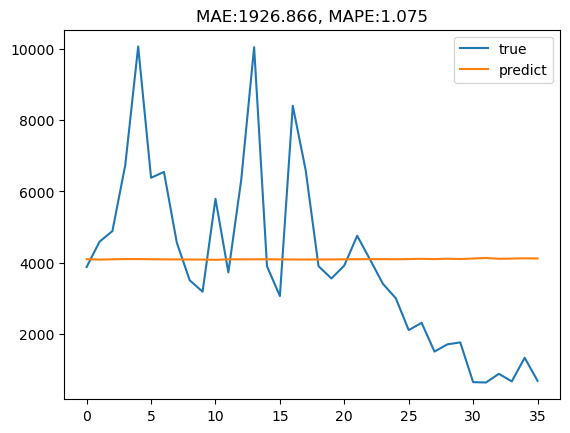

In [182]:
close_price_true, close_price_pred = [], []
for i in range(len(val_set)):
    x,y = val_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device))
    
    np_output = pred.detach().numpy()[0]
    np_target = y[0][0].item()
    np_output = np.sqrt(scaler.var_[3])*np_output + scaler.mean_[3] #dim=3為close price的
    np_target = np.sqrt(scaler.var_[3])*np_target + scaler.mean_[3]
    
    close_price_true.append(np_target)
    close_price_pred.append(np_output[0])
 
mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
plt.plot(close_price_true)
plt.plot(close_price_pred)
plt.title('MAE:{:.3f}, MAPE:{:.3f}'.format(mae, mape))
plt.legend(['true', 'predict'])

In [183]:
class LSTMEncoder(nn.Module):
    
    def __init__(self, n_features, hidden_dim, embedding_dim):
        super(LSTMEncoder, self).__init__()
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        
        self.lstm1 = nn.LSTM(input_size=self.n_features, hidden_size=self.hidden_dim, 
                            num_layers=1, bidirectional=False, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=self.hidden_dim, hidden_size=self.embedding_dim, 
                            num_layers=1, bidirectional=False, batch_first=True)
        
    def forward(self, x): 
        x, _ = self.lstm1(x)
        x, hidden = self.lstm2(x)
        
        return x
        

class LSTMDecoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, n_features):
        super(LSTMDecoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        
        self.lstm1 = nn.LSTM(self.embedding_dim, self.embedding_dim, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(self.embedding_dim, self.hidden_dim, num_layers=1, batch_first=True)
        self.output_layer = nn.Linear(self.hidden_dim, n_features)
        
    def forward(self, x):
        x, _ = self.lstm1(x)      # from (batch, seq_len, embedding_dim) to (batch, seq_len, embedding_dim)
        x, _ = self.lstm2(x)      # from (batch, seq_len, embedding_dim) to (batch, seq_len, hidden_dim)
        output = self.output_layer(x)  # from (batch, seq_len, hidden_dim) to (batch, seq_len, n_features)
        
        return output


class LSTMAutoencoder(nn.Module):
    def __init__(self, output_seq_len, n_features, hidden_dim, embedding_dim):
        super(LSTMAutoencoder, self).__init__()
        self.output_seq_len = output_seq_len
        self.encoder = LSTMEncoder(n_features, hidden_dim, embedding_dim)
        self.decoder = LSTMDecoder(embedding_dim, hidden_dim, n_features)
        
    def forward(self, x):
        code = self.encoder(x)
        
        code = code[:,-1,:] # choose the last output
        code = code.unsqueeze(1)
        code = code.repeat(1, self.output_seq_len, 1)
        
        output = self.decoder(code)
        return output

model = LSTMAutoencoder(5, 5, 64, 36)
model        

LSTMAutoencoder(
  (encoder): LSTMEncoder(
    (lstm1): LSTM(5, 64, batch_first=True)
    (lstm2): LSTM(64, 36, batch_first=True)
  )
  (decoder): LSTMDecoder(
    (lstm1): LSTM(36, 36, batch_first=True)
    (lstm2): LSTM(36, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=5, bias=True)
  )
)

In [185]:
class weighted_MSE(nn.Module):
    def __init__(self, weight):
        super().__init__()
        self.weight = torch.tensor(weight)
        
    def forward(self, output, target):
        dist = torch.square(output - target)
        dist = dist.reshape(-1, 5)
        dist = torch.mul(dist, self.weight) # weight will be broadcast
        return torch.mean(dist)

In [186]:
# inverse transform 回原本的scale 計算 MAE
class My_loss(nn.Module):
    def __init__(self, scaler):
        super().__init__()
        self.scaler = scaler
        
    def forward(self, output, target):
        np_output = output.detach().cpu().numpy()
        np_target = target.detach().cpu().numpy()
        
        np_output = self.scaler.inverse_transform(np_output)[:,:,3] #只在意close價的預測差距
        np_target = self.scaler.inverse_transform(np_target)[:,:,3]
        
        return np.mean(np.absolute(np_output - np_target))

rescale_MAE = My_loss(scaler)

In [194]:
# 選擇特徵和目標列
features = ['氣溫(℃)', '最低氣溫(℃)', '測站氣壓(hPa)', '總卵粒數', '陽性率%']
target = ['總卵粒數']

# 提取特徵和目標
X = df[features].values
y = df[target].values

# 標準化數據
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 劃分訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 將數據轉換為 PyTorch 張量
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [198]:
# 定義 LSTM 模型
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # 初始化隱藏狀態和細胞狀態
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # 前向傳播
        out, _ = self.lstm(x, (h0, c0))
        out = self.linear(out[:, -1, :])  # 只取序列的最後一個時間步的輸出
        return out

In [199]:
# 使用模型
input_size = 5  # 特徵的維度
hidden_size = 128  # 隱藏層的維度
output_size = 1  # 輸出的維度
num_layers = 1  # LSTM 層的層數

model = LSTM(input_size, hidden_size, output_size, num_layers)

In [200]:
# 初始化模型
input_size = X_train.shape[1]
hidden_size = 128
output_size = 1
model = LSTM(input_size, hidden_size, output_size)

# 定義損失函數和優化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [201]:
# 訓練模型
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 在測試集上進行預測
model.eval()
with torch.no_grad():
    predicted = model(X_test)

# 計算測試集上的損失
test_loss = criterion(predicted, y_test)
print(f'Test Loss: {test_loss.item():.4f}')

RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors